## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


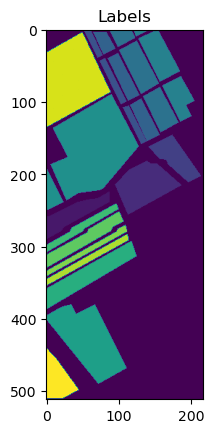

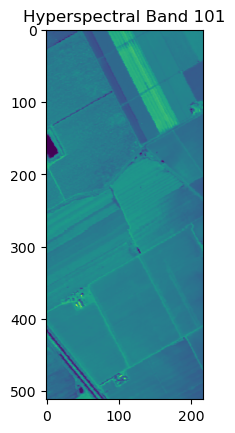

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53729 samples
	shape (53729, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(320, 5, 5, 204)
(80, 5, 5, 204)
(53729, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1563, PSNR: 7.1826


	 Training Batch [200/677], Loss: 0.0884, PSNR: 9.6754


	 Training Batch [400/677], Loss: 0.0454, PSNR: 12.5761


	 Training Batch [600/677], Loss: 0.0249, PSNR: 15.0647


Epoch [1/50] Training Loss: 0.0668, PSNR: 11.6341
	[Val]   Batch [1/170] Loss: 0.0212, PSNR: 15.8175
	[Val]   Batch [10/170] Loss: 0.0209, PSNR: 15.9857
	[Val]   Batch [20/170] Loss: 0.0210, PSNR: 15.8862
	[Val]   Batch [30/170] Loss: 0.0217, PSNR: 15.6751
	[Val]   Batch [40/170] Loss: 0.0218, PSNR: 15.7460


	[Val]   Batch [50/170] Loss: 0.0207, PSNR: 15.9595
	[Val]   Batch [60/170] Loss: 0.0216, PSNR: 15.8324
	[Val]   Batch [70/170] Loss: 0.0212, PSNR: 15.9213
	[Val]   Batch [80/170] Loss: 0.0215, PSNR: 15.7391
	[Val]   Batch [90/170] Loss: 0.0209, PSNR: 15.9760


	[Val]   Batch [100/170] Loss: 0.0209, PSNR: 15.9020
	[Val]   Batch [110/170] Loss: 0.0210, PSNR: 15.8867
	[Val]   Batch [120/170] Loss: 0.0198, PSNR: 14.1992
	[Val]   Batch [130/170] Loss: 0.0208, PSNR: 15.9866
	[Val]   Batch [140/170] Loss: 0.0204, PSNR: 16.0382


	[Val]   Batch [150/170] Loss: 0.0219, PSNR: 15.7828
	[Val]   Batch [160/170] Loss: 0.0215, PSNR: 15.8220
	[Val]   Batch [170/170] Loss: 0.0223, PSNR: 15.1165
Epoch [1/50] Validation Loss: 0.0212, PSNR: 15.8077

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0208, PSNR: 15.5687


	 Training Batch [200/677], Loss: 0.0151, PSNR: 17.2786


	 Training Batch [400/677], Loss: 0.0128, PSNR: 18.1125


	 Training Batch [600/677], Loss: 0.0093, PSNR: 19.2792


Epoch [2/50] Training Loss: 0.0132, PSNR: 18.0280
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6299
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9816
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8509
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4410
	[Val]   Batch [40/170] Loss: 0.0094, PSNR: 19.4235


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0141
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5726
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.6824
	[Val]   Batch [80/170] Loss: 0.0090, PSNR: 19.5321
	[Val]   Batch [90/170] Loss: 0.0086, PSNR: 19.8323


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7498
	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8206
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4907
	[Val]   Batch [130/170] Loss: 0.0086, PSNR: 19.8395
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1366


	[Val]   Batch [150/170] Loss: 0.0094, PSNR: 19.4613
	[Val]   Batch [160/170] Loss: 0.0091, PSNR: 19.5717
	[Val]   Batch [170/170] Loss: 0.0093, PSNR: 18.8889
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6789

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0078, PSNR: 20.1160


	 Training Batch [200/677], Loss: 0.0073, PSNR: 20.4984


	 Training Batch [400/677], Loss: 0.0072, PSNR: 20.5808


	 Training Batch [600/677], Loss: 0.0058, PSNR: 21.4601


Epoch [3/50] Training Loss: 0.0069, PSNR: 20.7158
	[Val]   Batch [1/170] Loss: 0.0057, PSNR: 21.5133
	[Val]   Batch [10/170] Loss: 0.0052, PSNR: 22.0102
	[Val]   Batch [20/170] Loss: 0.0053, PSNR: 21.8410
	[Val]   Batch [30/170] Loss: 0.0059, PSNR: 21.3344
	[Val]   Batch [40/170] Loss: 0.0062, PSNR: 21.1954


	[Val]   Batch [50/170] Loss: 0.0050, PSNR: 22.0831
	[Val]   Batch [60/170] Loss: 0.0060, PSNR: 21.4250
	[Val]   Batch [70/170] Loss: 0.0059, PSNR: 21.4958
	[Val]   Batch [80/170] Loss: 0.0058, PSNR: 21.4324
	[Val]   Batch [90/170] Loss: 0.0055, PSNR: 21.7372


	[Val]   Batch [100/170] Loss: 0.0055, PSNR: 21.6786
	[Val]   Batch [110/170] Loss: 0.0054, PSNR: 21.7818
	[Val]   Batch [120/170] Loss: 0.0044, PSNR: 20.7239
	[Val]   Batch [130/170] Loss: 0.0055, PSNR: 21.7771
	[Val]   Batch [140/170] Loss: 0.0049, PSNR: 22.2264


	[Val]   Batch [150/170] Loss: 0.0062, PSNR: 21.2900
	[Val]   Batch [160/170] Loss: 0.0059, PSNR: 21.4072
	[Val]   Batch [170/170] Loss: 0.0060, PSNR: 20.7999
Epoch [3/50] Validation Loss: 0.0056, PSNR: 21.6201

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0057, PSNR: 21.5597


	 Training Batch [200/677], Loss: 0.0044, PSNR: 22.6912


	 Training Batch [400/677], Loss: 0.0040, PSNR: 23.1333


	 Training Batch [600/677], Loss: 0.0038, PSNR: 23.2546


Epoch [4/50] Training Loss: 0.0046, PSNR: 22.5133
	[Val]   Batch [1/170] Loss: 0.0033, PSNR: 23.8504
	[Val]   Batch [10/170] Loss: 0.0032, PSNR: 24.1578
	[Val]   Batch [20/170] Loss: 0.0032, PSNR: 24.0490
	[Val]   Batch [30/170] Loss: 0.0035, PSNR: 23.5851
	[Val]   Batch [40/170] Loss: 0.0036, PSNR: 23.5517


	[Val]   Batch [50/170] Loss: 0.0031, PSNR: 24.1959
	[Val]   Batch [60/170] Loss: 0.0035, PSNR: 23.7208
	[Val]   Batch [70/170] Loss: 0.0034, PSNR: 23.8604
	[Val]   Batch [80/170] Loss: 0.0034, PSNR: 23.7385
	[Val]   Batch [90/170] Loss: 0.0033, PSNR: 23.9683


	[Val]   Batch [100/170] Loss: 0.0034, PSNR: 23.7994
	[Val]   Batch [110/170] Loss: 0.0032, PSNR: 23.9945
	[Val]   Batch [120/170] Loss: 0.0028, PSNR: 22.7000
	[Val]   Batch [130/170] Loss: 0.0033, PSNR: 23.9343
	[Val]   Batch [140/170] Loss: 0.0030, PSNR: 24.3997


	[Val]   Batch [150/170] Loss: 0.0036, PSNR: 23.5793
	[Val]   Batch [160/170] Loss: 0.0035, PSNR: 23.7511
	[Val]   Batch [170/170] Loss: 0.0035, PSNR: 23.1525
Epoch [4/50] Validation Loss: 0.0033, PSNR: 23.8641

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0036, PSNR: 23.3762


	 Training Batch [200/677], Loss: 0.0027, PSNR: 24.7660


	 Training Batch [400/677], Loss: 0.0025, PSNR: 25.1784


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.6540


Epoch [5/50] Training Loss: 0.0028, PSNR: 24.7328
	[Val]   Batch [1/170] Loss: 0.0021, PSNR: 25.9514
	[Val]   Batch [10/170] Loss: 0.0020, PSNR: 26.2257
	[Val]   Batch [20/170] Loss: 0.0020, PSNR: 26.0469
	[Val]   Batch [30/170] Loss: 0.0022, PSNR: 25.5961
	[Val]   Batch [40/170] Loss: 0.0021, PSNR: 25.8156


	[Val]   Batch [50/170] Loss: 0.0020, PSNR: 26.0935
	[Val]   Batch [60/170] Loss: 0.0022, PSNR: 25.8325
	[Val]   Batch [70/170] Loss: 0.0021, PSNR: 26.0483
	[Val]   Batch [80/170] Loss: 0.0021, PSNR: 25.8954


	[Val]   Batch [90/170] Loss: 0.0021, PSNR: 26.0348
	[Val]   Batch [100/170] Loss: 0.0022, PSNR: 25.7395
	[Val]   Batch [110/170] Loss: 0.0020, PSNR: 26.1490
	[Val]   Batch [120/170] Loss: 0.0019, PSNR: 24.3684
	[Val]   Batch [130/170] Loss: 0.0022, PSNR: 25.8218


	[Val]   Batch [140/170] Loss: 0.0019, PSNR: 26.4009
	[Val]   Batch [150/170] Loss: 0.0022, PSNR: 25.7508
	[Val]   Batch [160/170] Loss: 0.0021, PSNR: 25.8995
	[Val]   Batch [170/170] Loss: 0.0022, PSNR: 25.2160
Epoch [5/50] Validation Loss: 0.0021, PSNR: 25.9072

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0023, PSNR: 25.4860


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.7041


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.6562


	 Training Batch [600/677], Loss: 0.0019, PSNR: 26.3587


Epoch [6/50] Training Loss: 0.0019, PSNR: 26.2925
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.4860
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.7476
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.5230
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.0061
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.4355


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5066
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.3190
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.6752
	[Val]   Batch [80/170] Loss: 0.0015, PSNR: 27.4268
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.5760


	[Val]   Batch [100/170] Loss: 0.0016, PSNR: 27.1446
	[Val]   Batch [110/170] Loss: 0.0014, PSNR: 27.7691
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.7127
	[Val]   Batch [130/170] Loss: 0.0016, PSNR: 27.2022
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.9290


	[Val]   Batch [150/170] Loss: 0.0016, PSNR: 27.2427
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4272
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.7331
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.3983

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 26.9690


	 Training Batch [200/677], Loss: 0.0016, PSNR: 27.0121


	 Training Batch [400/677], Loss: 0.0014, PSNR: 27.6645


	 Training Batch [600/677], Loss: 0.0015, PSNR: 27.4187


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.3649
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.5251
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.7952
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5419
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.9920
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.5395


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.4295
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.3476
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.7772
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.4936
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.6163


	[Val]   Batch [100/170] Loss: 0.0013, PSNR: 28.1230
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.9080
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.5808
	[Val]   Batch [130/170] Loss: 0.0013, PSNR: 28.1927
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 28.9457


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.2840
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.4829
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.8444
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.4263

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 27.0978


	 Training Batch [200/677], Loss: 0.0013, PSNR: 27.9979


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.5893


	 Training Batch [600/677], Loss: 0.0010, PSNR: 28.5154


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.1817
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.3698
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.6281
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.3325
	[Val]   Batch [30/170] Loss: 0.0011, PSNR: 28.7599
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.4185


	[Val]   Batch [50/170] Loss: 0.0010, PSNR: 29.2437
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.1573
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.6669
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.3196
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.4997


	[Val]   Batch [100/170] Loss: 0.0011, PSNR: 28.8886
	[Val]   Batch [110/170] Loss: 0.0009, PSNR: 29.8068
	[Val]   Batch [120/170] Loss: 0.0010, PSNR: 27.3759
	[Val]   Batch [130/170] Loss: 0.0011, PSNR: 28.9585
	[Val]   Batch [140/170] Loss: 0.0009, PSNR: 29.8217


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.0497
	[Val]   Batch [160/170] Loss: 0.0010, PSNR: 29.3003
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.6178
Epoch [8/50] Validation Loss: 0.0010, PSNR: 29.2303

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 28.0770


	 Training Batch [200/677], Loss: 0.0012, PSNR: 28.0662


	 Training Batch [400/677], Loss: 0.0010, PSNR: 28.9246


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5931


Epoch [9/50] Training Loss: 0.0011, PSNR: 28.9016
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3670
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6441
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.3424
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7110
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4310


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1440
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1297
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.6969
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3447
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5227


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.8578
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8978
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.2848
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.9362


	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8497
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0157
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2845
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.7209
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2241

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.2251


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.5557


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.4938


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.0320


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.5164
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 30.9992
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3085
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.9695
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.3753
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.0835


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.7177
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.7952
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3198
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0248
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.1957


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.5439
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.5422
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.8799
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.6216
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.4765


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7068
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9038
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.4693
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.8755

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1485


	 Training Batch [200/677], Loss: 0.0007, PSNR: 31.0040


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4804


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.2108


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1158
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.7113
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.0040
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.6286
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.0943
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.7933


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.3940
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.5036
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.0173
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.7375
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.0051


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.3094
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.2787
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.6701
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.3790


	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.2288
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.3971
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.5765
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.2073
Epoch [11/50] Validation Loss: 0.0006, PSNR: 31.5777

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.8970


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.5749


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.7264


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.4555


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.6483
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.5015
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.8166
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.3667
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.8957
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.5876


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1077
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.3160
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.7783
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.5722
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.8351


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.1377
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.0947
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.3714
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.2119
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.9980


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.2265
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.3273
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.0893
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.3754

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7360


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.8410


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.0789


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.9282


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1477
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0732
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3636
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.9053
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.4693
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.1274


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6322
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.8780
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2891
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.1280
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.4440


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.7359
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.6374
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9812
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.8245
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5578


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.7844
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8324
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.7571
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9324

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.5228


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.3149


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.5240


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.0105


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5440
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5978
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.9350
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.3885
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.0549
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6820


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.1429
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4711
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.8063
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7142
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0616


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.3758
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1661
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.5096
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.4639
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0882


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.4145
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3459
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.4055
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.4911

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.5792


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.5066


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9765


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.2303


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9264
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.0836
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.3986
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.8031
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.5839
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.1590


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.5823
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.9911
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.2247
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.2313


	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.5772
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.9012
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.6388
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.9454
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.9855


	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.5425
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.9169
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.7655
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.9721
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.9673

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.2799


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3542


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9759


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8851


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2612
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.5991
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.9314
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.3116
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.1204
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.6504
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.0280


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.5355
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.6669
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.8046
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 35.1004
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.4459


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.1701
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.4214
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.5626
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 35.0239
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.4947


	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.2514
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.7430
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.5004

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 29.6012


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.9415


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.0832


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.3625


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5656
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.0239
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4036
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7226
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.5664
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.0839
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.4587


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.9730
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.0789
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.2213
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.5906
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.9249


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6108
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9140
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 35.0230
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.4829


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9356
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.6177
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.1668
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.9232

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.1103


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.6461


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.1482


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.4133


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8425
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.2659
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.6184
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.9034
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.8309
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.2848


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.7536
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.2104
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.3016
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.4353
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.9124


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.2269
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.8572
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.2691
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.3409
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.7527


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.1822
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.8380
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.2833
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.1569

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.3887


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4387


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.9546


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.5552


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.0751
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.5398
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.8587
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.1564
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.1375
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.5706


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9725
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.5359
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.5727
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.7439
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.2189


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.5425
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.1461
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.5371
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.6189
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.0184


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.5200
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 35.0935
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.5516
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.4270

LOG: Epoch [20/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.6461


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.5295


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.2941


	 Training Batch [600/677], Loss: 0.0003, PSNR: 33.6481


Epoch [20/50] Training Loss: 0.0004, PSNR: 33.3259
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.9402
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 36.3055
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.5325
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.5796
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.9935


	[Val]   Batch [50/170] Loss: 0.0002, PSNR: 35.3020
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 36.0048
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.9891
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 36.2695
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.6521


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 36.0206
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.5960
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.8429
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 36.1524
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 36.3778


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.9935
	[Val]   Batch [160/170] Loss: 0.0002, PSNR: 35.5139
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 36.3245
Epoch [20/50] Validation Loss: 0.0002, PSNR: 35.8829
Early stopping triggered at epoch 20. No improvement for 3 epochs.


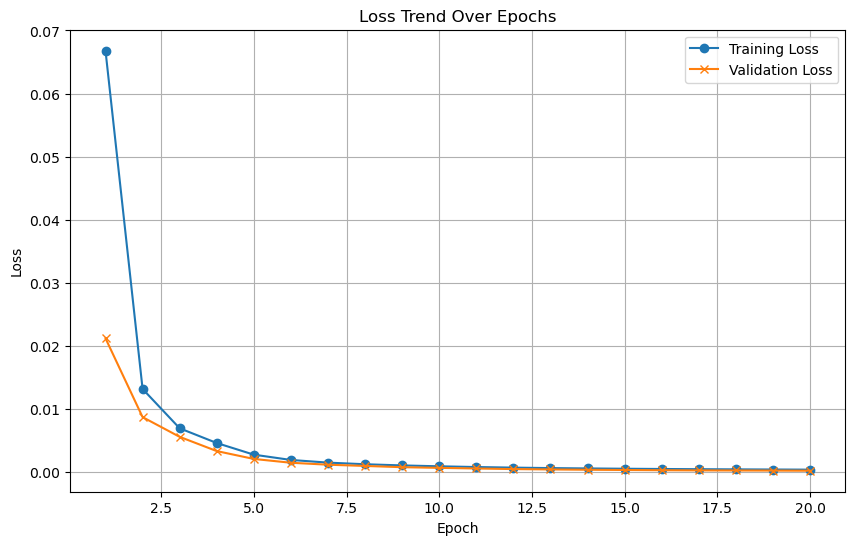

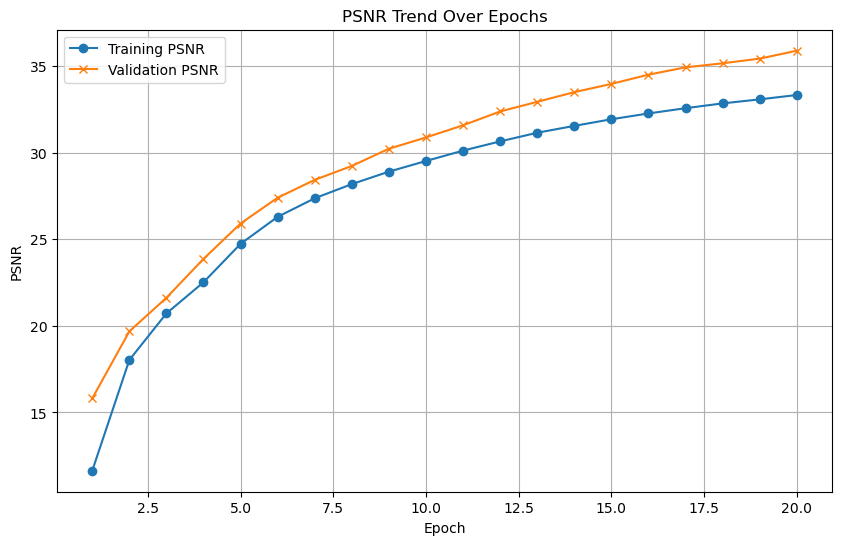

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/210 for test dataset.


    Processed batch 101/210 for test dataset.


    Processed batch 201/210 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7897
    Validation Batch [1/1], Loss: 2.7787
Validation Loss: 2.7787, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7787. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7483
    Validation Batch [1/1], Loss: 2.7787
Validation Loss: 2.7787, Validation Accuracy: 6.25%
Validation loss improved from 2.7787 to 2.7787. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7217
    Validation Batch [1/1], Loss: 2.7787
Validation Loss: 2.7787, Validation Accuracy: 6.25%
Validation loss improved from 2.7787 to 2.7787. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6920
    Validation Batch [1/1], Loss: 2.7788
Validation Loss: 2.7788, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Epoch 

Epoch [16/1000] completed, Average Training Loss: 2.5327
    Validation Batch [1/1], Loss: 2.7778
Validation Loss: 2.7778, Validation Accuracy: 6.25%
Validation loss improved from 2.7780 to 2.7778. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5207
    Validation Batch [1/1], Loss: 2.7776
Validation Loss: 2.7776, Validation Accuracy: 6.25%
Validation loss improved from 2.7778 to 2.7776. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5279
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss improved from 2.7776 to 2.7775. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5151
    Validation Batch [1/1], Loss: 2.7773
Validation Loss: 2.7773, Validation Accuracy: 6.25%
Validation loss improved from 2.7775 to 2.7773. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/10

Epoch [39/1000] completed, Average Training Loss: 2.3320
    Validation Batch [1/1], Loss: 2.7276
Validation Loss: 2.7276, Validation Accuracy: 12.50%
Validation loss improved from 2.7350 to 2.7276. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3137
    Validation Batch [1/1], Loss: 2.7176
Validation Loss: 2.7176, Validation Accuracy: 12.50%
Validation loss improved from 2.7276 to 2.7176. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.2914
    Validation Batch [1/1], Loss: 2.7064
Validation Loss: 2.7064, Validation Accuracy: 12.50%
Validation loss improved from 2.7176 to 2.7064. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.2978
    Validation Batch [1/1], Loss: 2.6949
Validation Loss: 2.6949, Validation Accuracy: 12.50%
Validation loss improved from 2.7064 to 2.6949. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [60/1000] completed, Average Training Loss: 2.1421
    Validation Batch [1/1], Loss: 2.3601
Validation Loss: 2.3601, Validation Accuracy: 43.75%
Validation loss improved from 2.3913 to 2.3601. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.1386
    Validation Batch [1/1], Loss: 2.3463
Validation Loss: 2.3463, Validation Accuracy: 43.75%
Validation loss improved from 2.3601 to 2.3463. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.1341
    Validation Batch [1/1], Loss: 2.3226
Validation Loss: 2.3226, Validation Accuracy: 46.25%
Validation loss improved from 2.3463 to 2.3226. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.1162
    Validation Batch [1/1], Loss: 2.3063
Validation Loss: 2.3063, Validation Accuracy: 48.75%
Validation loss improved from 2.3226 to 2.3063. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [6

Epoch [74/1000] completed, Average Training Loss: 2.0305
    Validation Batch [1/1], Loss: 2.1187
Validation Loss: 2.1187, Validation Accuracy: 51.25%
Validation loss improved from 2.1232 to 2.1187. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.0222
    Validation Batch [1/1], Loss: 2.1014
Validation Loss: 2.1014, Validation Accuracy: 53.75%
Validation loss improved from 2.1187 to 2.1014. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.0118
    Validation Batch [1/1], Loss: 2.0902
Validation Loss: 2.0902, Validation Accuracy: 52.50%
Validation loss improved from 2.1014 to 2.0902. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9936
    Validation Batch [1/1], Loss: 2.0692
Validation Loss: 2.0692, Validation Accuracy: 52.50%
Validation loss improved from 2.0902 to 2.0692. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [7

Epoch [96/1000] completed, Average Training Loss: 1.8312
    Validation Batch [1/1], Loss: 1.8552
Validation Loss: 1.8552, Validation Accuracy: 62.50%
Validation loss improved from 1.8626 to 1.8552. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.8229
    Validation Batch [1/1], Loss: 1.8393
Validation Loss: 1.8393, Validation Accuracy: 67.50%
Validation loss improved from 1.8552 to 1.8393. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8221
    Validation Batch [1/1], Loss: 1.8152
Validation Loss: 1.8152, Validation Accuracy: 65.00%
Validation loss improved from 1.8393 to 1.8152. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8023
    Validation Batch [1/1], Loss: 1.8202
Validation Loss: 1.8202, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] compl

    Validation Batch [1/1], Loss: 1.6506
Validation Loss: 1.6506, Validation Accuracy: 70.00%
Validation loss improved from 1.6576 to 1.6506. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.6380
    Validation Batch [1/1], Loss: 1.6404
Validation Loss: 1.6404, Validation Accuracy: 75.00%
Validation loss improved from 1.6506 to 1.6404. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.6383
    Validation Batch [1/1], Loss: 1.6281
Validation Loss: 1.6281, Validation Accuracy: 78.75%
Validation loss improved from 1.6404 to 1.6281. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6348
    Validation Batch [1/1], Loss: 1.6090
Validation Loss: 1.6090, Validation Accuracy: 75.00%
Validation loss improved from 1.6281 to 1.6090. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6265


Epoch [141/1000] completed, Average Training Loss: 1.4650
    Validation Batch [1/1], Loss: 1.4626
Validation Loss: 1.4626, Validation Accuracy: 83.75%
Validation loss improved from 1.4698 to 1.4626. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4453
    Validation Batch [1/1], Loss: 1.4687
Validation Loss: 1.4687, Validation Accuracy: 78.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4307
    Validation Batch [1/1], Loss: 1.4555
Validation Loss: 1.4555, Validation Accuracy: 85.00%
Validation loss improved from 1.4626 to 1.4555. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.4385
    Validation Batch [1/1], Loss: 1.4563
Validation Loss: 1.4563, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Av

Epoch [161/1000] completed, Average Training Loss: 1.2674
    Validation Batch [1/1], Loss: 1.3023
Validation Loss: 1.3023, Validation Accuracy: 86.25%
Validation loss improved from 1.3087 to 1.3023. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.2861
    Validation Batch [1/1], Loss: 1.2946
Validation Loss: 1.2946, Validation Accuracy: 85.00%
Validation loss improved from 1.3023 to 1.2946. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.2586
    Validation Batch [1/1], Loss: 1.2812
Validation Loss: 1.2812, Validation Accuracy: 85.00%
Validation loss improved from 1.2946 to 1.2812. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.2778
    Validation Batch [1/1], Loss: 1.2661
Validation Loss: 1.2661, Validation Accuracy: 87.50%
Validation loss improved from 1.2812 to 1.2661. Saving model...

LOG: Epoch [165/1000] - Training


Epoch [184/1000] completed, Average Training Loss: 1.0940
    Validation Batch [1/1], Loss: 1.1105
Validation Loss: 1.1105, Validation Accuracy: 87.50%
Validation loss improved from 1.1234 to 1.1105. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 1.0835
    Validation Batch [1/1], Loss: 1.1147
Validation Loss: 1.1147, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.0746
    Validation Batch [1/1], Loss: 1.1109
Validation Loss: 1.1109, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.0542
    Validation Batch [1/1], Loss: 1.0935
Validation Loss: 1.0935, Validation Accuracy: 88.75%
Validation loss improved from 1.1105 to 1.0935. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Av

Epoch [207/1000] completed, Average Training Loss: 0.9159
    Validation Batch [1/1], Loss: 0.9646
Validation Loss: 0.9646, Validation Accuracy: 91.25%
Validation loss improved from 0.9749 to 0.9646. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.9360
    Validation Batch [1/1], Loss: 0.9905
Validation Loss: 0.9905, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.8850
    Validation Batch [1/1], Loss: 0.9578
Validation Loss: 0.9578, Validation Accuracy: 88.75%
Validation loss improved from 0.9646 to 0.9578. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8907
    Validation Batch [1/1], Loss: 0.9434
Validation Loss: 0.9434, Validation Accuracy: 90.00%
Validation loss improved from 0.9578 to 0.9434. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000

Epoch [230/1000] completed, Average Training Loss: 0.7604
    Validation Batch [1/1], Loss: 0.8281
Validation Loss: 0.8281, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7243
    Validation Batch [1/1], Loss: 0.8055
Validation Loss: 0.8055, Validation Accuracy: 90.00%
Validation loss improved from 0.8159 to 0.8055. Saving model...

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7676
    Validation Batch [1/1], Loss: 0.7931
Validation Loss: 0.7931, Validation Accuracy: 93.75%
Validation loss improved from 0.8055 to 0.7931. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7450
    Validation Batch [1/1], Loss: 0.7831
Validation Loss: 0.7831, Validation Accuracy: 88.75%
Validation loss improved from 0.7931 to 0.7831. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000

Epoch [253/1000] completed, Average Training Loss: 0.6247
    Validation Batch [1/1], Loss: 0.6869
Validation Loss: 0.6869, Validation Accuracy: 90.00%
Validation loss improved from 0.6875 to 0.6869. Saving model...

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.6021
    Validation Batch [1/1], Loss: 0.6850
Validation Loss: 0.6850, Validation Accuracy: 93.75%
Validation loss improved from 0.6869 to 0.6850. Saving model...

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.5695
    Validation Batch [1/1], Loss: 0.6840
Validation Loss: 0.6840, Validation Accuracy: 90.00%
Validation loss improved from 0.6850 to 0.6840. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5880
    Validation Batch [1/1], Loss: 0.6835
Validation Loss: 0.6835, Validation Accuracy: 88.75%
Validation loss improved from 0.6840 to 0.6835. Saving model...

LOG: Epoch [257/1000] - Training


Epoch [276/1000] completed, Average Training Loss: 0.5071
    Validation Batch [1/1], Loss: 0.5828
Validation Loss: 0.5828, Validation Accuracy: 92.50%
Validation loss improved from 0.5965 to 0.5828. Saving model...

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4768
    Validation Batch [1/1], Loss: 0.5776
Validation Loss: 0.5776, Validation Accuracy: 92.50%
Validation loss improved from 0.5828 to 0.5776. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4774
    Validation Batch [1/1], Loss: 0.5740
Validation Loss: 0.5740, Validation Accuracy: 90.00%
Validation loss improved from 0.5776 to 0.5740. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4767
    Validation Batch [1/1], Loss: 0.5946
Validation Loss: 0.5946, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000

Epoch [298/1000] completed, Average Training Loss: 0.4099
    Validation Batch [1/1], Loss: 0.5049
Validation Loss: 0.5049, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.4047
    Validation Batch [1/1], Loss: 0.5228
Validation Loss: 0.5228, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3987
    Validation Batch [1/1], Loss: 0.5175
Validation Loss: 0.5175, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.4025
    Validation Batch [1/1], Loss: 0.5223
Validation Loss: 0.5223, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3842
  

Epoch [320/1000] completed, Average Training Loss: 0.3171
    Validation Batch [1/1], Loss: 0.4739
Validation Loss: 0.4739, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.3117
    Validation Batch [1/1], Loss: 0.4590
Validation Loss: 0.4590, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3088
    Validation Batch [1/1], Loss: 0.4661
Validation Loss: 0.4661, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.3174
    Validation Batch [1/1], Loss: 0.4706
Validation Loss: 0.4706, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.3217
  

Epoch [342/1000] completed, Average Training Loss: 0.2600
    Validation Batch [1/1], Loss: 0.4037
Validation Loss: 0.4037, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.2858
    Validation Batch [1/1], Loss: 0.4029
Validation Loss: 0.4029, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2814
    Validation Batch [1/1], Loss: 0.4139
Validation Loss: 0.4139, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2722
    Validation Batch [1/1], Loss: 0.4188
Validation Loss: 0.4188, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2782
  

Epoch [364/1000] completed, Average Training Loss: 0.2407
    Validation Batch [1/1], Loss: 0.4007
Validation Loss: 0.4007, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2199
    Validation Batch [1/1], Loss: 0.3851
Validation Loss: 0.3851, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.2366
    Validation Batch [1/1], Loss: 0.3812
Validation Loss: 0.3812, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2290
    Validation Batch [1/1], Loss: 0.3798
Validation Loss: 0.3798, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.219

Epoch [386/1000] completed, Average Training Loss: 0.2083
    Validation Batch [1/1], Loss: 0.3654
Validation Loss: 0.3654, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2155
    Validation Batch [1/1], Loss: 0.3753
Validation Loss: 0.3753, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1951
    Validation Batch [1/1], Loss: 0.3697
Validation Loss: 0.3697, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1871
    Validation Batch [1/1], Loss: 0.3661
Validation Loss: 0.3661, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1796
  

    Validation Batch [1/1], Loss: 0.3565
Validation Loss: 0.3565, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1796
    Validation Batch [1/1], Loss: 0.3419
Validation Loss: 0.3419, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1628
    Validation Batch [1/1], Loss: 0.3585
Validation Loss: 0.3585, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1595
    Validation Batch [1/1], Loss: 0.3706
Validation Loss: 0.3706, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1549
    Validation Batch [1/1], Loss: 0.3514
Validation Loss: 0.

Epoch [432/1000] completed, Average Training Loss: 0.1550
    Validation Batch [1/1], Loss: 0.3481
Validation Loss: 0.3481, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1427
    Validation Batch [1/1], Loss: 0.3403
Validation Loss: 0.3403, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1443
    Validation Batch [1/1], Loss: 0.3250
Validation Loss: 0.3250, Validation Accuracy: 91.25%
Validation loss improved from 0.3331 to 0.3250. Saving model...

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1525
    Validation Batch [1/1], Loss: 0.3588
Validation Loss: 0.3588, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training 

Epoch [454/1000] completed, Average Training Loss: 0.1228
    Validation Batch [1/1], Loss: 0.3542
Validation Loss: 0.3542, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1314
    Validation Batch [1/1], Loss: 0.3672
Validation Loss: 0.3672, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1121
    Validation Batch [1/1], Loss: 0.3334
Validation Loss: 0.3334, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1224
    Validation Batch [1/1], Loss: 0.3148
Validation Loss: 0.3148, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.121

Epoch [478/1000] completed, Average Training Loss: 0.1117
    Validation Batch [1/1], Loss: 0.3280
Validation Loss: 0.3280, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1066
    Validation Batch [1/1], Loss: 0.3353
Validation Loss: 0.3353, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.1128
    Validation Batch [1/1], Loss: 0.3176
Validation Loss: 0.3176, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.1210
    Validation Batch [1/1], Loss: 0.3200
Validation Loss: 0.3200, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.117

Epoch [501/1000] completed, Average Training Loss: 0.1011
    Validation Batch [1/1], Loss: 0.3369
Validation Loss: 0.3369, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0958
    Validation Batch [1/1], Loss: 0.3202
Validation Loss: 0.3202, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0945
    Validation Batch [1/1], Loss: 0.3154
Validation Loss: 0.3154, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [504/1000] - Training
Epoch [504/1000] completed, Average Training Loss: 0.1085
    Validation Batch [1/1], Loss: 0.3085
Validation Loss: 0.3085, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.085

Epoch [524/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.3464
Validation Loss: 0.3464, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0873
    Validation Batch [1/1], Loss: 0.3165
Validation Loss: 0.3165, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.3092
Validation Loss: 0.3092, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0851
    Validation Batch [1/1], Loss: 0.3135
Validation Loss: 0.3135, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.076

    Validation Batch [1/1], Loss: 0.3286
Validation Loss: 0.3286, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0823
    Validation Batch [1/1], Loss: 0.3099
Validation Loss: 0.3099, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0712
    Validation Batch [1/1], Loss: 0.3305
Validation Loss: 0.3305, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.3320
Validation Loss: 0.3320, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.3657
Validation Loss

Epoch [571/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.3404
Validation Loss: 0.3404, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.3296
Validation Loss: 0.3296, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0.0641
    Validation Batch [1/1], Loss: 0.3265
Validation Loss: 0.3265, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.3382
Validation Loss: 0.3382, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.064

Epoch [595/1000] completed, Average Training Loss: 0.0601
    Validation Batch [1/1], Loss: 0.3253
Validation Loss: 0.3253, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [596/1000] - Training
Epoch [596/1000] completed, Average Training Loss: 0.0604
    Validation Batch [1/1], Loss: 0.3166
Validation Loss: 0.3166, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [597/1000] - Training
Epoch [597/1000] completed, Average Training Loss: 0.0620
    Validation Batch [1/1], Loss: 0.3077
Validation Loss: 0.3077, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [598/1000] - Training
Epoch [598/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.3064
Validation Loss: 0.3064, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.073

Epoch [618/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.3800
Validation Loss: 0.3800, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.3252
Validation Loss: 0.3252, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [620/1000] - Training
Epoch [620/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.3035
Validation Loss: 0.3035, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0562
    Validation Batch [1/1], Loss: 0.3010
Validation Loss: 0.3010, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.053

    Validation Batch [1/1], Loss: 0.3006
Validation Loss: 0.3006, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0540
    Validation Batch [1/1], Loss: 0.3082
Validation Loss: 0.3082, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0556
    Validation Batch [1/1], Loss: 0.3155
Validation Loss: 0.3155, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.3177
Validation Loss: 0.3177, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.3198
Validation Loss: 0.

Epoch [665/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.3409
Validation Loss: 0.3409, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0538
    Validation Batch [1/1], Loss: 0.3418
Validation Loss: 0.3418, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.3364
Validation Loss: 0.3364, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0474
    Validation Batch [1/1], Loss: 0.3304
Validation Loss: 0.3304, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [669/1000] - Training
Epoch [669/1000] completed, Average Training Loss: 0.037

Epoch [688/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1], Loss: 0.3134
Validation Loss: 0.3134, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0440
    Validation Batch [1/1], Loss: 0.3180
Validation Loss: 0.3180, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.3252
Validation Loss: 0.3252, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0415
    Validation Batch [1/1], Loss: 0.3274
Validation Loss: 0.3274, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.043

Epoch [712/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.3364
Validation Loss: 0.3364, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [713/1000] - Training
Epoch [713/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.3444
Validation Loss: 0.3444, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [714/1000] - Training
Epoch [714/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.3374
Validation Loss: 0.3374, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [715/1000] - Training
Epoch [715/1000] completed, Average Training Loss: 0.0446
    Validation Batch [1/1], Loss: 0.3164
Validation Loss: 0.3164, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.042

Epoch [735/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.3181
Validation Loss: 0.3181, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [736/1000] - Training
Epoch [736/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.3196
Validation Loss: 0.3196, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [737/1000] - Training
Epoch [737/1000] completed, Average Training Loss: 0.0335
    Validation Batch [1/1], Loss: 0.3204
Validation Loss: 0.3204, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0.0365
    Validation Batch [1/1], Loss: 0.3322
Validation Loss: 0.3322, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [739/1000] - Training
Epoch [739/1000] completed, Average Training Loss: 0.040

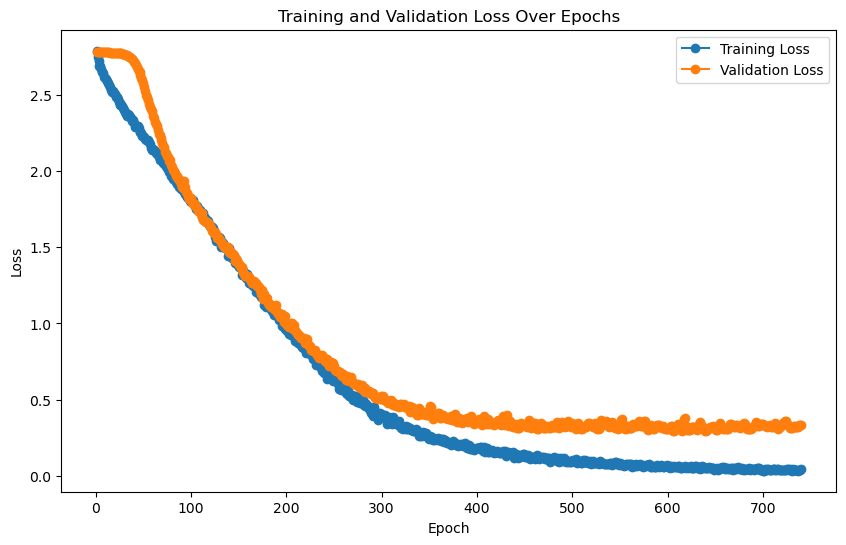

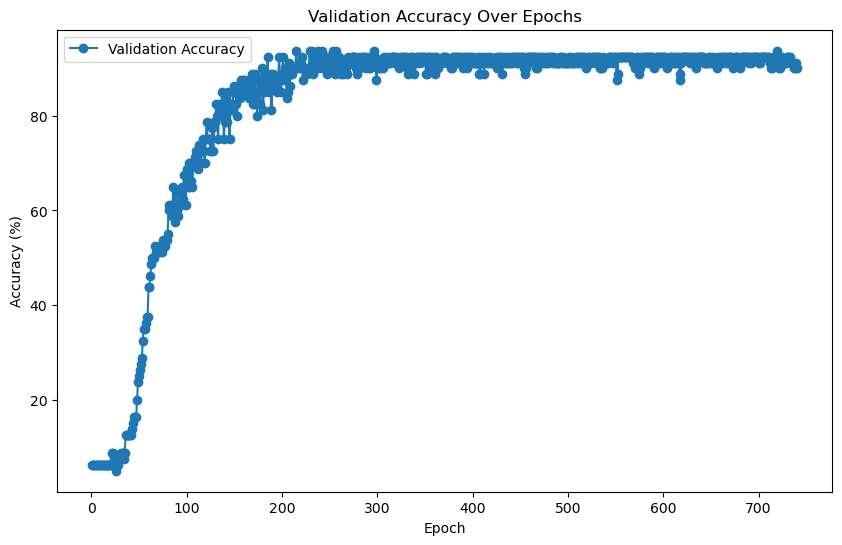


Evaluating on the test set...
    Test Batch [1/210], Loss: 0.4962



Final Test Loss: 0.3861, Test Accuracy: 88.84%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.


  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.
  Processed batch 60/210 for test dataset.


  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.


  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.


  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.


  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53729, 64), Test labels shape: (53729,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.67      0.40      0.50         5
           8       0.71      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53729, 64)
Test labels shape: (53729,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8084  |  Val Loss: 2.6389
Validation loss improved from inf to 2.6389.
[Epoch 2/1000] Train Loss: 2.6186  |  Val Loss: 2.5482
Validation loss improved from 2.6389 to 2.5482.
[Epoch 3/1000] Train Loss: 2.5234  |  Val Loss: 2.4638
Validation loss improved from 2.5482 to 2.4638.
[Epoch 4/1000] Train Loss: 2.4381  |  Val Loss: 2.3798
Validation loss improved from 2.4638 to 2.3798.
[Epoch 5/1000] Train Loss: 2.3511  |  Val Loss: 2.2980
Validation loss improved from 2.3798 to 2.2980.
[Epoch 6/1000] Train Loss: 2.2648  |  Val Loss: 2.2151
Validation loss improved from 2.2980 to 2.2151.
[Epoch 7/1000] Train Loss: 2.1813  |  Val Loss: 2.1367
Validation loss improved from 2.2151 to 2.1367.
[Epoch 8/1000] Train Loss: 2.0967  |  Val Loss: 2.0587
Validation loss improved from 2.1367 to 2.0587.
[Epoch 9/1000] Train Loss: 2.0129  |  Val Loss: 1.9796
Validation loss improved from 2.0587 to 1.9796.


[Epoch 10/1000] Train Loss: 1.9254  |  Val Loss: 1.8996
Validation loss improved from 1.9796 to 1.8996.
[Epoch 11/1000] Train Loss: 1.8337  |  Val Loss: 1.8161
Validation loss improved from 1.8996 to 1.8161.
[Epoch 12/1000] Train Loss: 1.7380  |  Val Loss: 1.7253
Validation loss improved from 1.8161 to 1.7253.
[Epoch 13/1000] Train Loss: 1.6353  |  Val Loss: 1.6295
Validation loss improved from 1.7253 to 1.6295.
[Epoch 14/1000] Train Loss: 1.5364  |  Val Loss: 1.5393
Validation loss improved from 1.6295 to 1.5393.
[Epoch 15/1000] Train Loss: 1.4276  |  Val Loss: 1.4410
Validation loss improved from 1.5393 to 1.4410.
[Epoch 16/1000] Train Loss: 1.3309  |  Val Loss: 1.3446
Validation loss improved from 1.4410 to 1.3446.
[Epoch 17/1000] Train Loss: 1.2338  |  Val Loss: 1.2592
Validation loss improved from 1.3446 to 1.2592.
[Epoch 18/1000] Train Loss: 1.1282  |  Val Loss: 1.1712
Validation loss improved from 1.2592 to 1.1712.
[Epoch 19/1000] Train Loss: 1.0483  |  Val Loss: 1.0921
Validati

[Epoch 22/1000] Train Loss: 0.8541  |  Val Loss: 0.9164
Validation loss improved from 0.9725 to 0.9164.
[Epoch 23/1000] Train Loss: 0.7928  |  Val Loss: 0.8805
Validation loss improved from 0.9164 to 0.8805.
[Epoch 24/1000] Train Loss: 0.7451  |  Val Loss: 0.8340
Validation loss improved from 0.8805 to 0.8340.
[Epoch 25/1000] Train Loss: 0.7031  |  Val Loss: 0.7995
Validation loss improved from 0.8340 to 0.7995.
[Epoch 26/1000] Train Loss: 0.6662  |  Val Loss: 0.7756
Validation loss improved from 0.7995 to 0.7756.
[Epoch 27/1000] Train Loss: 0.6335  |  Val Loss: 0.7475
Validation loss improved from 0.7756 to 0.7475.
[Epoch 28/1000] Train Loss: 0.6072  |  Val Loss: 0.7214
Validation loss improved from 0.7475 to 0.7214.


[Epoch 29/1000] Train Loss: 0.5849  |  Val Loss: 0.6943
Validation loss improved from 0.7214 to 0.6943.
[Epoch 30/1000] Train Loss: 0.5540  |  Val Loss: 0.6836
Validation loss improved from 0.6943 to 0.6836.
[Epoch 31/1000] Train Loss: 0.5351  |  Val Loss: 0.6648
Validation loss improved from 0.6836 to 0.6648.
[Epoch 32/1000] Train Loss: 0.5144  |  Val Loss: 0.6517
Validation loss improved from 0.6648 to 0.6517.
[Epoch 33/1000] Train Loss: 0.4947  |  Val Loss: 0.6346
Validation loss improved from 0.6517 to 0.6346.
[Epoch 34/1000] Train Loss: 0.4754  |  Val Loss: 0.6059
Validation loss improved from 0.6346 to 0.6059.
[Epoch 35/1000] Train Loss: 0.4670  |  Val Loss: 0.6196
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.4533  |  Val Loss: 0.5939
Validation loss improved from 0.6059 to 0.5939.
[Epoch 37/1000] Train Loss: 0.4352  |  Val Loss: 0.5829
Validation loss improved from 0.5939 to 0.5829.
[Epoch 38/1000] Train Loss: 0.4295  |  Val Loss: 0.5761
Va

[Epoch 40/1000] Train Loss: 0.4102  |  Val Loss: 0.5633
Validation loss improved from 0.5758 to 0.5633.
[Epoch 41/1000] Train Loss: 0.3875  |  Val Loss: 0.5689
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.3869  |  Val Loss: 0.5391
Validation loss improved from 0.5633 to 0.5391.
[Epoch 43/1000] Train Loss: 0.3797  |  Val Loss: 0.5507
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.3754  |  Val Loss: 0.5258
Validation loss improved from 0.5391 to 0.5258.
[Epoch 45/1000] Train Loss: 0.3599  |  Val Loss: 0.5478
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 0.3518  |  Val Loss: 0.5074
Validation loss improved from 0.5258 to 0.5074.
[Epoch 47/1000] Train Loss: 0.3415  |  Val Loss: 0.5030
Validation loss improved from 0.5074 to 0.5030.


[Epoch 48/1000] Train Loss: 0.3459  |  Val Loss: 0.5230
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.3490  |  Val Loss: 0.5105
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 0.3366  |  Val Loss: 0.4748
Validation loss improved from 0.5030 to 0.4748.
[Epoch 51/1000] Train Loss: 0.3150  |  Val Loss: 0.5098
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 52/1000] Train Loss: 0.3012  |  Val Loss: 0.5160
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 53/1000] Train Loss: 0.3024  |  Val Loss: 0.4954
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 54/1000] Train Loss: 0.2919  |  Val Loss: 0.4731
Validation loss improved from 0.4748 to 0.4731.
[Epoch 55/1000] Train Loss: 0.2911  |  Val Loss: 0.4880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.2866  |  Val Loss: 0.4660
Validation loss improved from 0.4731 to 0.4660.
[Epoch 57/1000] Train Loss: 

[Epoch 58/1000] Train Loss: 0.2709  |  Val Loss: 0.4814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.2648  |  Val Loss: 0.4601
Validation loss improved from 0.4626 to 0.4601.
[Epoch 60/1000] Train Loss: 0.2627  |  Val Loss: 0.4600
Validation loss improved from 0.4601 to 0.4600.
[Epoch 61/1000] Train Loss: 0.2615  |  Val Loss: 0.4664
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.2510  |  Val Loss: 0.4425
Validation loss improved from 0.4600 to 0.4425.
[Epoch 63/1000] Train Loss: 0.2458  |  Val Loss: 0.4628
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.2576  |  Val Loss: 0.4547
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 0.2422  |  Val Loss: 0.4581
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 66/1000] Train Loss: 0.2418  |  Val Loss: 0.4528
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 67/1000] Train Loss: 0.2406  |  Val Loss: 0.4403
Validation loss improved from 0.4425 to 0.4403.
[Epoch 68/1000] Train Loss: 0.2289  |  Val Loss: 0.4773
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.2374  |  Val Loss: 0.4482
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 0.2437  |  Val Loss: 0.4429
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 71/1000] Train Loss: 0.2218  |  Val Loss: 0.4454
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 72/1000] Train Loss: 0.2213  |  Val Loss: 0.4786
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 73/1000] Train Loss: 0.2158  |  Val Loss: 0.4325
Validation loss improved from 0.4403 to 0.4325.
[Epoch 74/1000] Train Loss: 0.2256  |  Val Loss: 0.4371
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 75/1000] Train Loss: 0.2227  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 0.2091  |  Val Loss: 0.4291
Validation loss improved from 0.4325 to 0.4291.
[Epoch 77/1000] Train Loss: 0.2067  |  Val Loss: 0.4308
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 0.1973  |  Val Loss: 0.4535
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 0.2003  |  Val Loss: 0.4393
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 0.1978  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 0.1959  |  Val Loss: 0.4361
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 82/1000] Train Loss: 0.1948  |  Val Loss: 0.4427
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 83/1000] Train Loss: 0.1910  |  Val Loss: 0.4388
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 84/1000] Train Loss: 0.1918  |  Val Loss: 0.4742
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 85/1000] Train Loss: 0.1854  |  Val Loss: 0.4445
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 86/1000] Train Loss: 0.1835  |  Val Loss: 0.4508
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 87/1000] Train Loss: 0.1791  |  Val Loss: 0.4520
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 88/1000] Train Loss: 0.1814  |  Val Loss: 0.4585
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 89/1000] Train Loss: 0.1761  |  Val Loss: 0.4408
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 90/1000] Train Loss: 0.1742  |  Val Loss: 0.4704
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 91/1000] Train Loss: 0.1758  |  Val Loss: 0.4363
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 92/1000] Train Loss: 0.1739  |  Val Loss: 0.4474
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 94/1000] Train Loss: 0.1689  |  Val Loss: 0.4623
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 95/1000] Train Loss: 0.1612  |  Val Loss: 0.4432
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 96/1000] Train Loss: 0.1618  |  Val Loss: 0.4407
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 97/1000] Train Loss: 0.1573  |  Val Loss: 0.4667
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 98/1000] Train Loss: 0.1625  |  Val Loss: 0.4246
Validation loss improved from 0.4291 to 0.4246.
[Epoch 99/1000] Train Loss: 0.1795  |  Val Loss: 0.4553
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 100/1000] Train Loss: 0.1574  |  Val Loss: 0.4505
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 101/1000] Train Loss: 0.1623  |  Val Loss: 0.4472
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 102/1000] Train Loss: 0.1548  |  Val Loss: 0.4438
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 10

[Epoch 104/1000] Train Loss: 0.1504  |  Val Loss: 0.4557
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 105/1000] Train Loss: 0.1462  |  Val Loss: 0.4397
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 106/1000] Train Loss: 0.1439  |  Val Loss: 0.4766
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 107/1000] Train Loss: 0.1413  |  Val Loss: 0.4559
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 108/1000] Train Loss: 0.1440  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 109/1000] Train Loss: 0.1488  |  Val Loss: 0.4588
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 110/1000] Train Loss: 0.1375  |  Val Loss: 0.4361
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 111/1000] Train Loss: 0.1434  |  Val Loss: 0.4916
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 112/1000] Train Loss: 0.1689  |  Val Loss: 0.4349
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 113/1000] Train Loss: 0.1770  |  Val Loss: 0.4575
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 114/1000] Train Loss: 0.1675  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 115/1000] Train Loss: 0.1563  |  Val Loss: 0.4540
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 116/1000] Train Loss: 0.1400  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 117/1000] Train Loss: 0.1308  |  Val Loss: 0.4493
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 118/1000] Train Loss: 0.1334  |  Val Loss: 0.4796
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 119/1000] Train Loss: 0.1272  |  Val Loss: 0.4387
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 120/1000] Train Loss: 0.1445  |  Val Loss: 0.4826
!! Validation loss did NOT improve !! Patience:

[Epoch 122/1000] Train Loss: 0.1360  |  Val Loss: 0.4356
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 123/1000] Train Loss: 0.1318  |  Val Loss: 0.5067
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 124/1000] Train Loss: 0.1315  |  Val Loss: 0.5161
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 125/1000] Train Loss: 0.1182  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 126/1000] Train Loss: 0.1216  |  Val Loss: 0.4897
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 127/1000] Train Loss: 0.1210  |  Val Loss: 0.5032
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 128/1000] Train Loss: 0.1174  |  Val Loss: 0.4801
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 129/1000] Train Loss: 0.1163  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 130/1000] Train Loss: 0.1188  |  Val Loss: 0.4895
!! Validation loss did NOT improve !! Patience:

[Epoch 132/1000] Train Loss: 0.1168  |  Val Loss: 0.4801
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 133/1000] Train Loss: 0.1173  |  Val Loss: 0.5087
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 134/1000] Train Loss: 0.1181  |  Val Loss: 0.4937
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 135/1000] Train Loss: 0.1147  |  Val Loss: 0.4786
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 136/1000] Train Loss: 0.1080  |  Val Loss: 0.5244
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 137/1000] Train Loss: 0.1068  |  Val Loss: 0.4787
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 138/1000] Train Loss: 0.1087  |  Val Loss: 0.4957
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 139/1000] Train Loss: 0.1142  |  Val Loss: 0.5138
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 140/1000] Train Loss: 0.1093  |  Val Loss: 0.5172
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 141/1000] Train Loss: 0.1122  |  Val Loss: 0.4724
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 142/1000] Train Loss: 0.1072  |  Val Loss: 0.5108
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 143/1000] Train Loss: 0.1039  |  Val Loss: 0.5219
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 144/1000] Train Loss: 0.1009  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 145/1000] Train Loss: 0.1018  |  Val Loss: 0.4888
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 146/1000] Train Loss: 0.1005  |  Val Loss: 0.5206
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 147/1000] Train Loss: 0.0987  |  Val Loss: 0.5278
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 148/1000] Train Loss: 0.0947  |  Val Loss: 0.5293
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.0970  |  Val Loss: 0.5382
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 153/1000] Train Loss: 0.0946  |  Val Loss: 0.5053
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 154/1000] Train Loss: 0.1008  |  Val Loss: 0.5179
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 155/1000] Train Loss: 0.1065  |  Val Loss: 0.5539
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 156/1000] Train Loss: 0.1036  |  Val Loss: 0.5094
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 157/1000] Train Loss: 0.1148  |  Val Loss: 0.5402
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 158/1000] Train Loss: 0.1221  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 60/100


[Epoch 159/1000] Train Loss: 0.1405  |  Val Loss: 0.5546
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 160/1000] Train Loss: 0.1218  |  Val Loss: 0.5124
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 161/1000] Train Loss: 0.0958  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 162/1000] Train Loss: 0.0915  |  Val Loss: 0.5271
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 163/1000] Train Loss: 0.0934  |  Val Loss: 0.5559
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 164/1000] Train Loss: 0.0909  |  Val Loss: 0.5408
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 165/1000] Train Loss: 0.0924  |  Val Loss: 0.5587
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 166/1000] Train Loss: 0.1008  |  Val Loss: 0.5459
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 167/1000] Train Loss: 0.0990  |  Val Loss: 0.5373
!! Validation loss did NOT improve !! Patience:

[Epoch 170/1000] Train Loss: 0.1009  |  Val Loss: 0.5703
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 171/1000] Train Loss: 0.0925  |  Val Loss: 0.5565
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 172/1000] Train Loss: 0.1043  |  Val Loss: 0.6015
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 173/1000] Train Loss: 0.0982  |  Val Loss: 0.5383
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 174/1000] Train Loss: 0.1008  |  Val Loss: 0.5475
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 175/1000] Train Loss: 0.0882  |  Val Loss: 0.5730
!! Validation loss did NOT improve !! Patience: 77/100


[Epoch 176/1000] Train Loss: 0.0858  |  Val Loss: 0.5920
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 177/1000] Train Loss: 0.0952  |  Val Loss: 0.5498
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 178/1000] Train Loss: 0.0858  |  Val Loss: 0.5985
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 179/1000] Train Loss: 0.0886  |  Val Loss: 0.5784
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 180/1000] Train Loss: 0.0864  |  Val Loss: 0.5691
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 181/1000] Train Loss: 0.0849  |  Val Loss: 0.5496
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 182/1000] Train Loss: 0.0785  |  Val Loss: 0.5505
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 183/1000] Train Loss: 0.0748  |  Val Loss: 0.5783
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 184/1000] Train Loss: 0.0783  |  Val Loss: 0.5791
!! Validation loss did NOT improve !! Patience:

[Epoch 189/1000] Train Loss: 0.0701  |  Val Loss: 0.5950
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 190/1000] Train Loss: 0.0712  |  Val Loss: 0.6149
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 191/1000] Train Loss: 0.0719  |  Val Loss: 0.5872
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 192/1000] Train Loss: 0.0712  |  Val Loss: 0.5716
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 193/1000] Train Loss: 0.0700  |  Val Loss: 0.5803
!! Validation loss did NOT improve !! Patience: 95/100


[Epoch 194/1000] Train Loss: 0.0726  |  Val Loss: 0.6006
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 195/1000] Train Loss: 0.0694  |  Val Loss: 0.5874
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 196/1000] Train Loss: 0.0725  |  Val Loss: 0.5844
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 197/1000] Train Loss: 0.0797  |  Val Loss: 0.5924
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 198/1000] Train Loss: 0.0763  |  Val Loss: 0.6073
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 198 !!
No improvement for 100 epochs.


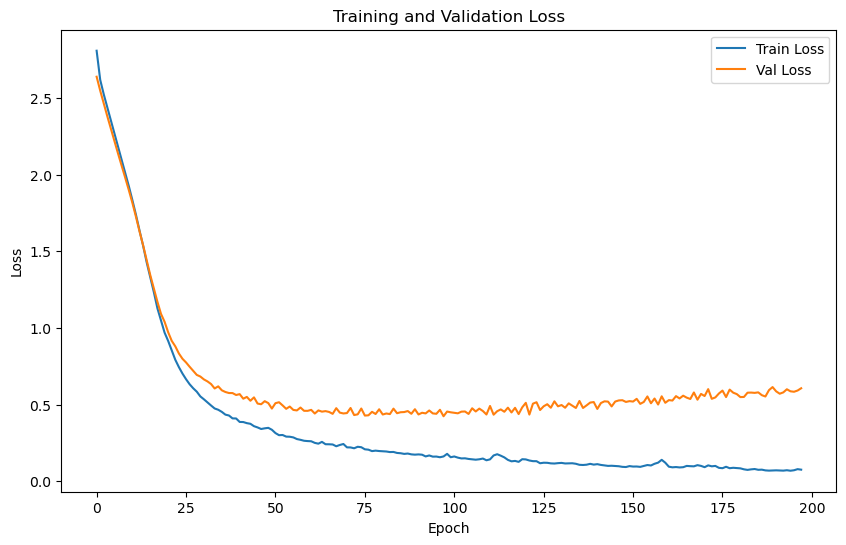

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.6178 | Test Accuracy: 83.63%


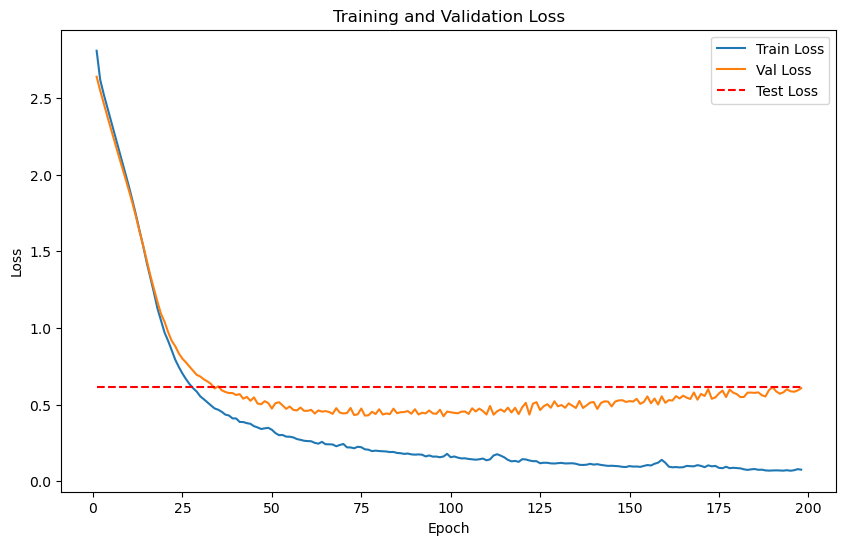

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.3634
Epoch [1/2000], Avg Train Loss: 8.3634
Epoch [1/2000], Avg Val Loss: 3.9853
Validation loss improved from inf to 3.9853. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2648
Epoch [2/2000], Avg Train Loss: 8.2648
Epoch [2/2000], Avg Val Loss: 3.9532
Validation loss improved from 3.9853 to 3.9532. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0385
Epoch [3/2000], Avg Train Loss: 8.0385
Epoch [3/2000], Avg Val Loss: 3.9221
Validation loss improved from 3.9532 to 3.9221. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 8.2457
Epoch [4/2000], Avg Train Loss: 8.2457
Epoch [4/2000], Avg Val Loss: 3.8919
Validation loss improved from 3.9221 to 3.8919. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.0729
Epoch [5/2000], Avg Train Loss: 8.0729
Epoch [5/2000], Avg Val Loss: 3.8625
Validation loss improved from 3.8919 to 3.8625. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.0264
Epoch [6/2000], Avg Train Loss: 8.0264
Epoch [6/2000], Avg Val Loss: 3.8339
Validation loss improved from 3.8625 to 3.8339. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.8178
Epoch [7/2000], Avg Train Loss: 7.8178
Epoch [7/2000], Avg Val Loss: 3.8060
Validation loss improved from 3.8339 to 3.8060. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.7606
Epoch [8/2000], Avg Train Loss: 7.7606
Epoch [8/2000], Avg Val Loss: 3.7789
Validation loss improved from 3.8060 to 3.7789. Saving m

    Batch [1/1], Train Loss: 7.1667
Epoch [18/2000], Avg Train Loss: 7.1667
Epoch [18/2000], Avg Val Loss: 3.5445
Validation loss improved from 3.5652 to 3.5445. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.0952
Epoch [19/2000], Avg Train Loss: 7.0952
Epoch [19/2000], Avg Val Loss: 3.5245
Validation loss improved from 3.5445 to 3.5245. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.0852
Epoch [20/2000], Avg Train Loss: 7.0852
Epoch [20/2000], Avg Val Loss: 3.5052
Validation loss improved from 3.5245 to 3.5052. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.0125
Epoch [21/2000], Avg Train Loss: 7.0125
Epoch [21/2000], Avg Val Loss: 3.4863
Validation loss improved from 3.5052 to 3.4863. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.9485
Epoch [22/2000], Avg Train Loss: 6.9485
Epoch [22/2000], Avg Val Loss: 3.4681
Validation loss improved from 3.4863 to 3.

    Batch [1/1], Train Loss: 7.0941
Epoch [23/2000], Avg Train Loss: 7.0941
Epoch [23/2000], Avg Val Loss: 3.4505
Validation loss improved from 3.4681 to 3.4505. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.9732
Epoch [24/2000], Avg Train Loss: 6.9732
Epoch [24/2000], Avg Val Loss: 3.4336
Validation loss improved from 3.4505 to 3.4336. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7384
Epoch [25/2000], Avg Train Loss: 6.7384
Epoch [25/2000], Avg Val Loss: 3.4171
Validation loss improved from 3.4336 to 3.4171. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.7828
Epoch [26/2000], Avg Train Loss: 6.7828
Epoch [26/2000], Avg Val Loss: 3.4011
Validation loss improved from 3.4171 to 3.4011. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.7840
Epoch [27/2000], Avg Train Loss: 6.7840
Epoch [27/2000], Avg Val Loss: 3.3856
Validation loss improved from 3.4011 to 3.

    Batch [1/1], Train Loss: 6.1263
Epoch [41/2000], Avg Train Loss: 6.1263
Epoch [41/2000], Avg Val Loss: 3.2167
Validation loss improved from 3.2262 to 3.2167. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 6.0782
Epoch [42/2000], Avg Train Loss: 6.0782
Epoch [42/2000], Avg Val Loss: 3.2076
Validation loss improved from 3.2167 to 3.2076. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.1449
Epoch [43/2000], Avg Train Loss: 6.1449
Epoch [43/2000], Avg Val Loss: 3.1989
Validation loss improved from 3.2076 to 3.1989. Saving model...

LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 6.1065
Epoch [44/2000], Avg Train Loss: 6.1065
Epoch [44/2000], Avg Val Loss: 3.1904
Validation loss improved from 3.1989 to 3.1904. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.8862
Epoch [45/2000], Avg Train Loss: 5.8862
Epoch [45/2000], Avg Val Loss: 3.1823
Validation loss improved from 3.1904 to 3.

Epoch [55/2000], Avg Val Loss: 3.1171
Validation loss improved from 3.1226 to 3.1171. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.6075
Epoch [56/2000], Avg Train Loss: 5.6075
Epoch [56/2000], Avg Val Loss: 3.1119
Validation loss improved from 3.1171 to 3.1119. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.5646
Epoch [57/2000], Avg Train Loss: 5.5646
Epoch [57/2000], Avg Val Loss: 3.1068
Validation loss improved from 3.1119 to 3.1068. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.5972
Epoch [58/2000], Avg Train Loss: 5.5972
Epoch [58/2000], Avg Val Loss: 3.1020
Validation loss improved from 3.1068 to 3.1020. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.5500
Epoch [59/2000], Avg Train Loss: 5.5500
Epoch [59/2000], Avg Val Loss: 3.0974
Validation loss improved from 3.1020 to 3.0974. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Trai

Epoch [77/2000], Avg Val Loss: 3.0375
Validation loss improved from 3.0400 to 3.0375. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.2098
Epoch [78/2000], Avg Train Loss: 5.2098
Epoch [78/2000], Avg Val Loss: 3.0352
Validation loss improved from 3.0375 to 3.0352. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.1823
Epoch [79/2000], Avg Train Loss: 5.1823
Epoch [79/2000], Avg Val Loss: 3.0328
Validation loss improved from 3.0352 to 3.0328. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.2587
Epoch [80/2000], Avg Train Loss: 5.2587
Epoch [80/2000], Avg Val Loss: 3.0306
Validation loss improved from 3.0328 to 3.0306. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.3239
Epoch [81/2000], Avg Train Loss: 5.3239
Epoch [81/2000], Avg Val Loss: 3.0284
Validation loss improved from 3.0306 to 3.0284. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1293
Epoch [91/2000], Avg Train Loss: 5.1293
Epoch [91/2000], Avg Val Loss: 3.0086
Validation loss improved from 3.0104 to 3.0086. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0805
Epoch [92/2000], Avg Train Loss: 5.0805
Epoch [92/2000], Avg Val Loss: 3.0069
Validation loss improved from 3.0086 to 3.0069. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.0801
Epoch [93/2000], Avg Train Loss: 5.0801
Epoch [93/2000], Avg Val Loss: 3.0052
Validation loss improved from 3.0069 to 3.0052. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0900
Epoch [94/2000], Avg Train Loss: 5.0900
Epoch [94/2000], Avg Val Loss: 3.0036
Validation loss improved from 3.0052 to 3.0036. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.0987
Epoch [95/2000], Avg Train Loss: 5.0987
Epoch [95/2000], Avg Val Loss: 3.0020
Validation loss improved from 3.0036 to 3.

Epoch [114/2000], Avg Val Loss: 2.9729
Validation loss improved from 2.9744 to 2.9729. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.9619
Epoch [115/2000], Avg Train Loss: 4.9619
Epoch [115/2000], Avg Val Loss: 2.9714
Validation loss improved from 2.9729 to 2.9714. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.9613
Epoch [116/2000], Avg Train Loss: 4.9613
Epoch [116/2000], Avg Val Loss: 2.9699
Validation loss improved from 2.9714 to 2.9699. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.9294
Epoch [117/2000], Avg Train Loss: 4.9294
Epoch [117/2000], Avg Val Loss: 2.9684
Validation loss improved from 2.9699 to 2.9684. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.9437
Epoch [118/2000], Avg Train Loss: 4.9437
Epoch [118/2000], Avg Val Loss: 2.9669
Validation loss improved from 2.9684 to 2.9669. Saving model...

LOG: Epoch [119/2000] - Training
    Bat

Epoch [129/2000], Avg Val Loss: 2.9507
Validation loss improved from 2.9522 to 2.9507. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.8757
Epoch [130/2000], Avg Train Loss: 4.8757
Epoch [130/2000], Avg Val Loss: 2.9491
Validation loss improved from 2.9507 to 2.9491. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.8662
Epoch [131/2000], Avg Train Loss: 4.8662
Epoch [131/2000], Avg Val Loss: 2.9476
Validation loss improved from 2.9491 to 2.9476. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 4.8359
Epoch [132/2000], Avg Train Loss: 4.8359
Epoch [132/2000], Avg Val Loss: 2.9461
Validation loss improved from 2.9476 to 2.9461. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.8386
Epoch [133/2000], Avg Train Loss: 4.8386
Epoch [133/2000], Avg Val Loss: 2.9447
Validation loss improved from 2.9461 to 2.9447. Saving model...

LOG: Epoch [134/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8123
Epoch [151/2000], Avg Train Loss: 4.8123
Epoch [151/2000], Avg Val Loss: 2.9172
Validation loss improved from 2.9187 to 2.9172. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 4.7463
Epoch [152/2000], Avg Train Loss: 4.7463
Epoch [152/2000], Avg Val Loss: 2.9157
Validation loss improved from 2.9172 to 2.9157. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 4.7316
Epoch [153/2000], Avg Train Loss: 4.7316
Epoch [153/2000], Avg Val Loss: 2.9142
Validation loss improved from 2.9157 to 2.9142. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.7241
Epoch [154/2000], Avg Train Loss: 4.7241
Epoch [154/2000], Avg Val Loss: 2.9127
Validation loss improved from 2.9142 to 2.9127. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.7101
Epoch [155/2000], Avg Train Loss: 4.7101
Epoch [155/2000], Avg Val Loss: 2.9112
Validation loss improved fro

Epoch [165/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8979 to 2.8964. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.6470
Epoch [166/2000], Avg Train Loss: 4.6470
Epoch [166/2000], Avg Val Loss: 2.8949
Validation loss improved from 2.8964 to 2.8949. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 4.7277
Epoch [167/2000], Avg Train Loss: 4.7277
Epoch [167/2000], Avg Val Loss: 2.8934
Validation loss improved from 2.8949 to 2.8934. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.6809
Epoch [168/2000], Avg Train Loss: 4.6809
Epoch [168/2000], Avg Val Loss: 2.8918
Validation loss improved from 2.8934 to 2.8918. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.6963
Epoch [169/2000], Avg Train Loss: 4.6963
Epoch [169/2000], Avg Val Loss: 2.8903
Validation loss improved from 2.8918 to 2.8903. Saving model...

LOG: Epoch [170/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6343
Epoch [188/2000], Avg Train Loss: 4.6343
Epoch [188/2000], Avg Val Loss: 2.8613
Validation loss improved from 2.8629 to 2.8613. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.6390
Epoch [189/2000], Avg Train Loss: 4.6390
Epoch [189/2000], Avg Val Loss: 2.8599
Validation loss improved from 2.8613 to 2.8599. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.5784
Epoch [190/2000], Avg Train Loss: 4.5784
Epoch [190/2000], Avg Val Loss: 2.8584
Validation loss improved from 2.8599 to 2.8584. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.6492
Epoch [191/2000], Avg Train Loss: 4.6492
Epoch [191/2000], Avg Val Loss: 2.8569
Validation loss improved from 2.8584 to 2.8569. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.6000
Epoch [192/2000], Avg Train Loss: 4.6000
Epoch [192/2000], Avg Val Loss: 2.8554
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6044
Epoch [199/2000], Avg Train Loss: 4.6044
Epoch [199/2000], Avg Val Loss: 2.8452
Validation loss improved from 2.8466 to 2.8452. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.5536
Epoch [200/2000], Avg Train Loss: 4.5536
Epoch [200/2000], Avg Val Loss: 2.8437
Validation loss improved from 2.8452 to 2.8437. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.6004
Epoch [201/2000], Avg Train Loss: 4.6004
Epoch [201/2000], Avg Val Loss: 2.8423
Validation loss improved from 2.8437 to 2.8423. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.5521
Epoch [202/2000], Avg Train Loss: 4.5521
Epoch [202/2000], Avg Val Loss: 2.8408
Validation loss improved from 2.8423 to 2.8408. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.5599
Epoch [203/2000], Avg Train Loss: 4.5599
Epoch [203/2000], Avg Val Loss: 2.8394
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5554
Epoch [221/2000], Avg Train Loss: 4.5554
Epoch [221/2000], Avg Val Loss: 2.8148
Validation loss improved from 2.8161 to 2.8148. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.5529
Epoch [222/2000], Avg Train Loss: 4.5529
Epoch [222/2000], Avg Val Loss: 2.8134
Validation loss improved from 2.8148 to 2.8134. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.5191
Epoch [223/2000], Avg Train Loss: 4.5191
Epoch [223/2000], Avg Val Loss: 2.8121
Validation loss improved from 2.8134 to 2.8121. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 4.4837
Epoch [224/2000], Avg Train Loss: 4.4837
Epoch [224/2000], Avg Val Loss: 2.8108
Validation loss improved from 2.8121 to 2.8108. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 4.5086
Epoch [225/2000], Avg Train Loss: 4.5086
Epoch [225/2000], Avg Val Loss: 2.8094
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4749
Epoch [235/2000], Avg Train Loss: 4.4749
Epoch [235/2000], Avg Val Loss: 2.7961
Validation loss improved from 2.7974 to 2.7961. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.4662
Epoch [236/2000], Avg Train Loss: 4.4662
Epoch [236/2000], Avg Val Loss: 2.7947
Validation loss improved from 2.7961 to 2.7947. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.4174
Epoch [237/2000], Avg Train Loss: 4.4174
Epoch [237/2000], Avg Val Loss: 2.7933
Validation loss improved from 2.7947 to 2.7933. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.4767
Epoch [238/2000], Avg Train Loss: 4.4767
Epoch [238/2000], Avg Val Loss: 2.7920
Validation loss improved from 2.7933 to 2.7920. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.4616
Epoch [239/2000], Avg Train Loss: 4.4616
Epoch [239/2000], Avg Val Loss: 2.7906
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4394
Epoch [260/2000], Avg Train Loss: 4.4394
Epoch [260/2000], Avg Val Loss: 2.7638
Validation loss improved from 2.7649 to 2.7638. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.4277
Epoch [261/2000], Avg Train Loss: 4.4277
Epoch [261/2000], Avg Val Loss: 2.7627
Validation loss improved from 2.7638 to 2.7627. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.4017
Epoch [262/2000], Avg Train Loss: 4.4017
Epoch [262/2000], Avg Val Loss: 2.7616
Validation loss improved from 2.7627 to 2.7616. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.4155
Epoch [263/2000], Avg Train Loss: 4.4155
Epoch [263/2000], Avg Val Loss: 2.7605
Validation loss improved from 2.7616 to 2.7605. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.4457
Epoch [264/2000], Avg Train Loss: 4.4457
Epoch [264/2000], Avg Val Loss: 2.7594
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3730
Epoch [273/2000], Avg Train Loss: 4.3730
Epoch [273/2000], Avg Val Loss: 2.7492
Validation loss improved from 2.7503 to 2.7492. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.4570
Epoch [274/2000], Avg Train Loss: 4.4570
Epoch [274/2000], Avg Val Loss: 2.7481
Validation loss improved from 2.7492 to 2.7481. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.4025
Epoch [275/2000], Avg Train Loss: 4.4025
Epoch [275/2000], Avg Val Loss: 2.7470
Validation loss improved from 2.7481 to 2.7470. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.3798
Epoch [276/2000], Avg Train Loss: 4.3798
Epoch [276/2000], Avg Val Loss: 2.7459
Validation loss improved from 2.7470 to 2.7459. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.3985
Epoch [277/2000], Avg Train Loss: 4.3985
Epoch [277/2000], Avg Val Loss: 2.7448
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3476
Epoch [298/2000], Avg Train Loss: 4.3476
Epoch [298/2000], Avg Val Loss: 2.7223
Validation loss improved from 2.7233 to 2.7223. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.3324
Epoch [299/2000], Avg Train Loss: 4.3324
Epoch [299/2000], Avg Val Loss: 2.7213
Validation loss improved from 2.7223 to 2.7213. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.3567
Epoch [300/2000], Avg Train Loss: 4.3567
Epoch [300/2000], Avg Val Loss: 2.7202
Validation loss improved from 2.7213 to 2.7202. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.3581
Epoch [301/2000], Avg Train Loss: 4.3581
Epoch [301/2000], Avg Val Loss: 2.7192
Validation loss improved from 2.7202 to 2.7192. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.3379
Epoch [302/2000], Avg Train Loss: 4.3379
Epoch [302/2000], Avg Val Loss: 2.7182
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3302
Epoch [312/2000], Avg Train Loss: 4.3302
Epoch [312/2000], Avg Val Loss: 2.7082
Validation loss improved from 2.7092 to 2.7082. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.2830
Epoch [313/2000], Avg Train Loss: 4.2830
Epoch [313/2000], Avg Val Loss: 2.7073
Validation loss improved from 2.7082 to 2.7073. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.3385
Epoch [314/2000], Avg Train Loss: 4.3385
Epoch [314/2000], Avg Val Loss: 2.7064
Validation loss improved from 2.7073 to 2.7064. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.3364
Epoch [315/2000], Avg Train Loss: 4.3364
Epoch [315/2000], Avg Val Loss: 2.7055
Validation loss improved from 2.7064 to 2.7055. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.2767
Epoch [316/2000], Avg Train Loss: 4.2767
Epoch [316/2000], Avg Val Loss: 2.7046
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2918
Epoch [336/2000], Avg Train Loss: 4.2918
Epoch [336/2000], Avg Val Loss: 2.6869
Validation loss improved from 2.6877 to 2.6869. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.2644
Epoch [337/2000], Avg Train Loss: 4.2644
Epoch [337/2000], Avg Val Loss: 2.6860
Validation loss improved from 2.6869 to 2.6860. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.2976
Epoch [338/2000], Avg Train Loss: 4.2976
Epoch [338/2000], Avg Val Loss: 2.6852
Validation loss improved from 2.6860 to 2.6852. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.2531
Epoch [339/2000], Avg Train Loss: 4.2531
Epoch [339/2000], Avg Val Loss: 2.6844
Validation loss improved from 2.6852 to 2.6844. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.2431
Epoch [340/2000], Avg Train Loss: 4.2431
Epoch [340/2000], Avg Val Loss: 2.6835
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2625
Epoch [350/2000], Avg Train Loss: 4.2625
Epoch [350/2000], Avg Val Loss: 2.6759
Validation loss improved from 2.6766 to 2.6759. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.2307
Epoch [351/2000], Avg Train Loss: 4.2307
Epoch [351/2000], Avg Val Loss: 2.6752
Validation loss improved from 2.6759 to 2.6752. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.2858
Epoch [352/2000], Avg Train Loss: 4.2858
Epoch [352/2000], Avg Val Loss: 2.6745
Validation loss improved from 2.6752 to 2.6745. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 4.3080
Epoch [353/2000], Avg Train Loss: 4.3080
Epoch [353/2000], Avg Val Loss: 2.6738
Validation loss improved from 2.6745 to 2.6738. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 4.2966
Epoch [354/2000], Avg Train Loss: 4.2966
Epoch [354/2000], Avg Val Loss: 2.6731
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2158
Epoch [375/2000], Avg Train Loss: 4.2158
Epoch [375/2000], Avg Val Loss: 2.6587
Validation loss improved from 2.6593 to 2.6587. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.2082
Epoch [376/2000], Avg Train Loss: 4.2082
Epoch [376/2000], Avg Val Loss: 2.6581
Validation loss improved from 2.6587 to 2.6581. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.2389
Epoch [377/2000], Avg Train Loss: 4.2389
Epoch [377/2000], Avg Val Loss: 2.6574
Validation loss improved from 2.6581 to 2.6574. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.2065
Epoch [378/2000], Avg Train Loss: 4.2065
Epoch [378/2000], Avg Val Loss: 2.6568
Validation loss improved from 2.6574 to 2.6568. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.1679
Epoch [379/2000], Avg Train Loss: 4.1679
Epoch [379/2000], Avg Val Loss: 2.6561
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2484
Epoch [386/2000], Avg Train Loss: 4.2484
Epoch [386/2000], Avg Val Loss: 2.6515
Validation loss improved from 2.6522 to 2.6515. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.2341
Epoch [387/2000], Avg Train Loss: 4.2341
Epoch [387/2000], Avg Val Loss: 2.6509
Validation loss improved from 2.6515 to 2.6509. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.2255
Epoch [388/2000], Avg Train Loss: 4.2255
Epoch [388/2000], Avg Val Loss: 2.6503
Validation loss improved from 2.6509 to 2.6503. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 4.1773
Epoch [389/2000], Avg Train Loss: 4.1773
Epoch [389/2000], Avg Val Loss: 2.6496
Validation loss improved from 2.6503 to 2.6496. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.1740
Epoch [390/2000], Avg Train Loss: 4.1740
Epoch [390/2000], Avg Val Loss: 2.6489
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1771
Epoch [413/2000], Avg Train Loss: 4.1771
Epoch [413/2000], Avg Val Loss: 2.6356
Validation loss improved from 2.6361 to 2.6356. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.1483
Epoch [414/2000], Avg Train Loss: 4.1483
Epoch [414/2000], Avg Val Loss: 2.6350
Validation loss improved from 2.6356 to 2.6350. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.1641
Epoch [415/2000], Avg Train Loss: 4.1641
Epoch [415/2000], Avg Val Loss: 2.6345
Validation loss improved from 2.6350 to 2.6345. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.1846
Epoch [416/2000], Avg Train Loss: 4.1846
Epoch [416/2000], Avg Val Loss: 2.6340
Validation loss improved from 2.6345 to 2.6340. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.1604
Epoch [417/2000], Avg Train Loss: 4.1604
Epoch [417/2000], Avg Val Loss: 2.6334
Validation loss improved fro

Epoch [421/2000], Avg Val Loss: 2.6313
Validation loss improved from 2.6319 to 2.6313. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 4.1564
Epoch [422/2000], Avg Train Loss: 4.1564
Epoch [422/2000], Avg Val Loss: 2.6308
Validation loss improved from 2.6313 to 2.6308. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.1410
Epoch [423/2000], Avg Train Loss: 4.1410
Epoch [423/2000], Avg Val Loss: 2.6302
Validation loss improved from 2.6308 to 2.6302. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.1747
Epoch [424/2000], Avg Train Loss: 4.1747
Epoch [424/2000], Avg Val Loss: 2.6297
Validation loss improved from 2.6302 to 2.6297. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.1730
Epoch [425/2000], Avg Train Loss: 4.1730
Epoch [425/2000], Avg Val Loss: 2.6291
Validation loss improved from 2.6297 to 2.6291. Saving model...

LOG: Epoch [426/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1459
Epoch [449/2000], Avg Train Loss: 4.1459
Epoch [449/2000], Avg Val Loss: 2.6165
Validation loss improved from 2.6170 to 2.6165. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.1087
Epoch [450/2000], Avg Train Loss: 4.1087
Epoch [450/2000], Avg Val Loss: 2.6160
Validation loss improved from 2.6165 to 2.6160. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.1049
Epoch [451/2000], Avg Train Loss: 4.1049
Epoch [451/2000], Avg Val Loss: 2.6155
Validation loss improved from 2.6160 to 2.6155. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.1113
Epoch [452/2000], Avg Train Loss: 4.1113
Epoch [452/2000], Avg Val Loss: 2.6150
Validation loss improved from 2.6155 to 2.6150. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.1644
Epoch [453/2000], Avg Train Loss: 4.1644
Epoch [453/2000], Avg Val Loss: 2.6145
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1000
Epoch [459/2000], Avg Train Loss: 4.1000
Epoch [459/2000], Avg Val Loss: 2.6118
Validation loss improved from 2.6123 to 2.6118. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.0935
Epoch [460/2000], Avg Train Loss: 4.0935
Epoch [460/2000], Avg Val Loss: 2.6114
Validation loss improved from 2.6118 to 2.6114. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.1239
Epoch [461/2000], Avg Train Loss: 4.1239
Epoch [461/2000], Avg Val Loss: 2.6110
Validation loss improved from 2.6114 to 2.6110. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.1278
Epoch [462/2000], Avg Train Loss: 4.1278
Epoch [462/2000], Avg Val Loss: 2.6106
Validation loss improved from 2.6110 to 2.6106. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.1232
Epoch [463/2000], Avg Train Loss: 4.1232
Epoch [463/2000], Avg Val Loss: 2.6102
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0909
Epoch [487/2000], Avg Train Loss: 4.0909
Epoch [487/2000], Avg Val Loss: 2.5999
Validation loss improved from 2.6003 to 2.5999. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.0815
Epoch [488/2000], Avg Train Loss: 4.0815
Epoch [488/2000], Avg Val Loss: 2.5994
Validation loss improved from 2.5999 to 2.5994. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.0881
Epoch [489/2000], Avg Train Loss: 4.0881
Epoch [489/2000], Avg Val Loss: 2.5990
Validation loss improved from 2.5994 to 2.5990. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.1259
Epoch [490/2000], Avg Train Loss: 4.1259
Epoch [490/2000], Avg Val Loss: 2.5985
Validation loss improved from 2.5990 to 2.5985. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.1187
Epoch [491/2000], Avg Train Loss: 4.1187
Epoch [491/2000], Avg Val Loss: 2.5981
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0585
Epoch [497/2000], Avg Train Loss: 4.0585
Epoch [497/2000], Avg Val Loss: 2.5954
Validation loss improved from 2.5958 to 2.5954. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.0474
Epoch [498/2000], Avg Train Loss: 4.0474
Epoch [498/2000], Avg Val Loss: 2.5950
Validation loss improved from 2.5954 to 2.5950. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.0654
Epoch [499/2000], Avg Train Loss: 4.0654
Epoch [499/2000], Avg Val Loss: 2.5945
Validation loss improved from 2.5950 to 2.5945. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.0538
Epoch [500/2000], Avg Train Loss: 4.0538
Epoch [500/2000], Avg Val Loss: 2.5941
Validation loss improved from 2.5945 to 2.5941. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 4.0632
Epoch [501/2000], Avg Train Loss: 4.0632
Epoch [501/2000], Avg Val Loss: 2.5937
Validation loss improved fro

Epoch [523/2000], Avg Val Loss: 2.5858
Validation loss improved from 2.5862 to 2.5858. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.0405
Epoch [524/2000], Avg Train Loss: 4.0405
Epoch [524/2000], Avg Val Loss: 2.5854
Validation loss improved from 2.5858 to 2.5854. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.0692
Epoch [525/2000], Avg Train Loss: 4.0692
Epoch [525/2000], Avg Val Loss: 2.5851
Validation loss improved from 2.5854 to 2.5851. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.0375
Epoch [526/2000], Avg Train Loss: 4.0375
Epoch [526/2000], Avg Val Loss: 2.5847
Validation loss improved from 2.5851 to 2.5847. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.0709
Epoch [527/2000], Avg Train Loss: 4.0709
Epoch [527/2000], Avg Val Loss: 2.5843
Validation loss improved from 2.5847 to 2.5843. Saving model...

LOG: Epoch [528/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0769
Epoch [534/2000], Avg Train Loss: 4.0769
Epoch [534/2000], Avg Val Loss: 2.5818
Validation loss improved from 2.5821 to 2.5818. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.0532
Epoch [535/2000], Avg Train Loss: 4.0532
Epoch [535/2000], Avg Val Loss: 2.5815
Validation loss improved from 2.5818 to 2.5815. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 4.0438
Epoch [536/2000], Avg Train Loss: 4.0438
Epoch [536/2000], Avg Val Loss: 2.5812
Validation loss improved from 2.5815 to 2.5812. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 4.0799
Epoch [537/2000], Avg Train Loss: 4.0799
Epoch [537/2000], Avg Val Loss: 2.5810
Validation loss improved from 2.5812 to 2.5810. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.0345
Epoch [538/2000], Avg Train Loss: 4.0345
Epoch [538/2000], Avg Val Loss: 2.5807
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0048
Epoch [560/2000], Avg Train Loss: 4.0048
Epoch [560/2000], Avg Val Loss: 2.5730
Validation loss improved from 2.5733 to 2.5730. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.0386
Epoch [561/2000], Avg Train Loss: 4.0386
Epoch [561/2000], Avg Val Loss: 2.5727
Validation loss improved from 2.5730 to 2.5727. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.9952
Epoch [562/2000], Avg Train Loss: 3.9952
Epoch [562/2000], Avg Val Loss: 2.5724
Validation loss improved from 2.5727 to 2.5724. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.0069
Epoch [563/2000], Avg Train Loss: 4.0069
Epoch [563/2000], Avg Val Loss: 2.5720
Validation loss improved from 2.5724 to 2.5720. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.0132
Epoch [564/2000], Avg Train Loss: 4.0132
Epoch [564/2000], Avg Val Loss: 2.5717
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9910
Epoch [571/2000], Avg Train Loss: 3.9910
Epoch [571/2000], Avg Val Loss: 2.5691
Validation loss improved from 2.5695 to 2.5691. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.0109
Epoch [572/2000], Avg Train Loss: 4.0109
Epoch [572/2000], Avg Val Loss: 2.5687
Validation loss improved from 2.5691 to 2.5687. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 4.0082
Epoch [573/2000], Avg Train Loss: 4.0082
Epoch [573/2000], Avg Val Loss: 2.5683
Validation loss improved from 2.5687 to 2.5683. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 4.0449
Epoch [574/2000], Avg Train Loss: 4.0449
Epoch [574/2000], Avg Val Loss: 2.5679
Validation loss improved from 2.5683 to 2.5679. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 3.9932
Epoch [575/2000], Avg Train Loss: 3.9932
Epoch [575/2000], Avg Val Loss: 2.5675
Validation loss improved fro

Epoch [597/2000], Avg Val Loss: 2.5603
Validation loss improved from 2.5606 to 2.5603. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 3.9851
Epoch [598/2000], Avg Train Loss: 3.9851
Epoch [598/2000], Avg Val Loss: 2.5599
Validation loss improved from 2.5603 to 2.5599. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 3.9981
Epoch [599/2000], Avg Train Loss: 3.9981
Epoch [599/2000], Avg Val Loss: 2.5596
Validation loss improved from 2.5599 to 2.5596. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 3.9676
Epoch [600/2000], Avg Train Loss: 3.9676
Epoch [600/2000], Avg Val Loss: 2.5594
Validation loss improved from 2.5596 to 2.5594. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 3.9660
Epoch [601/2000], Avg Train Loss: 3.9660
Epoch [601/2000], Avg Val Loss: 2.5591
Validation loss improved from 2.5594 to 2.5591. Saving model...

LOG: Epoch [602/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9982
Epoch [608/2000], Avg Train Loss: 3.9982
Epoch [608/2000], Avg Val Loss: 2.5574
Validation loss improved from 2.5576 to 2.5574. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.9939
Epoch [609/2000], Avg Train Loss: 3.9939
Epoch [609/2000], Avg Val Loss: 2.5572
Validation loss improved from 2.5574 to 2.5572. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.9851
Epoch [610/2000], Avg Train Loss: 3.9851
Epoch [610/2000], Avg Val Loss: 2.5569
Validation loss improved from 2.5572 to 2.5569. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.0222
Epoch [611/2000], Avg Train Loss: 4.0222
Epoch [611/2000], Avg Val Loss: 2.5566
Validation loss improved from 2.5569 to 2.5566. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.9515
Epoch [612/2000], Avg Train Loss: 3.9515
Epoch [612/2000], Avg Val Loss: 2.5564
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9657
Epoch [635/2000], Avg Train Loss: 3.9657
Epoch [635/2000], Avg Val Loss: 2.5501
Validation loss improved from 2.5504 to 2.5501. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 3.9621
Epoch [636/2000], Avg Train Loss: 3.9621
Epoch [636/2000], Avg Val Loss: 2.5498
Validation loss improved from 2.5501 to 2.5498. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 3.9634
Epoch [637/2000], Avg Train Loss: 3.9634
Epoch [637/2000], Avg Val Loss: 2.5495
Validation loss improved from 2.5498 to 2.5495. Saving model...

LOG: Epoch [638/2000] - Training
    Batch [1/1], Train Loss: 3.9477
Epoch [638/2000], Avg Train Loss: 3.9477
Epoch [638/2000], Avg Val Loss: 2.5493
Validation loss improved from 2.5495 to 2.5493. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 3.9587
Epoch [639/2000], Avg Train Loss: 3.9587
Epoch [639/2000], Avg Val Loss: 2.5490
Validation loss improved fro

Epoch [646/2000], Avg Val Loss: 2.5470
Validation loss improved from 2.5473 to 2.5470. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 3.9577
Epoch [647/2000], Avg Train Loss: 3.9577
Epoch [647/2000], Avg Val Loss: 2.5467
Validation loss improved from 2.5470 to 2.5467. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 3.9504
Epoch [648/2000], Avg Train Loss: 3.9504
Epoch [648/2000], Avg Val Loss: 2.5464
Validation loss improved from 2.5467 to 2.5464. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 3.9445
Epoch [649/2000], Avg Train Loss: 3.9445
Epoch [649/2000], Avg Val Loss: 2.5461
Validation loss improved from 2.5464 to 2.5461. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.9419
Epoch [650/2000], Avg Train Loss: 3.9419
Epoch [650/2000], Avg Val Loss: 2.5458
Validation loss improved from 2.5461 to 2.5458. Saving model...

LOG: Epoch [651/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9347
Epoch [672/2000], Avg Train Loss: 3.9347
Epoch [672/2000], Avg Val Loss: 2.5399
Validation loss improved from 2.5402 to 2.5399. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.9090
Epoch [673/2000], Avg Train Loss: 3.9090
Epoch [673/2000], Avg Val Loss: 2.5395
Validation loss improved from 2.5399 to 2.5395. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.9144
Epoch [674/2000], Avg Train Loss: 3.9144
Epoch [674/2000], Avg Val Loss: 2.5391
Validation loss improved from 2.5395 to 2.5391. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.9201
Epoch [675/2000], Avg Train Loss: 3.9201
Epoch [675/2000], Avg Val Loss: 2.5387
Validation loss improved from 2.5391 to 2.5387. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.9208
Epoch [676/2000], Avg Train Loss: 3.9208
Epoch [676/2000], Avg Val Loss: 2.5384
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8843
Epoch [680/2000], Avg Train Loss: 3.8843
Epoch [680/2000], Avg Val Loss: 2.5371
Validation loss improved from 2.5374 to 2.5371. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 3.9111
Epoch [681/2000], Avg Train Loss: 3.9111
Epoch [681/2000], Avg Val Loss: 2.5367
Validation loss improved from 2.5371 to 2.5367. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 3.8907
Epoch [682/2000], Avg Train Loss: 3.8907
Epoch [682/2000], Avg Val Loss: 2.5363
Validation loss improved from 2.5367 to 2.5363. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 3.9152
Epoch [683/2000], Avg Train Loss: 3.9152
Epoch [683/2000], Avg Val Loss: 2.5359
Validation loss improved from 2.5363 to 2.5359. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 3.8889
Epoch [684/2000], Avg Train Loss: 3.8889
Epoch [684/2000], Avg Val Loss: 2.5356
Validation loss improved fro

Epoch [709/2000], Avg Val Loss: 2.5255
Validation loss improved from 2.5258 to 2.5255. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 3.8770
Epoch [710/2000], Avg Train Loss: 3.8770
Epoch [710/2000], Avg Val Loss: 2.5252
Validation loss improved from 2.5255 to 2.5252. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 3.8895
Epoch [711/2000], Avg Train Loss: 3.8895
Epoch [711/2000], Avg Val Loss: 2.5249
Validation loss improved from 2.5252 to 2.5249. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 3.8923
Epoch [712/2000], Avg Train Loss: 3.8923
Epoch [712/2000], Avg Val Loss: 2.5246
Validation loss improved from 2.5249 to 2.5246. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.8793
Epoch [713/2000], Avg Train Loss: 3.8793
Epoch [713/2000], Avg Val Loss: 2.5244
Validation loss improved from 2.5246 to 2.5244. Saving model...

LOG: Epoch [714/2000] - Training
    Bat

Epoch [716/2000], Avg Val Loss: 2.5235
Validation loss improved from 2.5237 to 2.5235. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.8641
Epoch [717/2000], Avg Train Loss: 3.8641
Epoch [717/2000], Avg Val Loss: 2.5231
Validation loss improved from 2.5235 to 2.5231. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.8820
Epoch [718/2000], Avg Train Loss: 3.8820
Epoch [718/2000], Avg Val Loss: 2.5228
Validation loss improved from 2.5231 to 2.5228. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.8525
Epoch [719/2000], Avg Train Loss: 3.8525
Epoch [719/2000], Avg Val Loss: 2.5225
Validation loss improved from 2.5228 to 2.5225. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.8974
Epoch [720/2000], Avg Train Loss: 3.8974
Epoch [720/2000], Avg Val Loss: 2.5221
Validation loss improved from 2.5225 to 2.5221. Saving model...

LOG: Epoch [721/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8781
Epoch [745/2000], Avg Train Loss: 3.8781
Epoch [745/2000], Avg Val Loss: 2.5181
Validation loss improved from 2.5182 to 2.5181. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.8807
Epoch [746/2000], Avg Train Loss: 3.8807
Epoch [746/2000], Avg Val Loss: 2.5181
Validation loss improved from 2.5181 to 2.5181. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.8983
Epoch [747/2000], Avg Train Loss: 3.8983
Epoch [747/2000], Avg Val Loss: 2.5180
Validation loss improved from 2.5181 to 2.5180. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 3.8667
Epoch [748/2000], Avg Train Loss: 3.8667
Epoch [748/2000], Avg Val Loss: 2.5180
Validation loss improved from 2.5180 to 2.5180. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 3.8679
Epoch [749/2000], Avg Train Loss: 3.8679
Epoch [749/2000], Avg Val Loss: 2.5179
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8682
Epoch [753/2000], Avg Train Loss: 3.8682
Epoch [753/2000], Avg Val Loss: 2.5174
Validation loss improved from 2.5175 to 2.5174. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.8548
Epoch [754/2000], Avg Train Loss: 3.8548
Epoch [754/2000], Avg Val Loss: 2.5172
Validation loss improved from 2.5174 to 2.5172. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.8761
Epoch [755/2000], Avg Train Loss: 3.8761
Epoch [755/2000], Avg Val Loss: 2.5171
Validation loss improved from 2.5172 to 2.5171. Saving model...

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.8456
Epoch [756/2000], Avg Train Loss: 3.8456
Epoch [756/2000], Avg Val Loss: 2.5170
Validation loss improved from 2.5171 to 2.5170. Saving model...

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.8623
Epoch [757/2000], Avg Train Loss: 3.8623
Epoch [757/2000], Avg Val Loss: 2.5167
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8379
Epoch [778/2000], Avg Train Loss: 3.8379
Epoch [778/2000], Avg Val Loss: 2.5114
Validation loss improved from 2.5116 to 2.5114. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.8547
Epoch [779/2000], Avg Train Loss: 3.8547
Epoch [779/2000], Avg Val Loss: 2.5112
Validation loss improved from 2.5114 to 2.5112. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.8458
Epoch [780/2000], Avg Train Loss: 3.8458
Epoch [780/2000], Avg Val Loss: 2.5109
Validation loss improved from 2.5112 to 2.5109. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.8738
Epoch [781/2000], Avg Train Loss: 3.8738
Epoch [781/2000], Avg Val Loss: 2.5107
Validation loss improved from 2.5109 to 2.5107. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 3.8269
Epoch [782/2000], Avg Train Loss: 3.8269
Epoch [782/2000], Avg Val Loss: 2.5105
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8290
Epoch [788/2000], Avg Train Loss: 3.8290
Epoch [788/2000], Avg Val Loss: 2.5100
Validation loss improved from 2.5101 to 2.5100. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.8318
Epoch [789/2000], Avg Train Loss: 3.8318
Epoch [789/2000], Avg Val Loss: 2.5100
Validation loss did not improve. Patience: 1/100

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.8495
Epoch [790/2000], Avg Train Loss: 3.8495
Epoch [790/2000], Avg Val Loss: 2.5099
Validation loss improved from 2.5100 to 2.5099. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.8186
Epoch [791/2000], Avg Train Loss: 3.8186
Epoch [791/2000], Avg Val Loss: 2.5098
Validation loss improved from 2.5099 to 2.5098. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.8181
Epoch [792/2000], Avg Train Loss: 3.8181
Epoch [792/2000], Avg Val Loss: 2.5095
Validation loss improved from 2.5098 to 2.5

    Batch [1/1], Train Loss: 3.8157
Epoch [814/2000], Avg Train Loss: 3.8157
Epoch [814/2000], Avg Val Loss: 2.5063
Validation loss did not improve. Patience: 3/100

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.8218
Epoch [815/2000], Avg Train Loss: 3.8218
Epoch [815/2000], Avg Val Loss: 2.5063
Validation loss did not improve. Patience: 4/100

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8041
Epoch [816/2000], Avg Train Loss: 3.8041
Epoch [816/2000], Avg Val Loss: 2.5064
Validation loss did not improve. Patience: 5/100

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.8267
Epoch [817/2000], Avg Train Loss: 3.8267
Epoch [817/2000], Avg Val Loss: 2.5065
Validation loss did not improve. Patience: 6/100

LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 3.8403
Epoch [818/2000], Avg Train Loss: 3.8403
Epoch [818/2000], Avg Val Loss: 2.5064
Validation loss did not improve. Patience: 7/100

LOG: Epoch [819/2000] - Training
    B

    Batch [1/1], Train Loss: 3.8104
Epoch [822/2000], Avg Train Loss: 3.8104
Epoch [822/2000], Avg Val Loss: 2.5061
Validation loss improved from 2.5062 to 2.5061. Saving model...

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 3.8198
Epoch [823/2000], Avg Train Loss: 3.8198
Epoch [823/2000], Avg Val Loss: 2.5059
Validation loss improved from 2.5061 to 2.5059. Saving model...

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 3.8148
Epoch [824/2000], Avg Train Loss: 3.8148
Epoch [824/2000], Avg Val Loss: 2.5057
Validation loss improved from 2.5059 to 2.5057. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 3.8226
Epoch [825/2000], Avg Train Loss: 3.8226
Epoch [825/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5057 to 2.5054. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.8335
Epoch [826/2000], Avg Train Loss: 3.8335
Epoch [826/2000], Avg Val Loss: 2.5051
Validation loss improved fro

Epoch [851/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 11/100

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.7830
Epoch [852/2000], Avg Train Loss: 3.7830
Epoch [852/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 12/100

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.7674
Epoch [853/2000], Avg Train Loss: 3.7674
Epoch [853/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 13/100

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.8191
Epoch [854/2000], Avg Train Loss: 3.8191
Epoch [854/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 14/100

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.7907
Epoch [855/2000], Avg Train Loss: 3.7907
Epoch [855/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 15/100

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.7740
Epoch [856/2000], Avg Train Loss: 3.7740


    Batch [1/1], Train Loss: 3.8094
Epoch [862/2000], Avg Train Loss: 3.8094
Epoch [862/2000], Avg Val Loss: 2.5026
Validation loss did not improve. Patience: 22/100

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 3.8121
Epoch [863/2000], Avg Train Loss: 3.8121
Epoch [863/2000], Avg Val Loss: 2.5025
Validation loss did not improve. Patience: 23/100

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 3.7915
Epoch [864/2000], Avg Train Loss: 3.7915
Epoch [864/2000], Avg Val Loss: 2.5025
Validation loss did not improve. Patience: 24/100

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 3.7924
Epoch [865/2000], Avg Train Loss: 3.7924
Epoch [865/2000], Avg Val Loss: 2.5024
Validation loss did not improve. Patience: 25/100

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 3.7921
Epoch [866/2000], Avg Train Loss: 3.7921
Epoch [866/2000], Avg Val Loss: 2.5022
Validation loss did not improve. Patience: 26/100

LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 3.7777
Epoch [885/2000], Avg Train Loss: 3.7777
Epoch [885/2000], Avg Val Loss: 2.4983
Validation loss improved from 2.4984 to 2.4983. Saving model...

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.7779
Epoch [886/2000], Avg Train Loss: 3.7779
Epoch [886/2000], Avg Val Loss: 2.4983
Validation loss did not improve. Patience: 1/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.7673
Epoch [887/2000], Avg Train Loss: 3.7673
Epoch [887/2000], Avg Val Loss: 2.4983
Validation loss did not improve. Patience: 2/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.7309
Epoch [888/2000], Avg Train Loss: 3.7309
Epoch [888/2000], Avg Val Loss: 2.4984
Validation loss did not improve. Patience: 3/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.8020
Epoch [889/2000], Avg Train Loss: 3.8020
Epoch [889/2000], Avg Val Loss: 2.4984
Validation loss did not improve. Patience: 4/100

LOG: Epoch [890/2000] -

    Batch [1/1], Train Loss: 3.7961
Epoch [899/2000], Avg Train Loss: 3.7961
Epoch [899/2000], Avg Val Loss: 2.4989
Validation loss did not improve. Patience: 14/100

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.7717
Epoch [900/2000], Avg Train Loss: 3.7717
Epoch [900/2000], Avg Val Loss: 2.4989
Validation loss did not improve. Patience: 15/100

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.8194
Epoch [901/2000], Avg Train Loss: 3.8194
Epoch [901/2000], Avg Val Loss: 2.4988
Validation loss did not improve. Patience: 16/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.8009
Epoch [902/2000], Avg Train Loss: 3.8009
Epoch [902/2000], Avg Val Loss: 2.4986
Validation loss did not improve. Patience: 17/100

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 3.7512
Epoch [903/2000], Avg Train Loss: 3.7512
Epoch [903/2000], Avg Val Loss: 2.4984
Validation loss did not improve. Patience: 18/100

LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 3.7443
Epoch [926/2000], Avg Train Loss: 3.7443
Epoch [926/2000], Avg Val Loss: 2.5000
Validation loss did not improve. Patience: 14/100

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.7604
Epoch [927/2000], Avg Train Loss: 3.7604
Epoch [927/2000], Avg Val Loss: 2.5001
Validation loss did not improve. Patience: 15/100

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.7735
Epoch [928/2000], Avg Train Loss: 3.7735
Epoch [928/2000], Avg Val Loss: 2.5002
Validation loss did not improve. Patience: 16/100

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.7440
Epoch [929/2000], Avg Train Loss: 3.7440
Epoch [929/2000], Avg Val Loss: 2.5003
Validation loss did not improve. Patience: 17/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 3.7238
Epoch [930/2000], Avg Train Loss: 3.7238
Epoch [930/2000], Avg Val Loss: 2.5004
Validation loss did not improve. Patience: 18/100

LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 3.7640
Epoch [936/2000], Avg Train Loss: 3.7640
Epoch [936/2000], Avg Val Loss: 2.5009
Validation loss did not improve. Patience: 24/100

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.7515
Epoch [937/2000], Avg Train Loss: 3.7515
Epoch [937/2000], Avg Val Loss: 2.5009
Validation loss did not improve. Patience: 25/100

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 3.7681
Epoch [938/2000], Avg Train Loss: 3.7681
Epoch [938/2000], Avg Val Loss: 2.5009
Validation loss did not improve. Patience: 26/100

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 3.7752
Epoch [939/2000], Avg Train Loss: 3.7752
Epoch [939/2000], Avg Val Loss: 2.5010
Validation loss did not improve. Patience: 27/100

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 3.7623
Epoch [940/2000], Avg Train Loss: 3.7623
Epoch [940/2000], Avg Val Loss: 2.5010
Validation loss did not improve. Patience: 28/100

LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 3.7096
Epoch [964/2000], Avg Train Loss: 3.7096
Epoch [964/2000], Avg Val Loss: 2.5029
Validation loss did not improve. Patience: 52/100

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 3.7378
Epoch [965/2000], Avg Train Loss: 3.7378
Epoch [965/2000], Avg Val Loss: 2.5031
Validation loss did not improve. Patience: 53/100

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 3.7506
Epoch [966/2000], Avg Train Loss: 3.7506
Epoch [966/2000], Avg Val Loss: 2.5034
Validation loss did not improve. Patience: 54/100

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 3.7214
Epoch [967/2000], Avg Train Loss: 3.7214
Epoch [967/2000], Avg Val Loss: 2.5036
Validation loss did not improve. Patience: 55/100

LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 3.7691
Epoch [968/2000], Avg Train Loss: 3.7691
Epoch [968/2000], Avg Val Loss: 2.5038
Validation loss did not improve. Patience: 56/100

LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 3.7165
Epoch [972/2000], Avg Train Loss: 3.7165
Epoch [972/2000], Avg Val Loss: 2.5043
Validation loss did not improve. Patience: 60/100

LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 3.7209
Epoch [973/2000], Avg Train Loss: 3.7209
Epoch [973/2000], Avg Val Loss: 2.5045
Validation loss did not improve. Patience: 61/100

LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 3.7530
Epoch [974/2000], Avg Train Loss: 3.7530
Epoch [974/2000], Avg Val Loss: 2.5049
Validation loss did not improve. Patience: 62/100

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 3.7502
Epoch [975/2000], Avg Train Loss: 3.7502
Epoch [975/2000], Avg Val Loss: 2.5050
Validation loss did not improve. Patience: 63/100

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.7282
Epoch [976/2000], Avg Train Loss: 3.7282
Epoch [976/2000], Avg Val Loss: 2.5051
Validation loss did not improve. Patience: 64/100

LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 3.7243
Epoch [1002/2000], Avg Train Loss: 3.7243
Epoch [1002/2000], Avg Val Loss: 2.5050
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 3.6964
Epoch [1003/2000], Avg Train Loss: 3.6964
Epoch [1003/2000], Avg Val Loss: 2.5050
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 3.7141
Epoch [1004/2000], Avg Train Loss: 3.7141
Epoch [1004/2000], Avg Val Loss: 2.5050
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 3.6994
Epoch [1005/2000], Avg Train Loss: 3.6994
Epoch [1005/2000], Avg Val Loss: 2.5052
Validation loss did not improve. Patience: 93/100

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 3.6812
Epoch [1006/2000], Avg Train Loss: 3.6812
Epoch [1006/2000], Avg Val Loss: 2.5053
Validation loss did not improve. Patience: 94/100

LOG: Epoch [1007/20

Epoch [1009/2000], Avg Val Loss: 2.5057
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 3.7089
Epoch [1010/2000], Avg Train Loss: 3.7089
Epoch [1010/2000], Avg Val Loss: 2.5060
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 3.7050
Epoch [1011/2000], Avg Train Loss: 3.7050
Epoch [1011/2000], Avg Val Loss: 2.5062
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.7106
Epoch [1012/2000], Avg Train Loss: 3.7106
Epoch [1012/2000], Avg Val Loss: 2.5064
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1012. No improvement for 100 epochs.


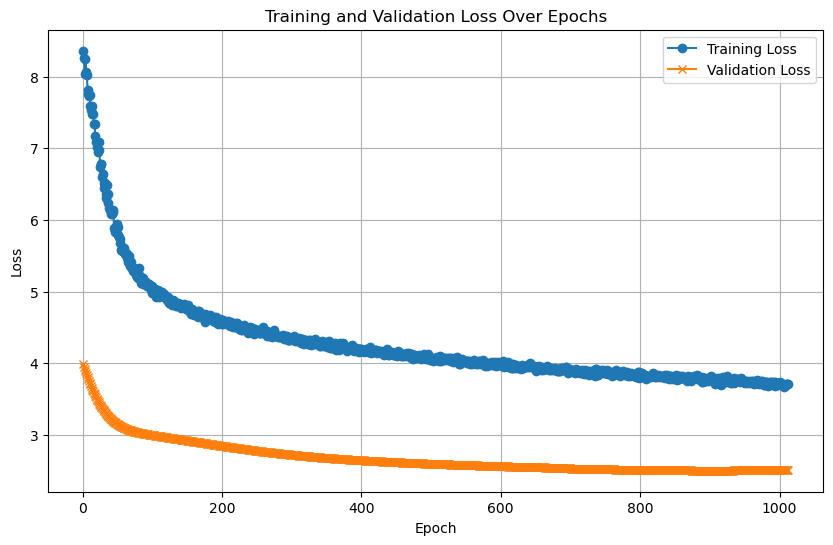

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/210], Loss: 4.1718
Test Batch [20/210], Loss: 4.0551
Test Batch [30/210], Loss: 3.8402


Test Batch [40/210], Loss: 3.9476
Test Batch [50/210], Loss: 4.8278
Test Batch [60/210], Loss: 5.0463


Test Batch [70/210], Loss: 5.0828
Test Batch [80/210], Loss: 4.8366
Test Batch [90/210], Loss: 4.5908
Test Batch [100/210], Loss: 4.5786
Test Batch [110/210], Loss: 4.4855
Test Batch [120/210], Loss: 4.3197
Test Batch [130/210], Loss: 4.5772
Test Batch [140/210], Loss: 4.5475
Test Batch [150/210], Loss: 4.5332


Test Batch [160/210], Loss: 4.7189
Test Batch [170/210], Loss: 4.5475
Test Batch [180/210], Loss: 4.6703


Test Batch [190/210], Loss: 4.3297
Test Batch [200/210], Loss: 4.7850
Test Batch [210/210], Loss: 4.1868

Test Loss: 4.5357


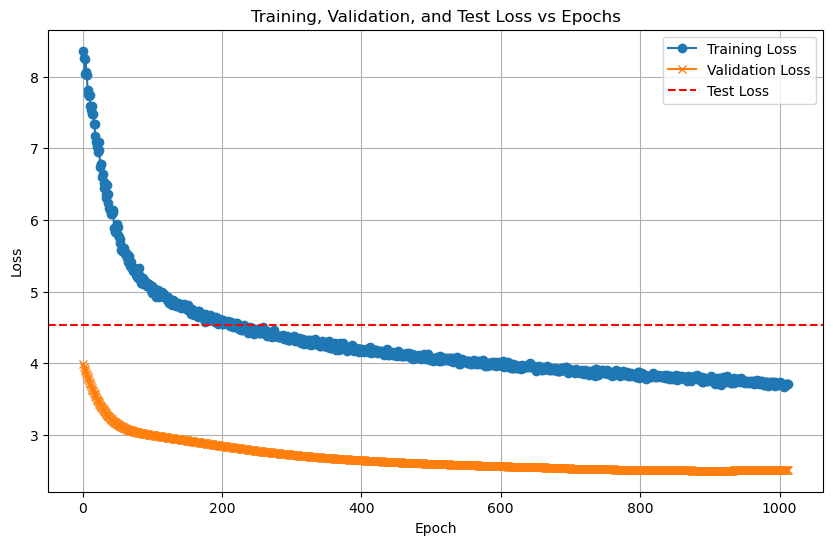

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.


  Processed batch 20/210 for test dataset.


  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.
  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.


  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.


  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.56      1.00      0.71         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       0.83      1.00      0.91         5
           9       0.75      0.60      0.67         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       0.8

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8070  |  Val Loss: 2.7999
Validation loss improved from inf to 2.7999.
[Epoch 2/1000] Train Loss: 2.7826  |  Val Loss: 2.7787
Validation loss improved from 2.7999 to 2.7787.
[Epoch 3/1000] Train Loss: 2.7605  |  Val Loss: 2.7586
Validation loss improved from 2.7787 to 2.7586.
[Epoch 4/1000] Train Loss: 2.7403  |  Val Loss: 2.7385
Validation loss improved from 2.7586 to 2.7385.
[Epoch 5/1000] Train Loss: 2.7192  |  Val Loss: 2.7192
Validation loss improved from 2.7385 to 2.7192.
[Epoch 6/1000] Train Loss: 2.6993  |  Val Loss: 2.7001
Validation loss improved from 2.7192 to 2.7001.
[Epoch 7/1000] Train Loss: 2.6798  |  Val Loss: 2.6816
Validation loss improved from 2.7001 to 2.6816.
[Epoch 8/1000] Train Loss: 2.6608  |  Val Loss: 2.6645
Validation loss improved from 2.6816 to 2.6645.
[Epoch 9/1000] Train Loss: 2.6435  |  Val Loss: 2.6483
Validation loss improved from 2.6645 to 2.6483.
[Epoch 10/1000] Train Loss: 2.6267  |  Val Loss: 2.6325
Validation loss impr

[Epoch 18/1000] Train Loss: 2.5030  |  Val Loss: 2.5144
Validation loss improved from 2.5289 to 2.5144.


[Epoch 19/1000] Train Loss: 2.4875  |  Val Loss: 2.4998
Validation loss improved from 2.5144 to 2.4998.
[Epoch 20/1000] Train Loss: 2.4713  |  Val Loss: 2.4853
Validation loss improved from 2.4998 to 2.4853.
[Epoch 21/1000] Train Loss: 2.4559  |  Val Loss: 2.4705
Validation loss improved from 2.4853 to 2.4705.
[Epoch 22/1000] Train Loss: 2.4402  |  Val Loss: 2.4556
Validation loss improved from 2.4705 to 2.4556.
[Epoch 23/1000] Train Loss: 2.4238  |  Val Loss: 2.4406
Validation loss improved from 2.4556 to 2.4406.
[Epoch 24/1000] Train Loss: 2.4080  |  Val Loss: 2.4251
Validation loss improved from 2.4406 to 2.4251.
[Epoch 25/1000] Train Loss: 2.3912  |  Val Loss: 2.4095
Validation loss improved from 2.4251 to 2.4095.
[Epoch 26/1000] Train Loss: 2.3750  |  Val Loss: 2.3939
Validation loss improved from 2.4095 to 2.3939.
[Epoch 27/1000] Train Loss: 2.3581  |  Val Loss: 2.3782
Validation loss improved from 2.3939 to 2.3782.
[Epoch 28/1000] Train Loss: 2.3417  |  Val Loss: 2.3621
Validati

[Epoch 37/1000] Train Loss: 2.1889  |  Val Loss: 2.2153
Validation loss improved from 2.2316 to 2.2153.
[Epoch 38/1000] Train Loss: 2.1719  |  Val Loss: 2.1992
Validation loss improved from 2.2153 to 2.1992.
[Epoch 39/1000] Train Loss: 2.1550  |  Val Loss: 2.1831
Validation loss improved from 2.1992 to 2.1831.
[Epoch 40/1000] Train Loss: 2.1379  |  Val Loss: 2.1670
Validation loss improved from 2.1831 to 2.1670.
[Epoch 41/1000] Train Loss: 2.1209  |  Val Loss: 2.1505
Validation loss improved from 2.1670 to 2.1505.
[Epoch 42/1000] Train Loss: 2.1036  |  Val Loss: 2.1347
Validation loss improved from 2.1505 to 2.1347.
[Epoch 43/1000] Train Loss: 2.0864  |  Val Loss: 2.1180
Validation loss improved from 2.1347 to 2.1180.
[Epoch 44/1000] Train Loss: 2.0692  |  Val Loss: 2.1017
Validation loss improved from 2.1180 to 2.1017.
[Epoch 45/1000] Train Loss: 2.0526  |  Val Loss: 2.0855
Validation loss improved from 2.1017 to 2.0855.
[Epoch 46/1000] Train Loss: 2.0350  |  Val Loss: 2.0695
Validati

[Epoch 56/1000] Train Loss: 1.8653  |  Val Loss: 1.9079
Validation loss improved from 1.9240 to 1.9079.
[Epoch 57/1000] Train Loss: 1.8483  |  Val Loss: 1.8919
Validation loss improved from 1.9079 to 1.8919.
[Epoch 58/1000] Train Loss: 1.8314  |  Val Loss: 1.8761
Validation loss improved from 1.8919 to 1.8761.
[Epoch 59/1000] Train Loss: 1.8142  |  Val Loss: 1.8601
Validation loss improved from 1.8761 to 1.8601.
[Epoch 60/1000] Train Loss: 1.7973  |  Val Loss: 1.8437
Validation loss improved from 1.8601 to 1.8437.
[Epoch 61/1000] Train Loss: 1.7806  |  Val Loss: 1.8271
Validation loss improved from 1.8437 to 1.8271.
[Epoch 62/1000] Train Loss: 1.7632  |  Val Loss: 1.8108
Validation loss improved from 1.8271 to 1.8108.
[Epoch 63/1000] Train Loss: 1.7463  |  Val Loss: 1.7945
Validation loss improved from 1.8108 to 1.7945.
[Epoch 64/1000] Train Loss: 1.7289  |  Val Loss: 1.7786
Validation loss improved from 1.7945 to 1.7786.
[Epoch 65/1000] Train Loss: 1.7120  |  Val Loss: 1.7623
Validati

[Epoch 75/1000] Train Loss: 1.5391  |  Val Loss: 1.6013
Validation loss improved from 1.6177 to 1.6013.
[Epoch 76/1000] Train Loss: 1.5219  |  Val Loss: 1.5859
Validation loss improved from 1.6013 to 1.5859.
[Epoch 77/1000] Train Loss: 1.5047  |  Val Loss: 1.5700
Validation loss improved from 1.5859 to 1.5700.
[Epoch 78/1000] Train Loss: 1.4878  |  Val Loss: 1.5545
Validation loss improved from 1.5700 to 1.5545.
[Epoch 79/1000] Train Loss: 1.4704  |  Val Loss: 1.5388
Validation loss improved from 1.5545 to 1.5388.
[Epoch 80/1000] Train Loss: 1.4534  |  Val Loss: 1.5237
Validation loss improved from 1.5388 to 1.5237.
[Epoch 81/1000] Train Loss: 1.4370  |  Val Loss: 1.5083
Validation loss improved from 1.5237 to 1.5083.
[Epoch 82/1000] Train Loss: 1.4197  |  Val Loss: 1.4930
Validation loss improved from 1.5083 to 1.4930.
[Epoch 83/1000] Train Loss: 1.4030  |  Val Loss: 1.4778
Validation loss improved from 1.4930 to 1.4778.
[Epoch 84/1000] Train Loss: 1.3863  |  Val Loss: 1.4628
Validati

[Epoch 94/1000] Train Loss: 1.2251  |  Val Loss: 1.3205
Validation loss improved from 1.3337 to 1.3205.
[Epoch 95/1000] Train Loss: 1.2094  |  Val Loss: 1.3072
Validation loss improved from 1.3205 to 1.3072.
[Epoch 96/1000] Train Loss: 1.1944  |  Val Loss: 1.2944
Validation loss improved from 1.3072 to 1.2944.
[Epoch 97/1000] Train Loss: 1.1804  |  Val Loss: 1.2809
Validation loss improved from 1.2944 to 1.2809.
[Epoch 98/1000] Train Loss: 1.1651  |  Val Loss: 1.2688
Validation loss improved from 1.2809 to 1.2688.
[Epoch 99/1000] Train Loss: 1.1508  |  Val Loss: 1.2572
Validation loss improved from 1.2688 to 1.2572.
[Epoch 100/1000] Train Loss: 1.1366  |  Val Loss: 1.2446
Validation loss improved from 1.2572 to 1.2446.
[Epoch 101/1000] Train Loss: 1.1224  |  Val Loss: 1.2314
Validation loss improved from 1.2446 to 1.2314.
[Epoch 102/1000] Train Loss: 1.1085  |  Val Loss: 1.2193
Validation loss improved from 1.2314 to 1.2193.
[Epoch 103/1000] Train Loss: 1.0945  |  Val Loss: 1.2080
Vali

[Epoch 114/1000] Train Loss: 0.9524  |  Val Loss: 1.0881
Validation loss improved from 1.0985 to 1.0881.
[Epoch 115/1000] Train Loss: 0.9399  |  Val Loss: 1.0774
Validation loss improved from 1.0881 to 1.0774.
[Epoch 116/1000] Train Loss: 0.9286  |  Val Loss: 1.0673
Validation loss improved from 1.0774 to 1.0673.
[Epoch 117/1000] Train Loss: 0.9169  |  Val Loss: 1.0575
Validation loss improved from 1.0673 to 1.0575.
[Epoch 118/1000] Train Loss: 0.9052  |  Val Loss: 1.0475
Validation loss improved from 1.0575 to 1.0475.
[Epoch 119/1000] Train Loss: 0.8935  |  Val Loss: 1.0381
Validation loss improved from 1.0475 to 1.0381.
[Epoch 120/1000] Train Loss: 0.8823  |  Val Loss: 1.0288
Validation loss improved from 1.0381 to 1.0288.
[Epoch 121/1000] Train Loss: 0.8712  |  Val Loss: 1.0203
Validation loss improved from 1.0288 to 1.0203.
[Epoch 122/1000] Train Loss: 0.8596  |  Val Loss: 1.0115
Validation loss improved from 1.0203 to 1.0115.
[Epoch 123/1000] Train Loss: 0.8492  |  Val Loss: 1.002

[Epoch 132/1000] Train Loss: 0.7577  |  Val Loss: 0.9292
Validation loss improved from 0.9376 to 0.9292.
[Epoch 133/1000] Train Loss: 0.7481  |  Val Loss: 0.9216
Validation loss improved from 0.9292 to 0.9216.
[Epoch 134/1000] Train Loss: 0.7387  |  Val Loss: 0.9149
Validation loss improved from 0.9216 to 0.9149.
[Epoch 135/1000] Train Loss: 0.7295  |  Val Loss: 0.9086
Validation loss improved from 0.9149 to 0.9086.
[Epoch 136/1000] Train Loss: 0.7201  |  Val Loss: 0.9011
Validation loss improved from 0.9086 to 0.9011.
[Epoch 137/1000] Train Loss: 0.7115  |  Val Loss: 0.8945
Validation loss improved from 0.9011 to 0.8945.
[Epoch 138/1000] Train Loss: 0.7019  |  Val Loss: 0.8875
Validation loss improved from 0.8945 to 0.8875.
[Epoch 139/1000] Train Loss: 0.6929  |  Val Loss: 0.8811
Validation loss improved from 0.8875 to 0.8811.
[Epoch 140/1000] Train Loss: 0.6839  |  Val Loss: 0.8740
Validation loss improved from 0.8811 to 0.8740.
[Epoch 141/1000] Train Loss: 0.6756  |  Val Loss: 0.867

[Epoch 151/1000] Train Loss: 0.5943  |  Val Loss: 0.8077
Validation loss improved from 0.8131 to 0.8077.
[Epoch 152/1000] Train Loss: 0.5869  |  Val Loss: 0.8026
Validation loss improved from 0.8077 to 0.8026.
[Epoch 153/1000] Train Loss: 0.5800  |  Val Loss: 0.7982
Validation loss improved from 0.8026 to 0.7982.
[Epoch 154/1000] Train Loss: 0.5733  |  Val Loss: 0.7936
Validation loss improved from 0.7982 to 0.7936.
[Epoch 155/1000] Train Loss: 0.5661  |  Val Loss: 0.7886
Validation loss improved from 0.7936 to 0.7886.
[Epoch 156/1000] Train Loss: 0.5592  |  Val Loss: 0.7844
Validation loss improved from 0.7886 to 0.7844.
[Epoch 157/1000] Train Loss: 0.5527  |  Val Loss: 0.7812
Validation loss improved from 0.7844 to 0.7812.
[Epoch 158/1000] Train Loss: 0.5467  |  Val Loss: 0.7757
Validation loss improved from 0.7812 to 0.7757.
[Epoch 159/1000] Train Loss: 0.5395  |  Val Loss: 0.7715
Validation loss improved from 0.7757 to 0.7715.
[Epoch 160/1000] Train Loss: 0.5334  |  Val Loss: 0.767

[Epoch 171/1000] Train Loss: 0.4701  |  Val Loss: 0.7257
Validation loss improved from 0.7288 to 0.7257.
[Epoch 172/1000] Train Loss: 0.4648  |  Val Loss: 0.7225
Validation loss improved from 0.7257 to 0.7225.
[Epoch 173/1000] Train Loss: 0.4596  |  Val Loss: 0.7197
Validation loss improved from 0.7225 to 0.7197.
[Epoch 174/1000] Train Loss: 0.4546  |  Val Loss: 0.7160
Validation loss improved from 0.7197 to 0.7160.
[Epoch 175/1000] Train Loss: 0.4501  |  Val Loss: 0.7123
Validation loss improved from 0.7160 to 0.7123.
[Epoch 176/1000] Train Loss: 0.4453  |  Val Loss: 0.7092
Validation loss improved from 0.7123 to 0.7092.
[Epoch 177/1000] Train Loss: 0.4394  |  Val Loss: 0.7066
Validation loss improved from 0.7092 to 0.7066.
[Epoch 178/1000] Train Loss: 0.4354  |  Val Loss: 0.7046
Validation loss improved from 0.7066 to 0.7046.
[Epoch 179/1000] Train Loss: 0.4300  |  Val Loss: 0.7006
Validation loss improved from 0.7046 to 0.7006.
[Epoch 180/1000] Train Loss: 0.4250  |  Val Loss: 0.696

[Epoch 190/1000] Train Loss: 0.3799  |  Val Loss: 0.6714
Validation loss improved from 0.6732 to 0.6714.
[Epoch 191/1000] Train Loss: 0.3767  |  Val Loss: 0.6687
Validation loss improved from 0.6714 to 0.6687.
[Epoch 192/1000] Train Loss: 0.3718  |  Val Loss: 0.6670
Validation loss improved from 0.6687 to 0.6670.
[Epoch 193/1000] Train Loss: 0.3679  |  Val Loss: 0.6654
Validation loss improved from 0.6670 to 0.6654.
[Epoch 194/1000] Train Loss: 0.3640  |  Val Loss: 0.6636
Validation loss improved from 0.6654 to 0.6636.
[Epoch 195/1000] Train Loss: 0.3604  |  Val Loss: 0.6610
Validation loss improved from 0.6636 to 0.6610.
[Epoch 196/1000] Train Loss: 0.3565  |  Val Loss: 0.6585
Validation loss improved from 0.6610 to 0.6585.
[Epoch 197/1000] Train Loss: 0.3536  |  Val Loss: 0.6567
Validation loss improved from 0.6585 to 0.6567.
[Epoch 198/1000] Train Loss: 0.3495  |  Val Loss: 0.6554
Validation loss improved from 0.6567 to 0.6554.
[Epoch 199/1000] Train Loss: 0.3465  |  Val Loss: 0.654

[Epoch 209/1000] Train Loss: 0.3152  |  Val Loss: 0.6389
Validation loss improved from 0.6407 to 0.6389.
[Epoch 210/1000] Train Loss: 0.3116  |  Val Loss: 0.6376
Validation loss improved from 0.6389 to 0.6376.
[Epoch 211/1000] Train Loss: 0.3094  |  Val Loss: 0.6382
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 0.3065  |  Val Loss: 0.6368
Validation loss improved from 0.6376 to 0.6368.
[Epoch 213/1000] Train Loss: 0.3035  |  Val Loss: 0.6361
Validation loss improved from 0.6368 to 0.6361.
[Epoch 214/1000] Train Loss: 0.3010  |  Val Loss: 0.6350
Validation loss improved from 0.6361 to 0.6350.
[Epoch 215/1000] Train Loss: 0.2981  |  Val Loss: 0.6331
Validation loss improved from 0.6350 to 0.6331.
[Epoch 216/1000] Train Loss: 0.2956  |  Val Loss: 0.6316
Validation loss improved from 0.6331 to 0.6316.
[Epoch 217/1000] Train Loss: 0.2933  |  Val Loss: 0.6308
Validation loss improved from 0.6316 to 0.6308.
[Epoch 218/1000] Train Loss: 0.2907  |  Val Loss:

[Epoch 227/1000] Train Loss: 0.2706  |  Val Loss: 0.6253
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 228/1000] Train Loss: 0.2681  |  Val Loss: 0.6239
Validation loss improved from 0.6250 to 0.6239.
[Epoch 229/1000] Train Loss: 0.2663  |  Val Loss: 0.6229
Validation loss improved from 0.6239 to 0.6229.
[Epoch 230/1000] Train Loss: 0.2641  |  Val Loss: 0.6225
Validation loss improved from 0.6229 to 0.6225.
[Epoch 231/1000] Train Loss: 0.2620  |  Val Loss: 0.6222
Validation loss improved from 0.6225 to 0.6222.
[Epoch 232/1000] Train Loss: 0.2599  |  Val Loss: 0.6217
Validation loss improved from 0.6222 to 0.6217.
[Epoch 233/1000] Train Loss: 0.2581  |  Val Loss: 0.6212
Validation loss improved from 0.6217 to 0.6212.
[Epoch 234/1000] Train Loss: 0.2563  |  Val Loss: 0.6207
Validation loss improved from 0.6212 to 0.6207.
[Epoch 235/1000] Train Loss: 0.2542  |  Val Loss: 0.6202
Validation loss improved from 0.6207 to 0.6202.
[Epoch 236/1000] Train Loss: 0.2525  |  Val Loss:

[Epoch 245/1000] Train Loss: 0.2370  |  Val Loss: 0.6169
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 246/1000] Train Loss: 0.2354  |  Val Loss: 0.6168
Validation loss improved from 0.6169 to 0.6168.
[Epoch 247/1000] Train Loss: 0.2346  |  Val Loss: 0.6169
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.2328  |  Val Loss: 0.6158
Validation loss improved from 0.6168 to 0.6158.
[Epoch 249/1000] Train Loss: 0.2310  |  Val Loss: 0.6164
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 250/1000] Train Loss: 0.2293  |  Val Loss: 0.6160
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 251/1000] Train Loss: 0.2281  |  Val Loss: 0.6159
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 252/1000] Train Loss: 0.2274  |  Val Loss: 0.6154
Validation loss improved from 0.6158 to 0.6154.
[Epoch 253/1000] Train Loss: 0.2249  |  Val Loss: 0.6151
Validation loss improved from 0.6154 to 0.6151.
[Epoch 254/1000] Train Lo

[Epoch 262/1000] Train Loss: 0.2127  |  Val Loss: 0.6149
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 0.2117  |  Val Loss: 0.6152
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 264/1000] Train Loss: 0.2105  |  Val Loss: 0.6150
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 0.2092  |  Val Loss: 0.6151
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/1000] Train Loss: 0.2080  |  Val Loss: 0.6151
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 267/1000] Train Loss: 0.2065  |  Val Loss: 0.6149
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 268/1000] Train Loss: 0.2064  |  Val Loss: 0.6143
Validation loss improved from 0.6148 to 0.6143.
[Epoch 269/1000] Train Loss: 0.2051  |  Val Loss: 0.6152
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.2034  |  Val Loss: 0.6159
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 282/1000] Train Loss: 0.1911  |  Val Loss: 0.6165
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 283/1000] Train Loss: 0.1915  |  Val Loss: 0.6179
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 284/1000] Train Loss: 0.1897  |  Val Loss: 0.6185
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 285/1000] Train Loss: 0.1889  |  Val Loss: 0.6175
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 286/1000] Train Loss: 0.1881  |  Val Loss: 0.6171
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 287/1000] Train Loss: 0.1874  |  Val Loss: 0.6181
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 288/1000] Train Loss: 0.1858  |  Val Loss: 0.6180
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 289/1000] Train Loss: 0.1852  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 290/1000] Train Loss: 0.1842  |  Val Loss: 0.6189
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 0.1775  |  Val Loss: 0.6208
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 300/1000] Train Loss: 0.1770  |  Val Loss: 0.6211
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 301/1000] Train Loss: 0.1759  |  Val Loss: 0.6221
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 302/1000] Train Loss: 0.1761  |  Val Loss: 0.6227
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 303/1000] Train Loss: 0.1755  |  Val Loss: 0.6225
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 304/1000] Train Loss: 0.1738  |  Val Loss: 0.6226
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 305/1000] Train Loss: 0.1727  |  Val Loss: 0.6232
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 306/1000] Train Loss: 0.1727  |  Val Loss: 0.6238
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 307/1000] Train Loss: 0.1714  |  Val Loss: 0.6235
!! Validation loss did NOT improve !! Patience:

[Epoch 320/1000] Train Loss: 0.1635  |  Val Loss: 0.6289
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 321/1000] Train Loss: 0.1629  |  Val Loss: 0.6296
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 322/1000] Train Loss: 0.1626  |  Val Loss: 0.6291
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 323/1000] Train Loss: 0.1619  |  Val Loss: 0.6298
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 324/1000] Train Loss: 0.1616  |  Val Loss: 0.6306
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 325/1000] Train Loss: 0.1606  |  Val Loss: 0.6306
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 326/1000] Train Loss: 0.1621  |  Val Loss: 0.6312
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 327/1000] Train Loss: 0.1600  |  Val Loss: 0.6310
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 328/1000] Train Loss: 0.1589  |  Val Loss: 0.6321
!! Validation loss did NOT improve !! Patience:

[Epoch 337/1000] Train Loss: 0.1546  |  Val Loss: 0.6355
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 338/1000] Train Loss: 0.1543  |  Val Loss: 0.6361
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 339/1000] Train Loss: 0.1536  |  Val Loss: 0.6363
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 340/1000] Train Loss: 0.1534  |  Val Loss: 0.6365
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 341/1000] Train Loss: 0.1529  |  Val Loss: 0.6367
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 342/1000] Train Loss: 0.1523  |  Val Loss: 0.6369
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 343/1000] Train Loss: 0.1516  |  Val Loss: 0.6377
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 344/1000] Train Loss: 0.1515  |  Val Loss: 0.6387
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 345/1000] Train Loss: 0.1510  |  Val Loss: 0.6385
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 0.1455  |  Val Loss: 0.6445
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 359/1000] Train Loss: 0.1460  |  Val Loss: 0.6446
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 360/1000] Train Loss: 0.1449  |  Val Loss: 0.6455
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 361/1000] Train Loss: 0.1444  |  Val Loss: 0.6467
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 362/1000] Train Loss: 0.1437  |  Val Loss: 0.6464
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 363/1000] Train Loss: 0.1433  |  Val Loss: 0.6470
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 364/1000] Train Loss: 0.1430  |  Val Loss: 0.6476
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 365/1000] Train Loss: 0.1426  |  Val Loss: 0.6476
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 366/1000] Train Loss: 0.1422  |  Val Loss: 0.6482
!! Validation loss did NOT improve !! Patience:

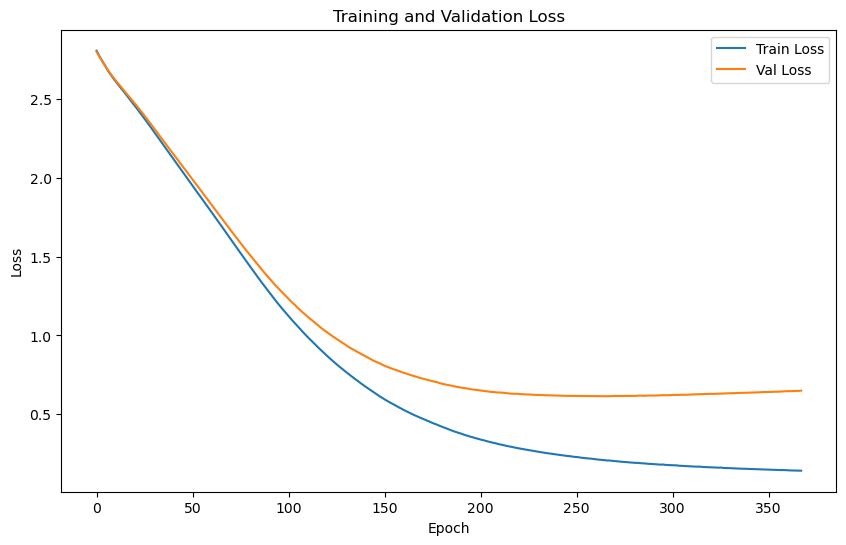

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5265 | Test Accuracy: 79.52%


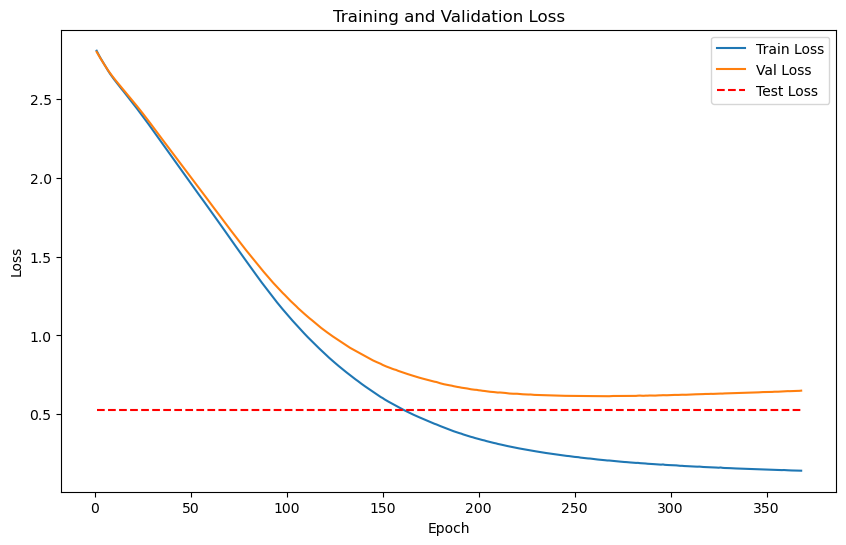

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.3357
Epoch [1/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3535

Validation loss improved from inf to 0.3535. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.3363
Epoch [2/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3538

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.3366
Epoch [3/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3537

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.3368
Epoch [4/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3537

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.3366
Epoch [5/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3533

Validation loss improved from 0.3535 to 0.3533. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.3360
Epoch [6/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3525

Validation loss improved from 0.3533 to 0.3525. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.3355
Epoch [7/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.3516

Validation loss improved from 0.3525 to 0.3516. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.3342
Epoch [8/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.3501

Validation loss improved from 0.3516 to 0.3501. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.3319
Epoch [9/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3478

Validation loss improved from 0.3501 to 0.3478. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.3292
Epoch [10/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3455

Validation loss improved from 0.3478 to 0.3455. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4508
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3598
    Batch [2/2], Val Loss: 0.3268
Epoch [11/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.3433

Validation loss improved from 0.3455 to 0.3433. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.3240
Epoch [12/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3407

Validation loss improved from 0.3433 to 0.3407. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.3229
Epoch [13/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.3388

Validation loss improved from 0.3407 to 0.3388. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.3224
Epoch [14/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3372

Validation loss improved from 0.3388 to 0.3372. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.3219
Epoch [15/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3355

Validation loss improved from 0.3372 to 0.3355. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.3211
Epoch [16/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3338

Validation loss improved from 0.3355 to 0.3338. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.3207
Epoch [17/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3326

Validation loss improved from 0.3338 to 0.3326. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3431
    Batch [2/2], Val Loss: 0.3199
Epoch [18/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3315

Validation loss improved from 0.3326 to 0.3315. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.3198
Epoch [19/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3308

Validation loss improved from 0.3315 to 0.3308. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3408
    Batch [2/2], Val Loss: 0.3197
Epoch [20/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.3302

Validation loss improved from 0.3308 to 0.3302. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.3193
Epoch [21/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3296

Validation loss improved from 0.3302 to 0.3296. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.3191
Epoch [22/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3291

Validation loss improved from 0.3296 to 0.3291. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.3190
Epoch [23/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3287

Validation loss improved from 0.3291 to 0.3287. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.3187
Epoch [24/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3282

Validation loss improved from 0.3287 to 0.3282. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3370
    Batch [2/2], Val Loss: 0.3183
Epoch [25/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3276

Validation loss improved from 0.3282 to 0.3276. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3364
    Batch [2/2], Val Loss: 0.3179
Epoch [26/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3271

Validation loss improved from 0.3276 to 0.3271. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.3175
Epoch [27/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3266

Validation loss improved from 0.3271 to 0.3266. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3352
    Batch [2/2], Val Loss: 0.3170
Epoch [28/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3261

Validation loss improved from 0.3266 to 0.3261. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3346
    Batch [2/2], Val Loss: 0.3165
Epoch [29/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3256

Validation loss improved from 0.3261 to 0.3256. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.3159
Epoch [30/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3250

Validation loss improved from 0.3256 to 0.3250. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.3153
Epoch [31/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3244

Validation loss improved from 0.3250 to 0.3244. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3330
    Batch [2/2], Val Loss: 0.3146
Epoch [32/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3325
    Batch [2/2], Val Loss: 0.3139
Epoch [33/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3232

Validation loss improved from 0.3238 to 0.3232. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3320
    Batch [2/2], Val Loss: 0.3133
Epoch [34/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3226

Validation loss improved from 0.3232 to 0.3226. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.3125
Epoch [35/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3220

Validation loss improved from 0.3226 to 0.3220. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3310
    Batch [2/2], Val Loss: 0.3118
Epoch [36/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3214

Validation loss improved from 0.3220 to 0.3214. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3305
    Batch [2/2], Val Loss: 0.3111
Epoch [37/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3208

Validation loss improved from 0.3214 to 0.3208. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3300
    Batch [2/2], Val Loss: 0.3104
Epoch [38/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3202

Validation loss improved from 0.3208 to 0.3202. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3295
    Batch [2/2], Val Loss: 0.3097
Epoch [39/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3196

Validation loss improved from 0.3202 to 0.3196. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3290
    Batch [2/2], Val Loss: 0.3091
Epoch [40/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3190

Validation loss improved from 0.3196 to 0.3190. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3286
    Batch [2/2], Val Loss: 0.3084
Epoch [41/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3185

Validation loss improved from 0.3190 to 0.3185. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3281
    Batch [2/2], Val Loss: 0.3077
Epoch [42/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3179

Validation loss improved from 0.3185 to 0.3179. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.3070
Epoch [43/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3173

Validation loss improved from 0.3179 to 0.3173. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3271
    Batch [2/2], Val Loss: 0.3063
Epoch [44/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3167

Validation loss improved from 0.3173 to 0.3167. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3266
    Batch [2/2], Val Loss: 0.3055
Epoch [45/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.3161

Validation loss improved from 0.3167 to 0.3161. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3262
    Batch [2/2], Val Loss: 0.3048
Epoch [46/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3155

Validation loss improved from 0.3161 to 0.3155. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3257
    Batch [2/2], Val Loss: 0.3041
Epoch [47/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.3149

Validation loss improved from 0.3155 to 0.3149. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3252
    Batch [2/2], Val Loss: 0.3034
Epoch [48/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3143

Validation loss improved from 0.3149 to 0.3143. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3248
    Batch [2/2], Val Loss: 0.3028
Epoch [49/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3138

Validation loss improved from 0.3143 to 0.3138. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3243
    Batch [2/2], Val Loss: 0.3021
Epoch [50/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3132

Validation loss improved from 0.3138 to 0.3132. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3239
    Batch [2/2], Val Loss: 0.3014
Epoch [51/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3126

Validation loss improved from 0.3132 to 0.3126. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3235
    Batch [2/2], Val Loss: 0.3006
Epoch [52/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3120

Validation loss improved from 0.3126 to 0.3120. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3230
    Batch [2/2], Val Loss: 0.2999
Epoch [53/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3114

Validation loss improved from 0.3120 to 0.3114. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3226
    Batch [2/2], Val Loss: 0.2991
Epoch [54/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.3109

Validation loss improved from 0.3114 to 0.3109. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3221
    Batch [2/2], Val Loss: 0.2983
Epoch [55/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3102

Validation loss improved from 0.3109 to 0.3102. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3217
    Batch [2/2], Val Loss: 0.2975
Epoch [56/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3096

Validation loss improved from 0.3102 to 0.3096. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3213
    Batch [2/2], Val Loss: 0.2968
Epoch [57/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3090

Validation loss improved from 0.3096 to 0.3090. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3209
    Batch [2/2], Val Loss: 0.2960
Epoch [58/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3084

Validation loss improved from 0.3090 to 0.3084. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3204
    Batch [2/2], Val Loss: 0.2952
Epoch [59/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3078

Validation loss improved from 0.3084 to 0.3078. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3200
    Batch [2/2], Val Loss: 0.2945
Epoch [60/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3073

Validation loss improved from 0.3078 to 0.3073. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3196
    Batch [2/2], Val Loss: 0.2938
Epoch [61/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3067

Validation loss improved from 0.3073 to 0.3067. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3191
    Batch [2/2], Val Loss: 0.2931
Epoch [62/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.3061

Validation loss improved from 0.3067 to 0.3061. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3187
    Batch [2/2], Val Loss: 0.2924
Epoch [63/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3055

Validation loss improved from 0.3061 to 0.3055. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3183
    Batch [2/2], Val Loss: 0.2917
Epoch [64/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3050

Validation loss improved from 0.3055 to 0.3050. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3179
    Batch [2/2], Val Loss: 0.2909
Epoch [65/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3044

Validation loss improved from 0.3050 to 0.3044. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3175
    Batch [2/2], Val Loss: 0.2902
Epoch [66/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3038

Validation loss improved from 0.3044 to 0.3038. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3171
    Batch [2/2], Val Loss: 0.2895
Epoch [67/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3033

Validation loss improved from 0.3038 to 0.3033. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3167
    Batch [2/2], Val Loss: 0.2889
Epoch [68/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3028

Validation loss improved from 0.3033 to 0.3028. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.2882
Epoch [69/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3023

Validation loss improved from 0.3028 to 0.3023. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.2876
Epoch [70/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3018

Validation loss improved from 0.3023 to 0.3018. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3157
    Batch [2/2], Val Loss: 0.2869
Epoch [71/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.3013

Validation loss improved from 0.3018 to 0.3013. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.3153
    Batch [2/2], Val Loss: 0.2862
Epoch [72/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3008

Validation loss improved from 0.3013 to 0.3008. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.3150
    Batch [2/2], Val Loss: 0.2854
Epoch [73/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3002

Validation loss improved from 0.3008 to 0.3002. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.3147
    Batch [2/2], Val Loss: 0.2847
Epoch [74/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2997

Validation loss improved from 0.3002 to 0.2997. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.3143
    Batch [2/2], Val Loss: 0.2839
Epoch [75/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2991

Validation loss improved from 0.2997 to 0.2991. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.2832
Epoch [76/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2986

Validation loss improved from 0.2991 to 0.2986. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.3136
    Batch [2/2], Val Loss: 0.2825
Epoch [77/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2980

Validation loss improved from 0.2986 to 0.2980. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.2817
Epoch [78/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2975

Validation loss improved from 0.2980 to 0.2975. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.3130
    Batch [2/2], Val Loss: 0.2809
Epoch [79/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2969

Validation loss improved from 0.2975 to 0.2969. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.3126
    Batch [2/2], Val Loss: 0.2801
Epoch [80/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2964

Validation loss improved from 0.2969 to 0.2964. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.3123
    Batch [2/2], Val Loss: 0.2794
Epoch [81/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2958

Validation loss improved from 0.2964 to 0.2958. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.3120
    Batch [2/2], Val Loss: 0.2786
Epoch [82/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2953

Validation loss improved from 0.2958 to 0.2953. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.3117
    Batch [2/2], Val Loss: 0.2778
Epoch [83/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2948

Validation loss improved from 0.2953 to 0.2948. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.2770
Epoch [84/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2942

Validation loss improved from 0.2948 to 0.2942. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.3111
    Batch [2/2], Val Loss: 0.2762
Epoch [85/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2937

Validation loss improved from 0.2942 to 0.2937. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.2754
Epoch [86/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2931

Validation loss improved from 0.2937 to 0.2931. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.3105
    Batch [2/2], Val Loss: 0.2746
Epoch [87/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2926

Validation loss improved from 0.2931 to 0.2926. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.2739
Epoch [88/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2920

Validation loss improved from 0.2926 to 0.2920. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.3098
    Batch [2/2], Val Loss: 0.2732
Epoch [89/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2915

Validation loss improved from 0.2920 to 0.2915. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.3095
    Batch [2/2], Val Loss: 0.2724
Epoch [90/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.2909

Validation loss improved from 0.2915 to 0.2909. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.2716
Epoch [91/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2904

Validation loss improved from 0.2909 to 0.2904. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.3088
    Batch [2/2], Val Loss: 0.2708
Epoch [92/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2898

Validation loss improved from 0.2904 to 0.2898. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.3085
    Batch [2/2], Val Loss: 0.2700
Epoch [93/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2893

Validation loss improved from 0.2898 to 0.2893. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.2692
Epoch [94/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2887

Validation loss improved from 0.2893 to 0.2887. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.2684
Epoch [95/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2881

Validation loss improved from 0.2887 to 0.2881. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.3075
    Batch [2/2], Val Loss: 0.2676
Epoch [96/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2876

Validation loss improved from 0.2881 to 0.2876. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.2669
Epoch [97/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2870

Validation loss improved from 0.2876 to 0.2870. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.3069
    Batch [2/2], Val Loss: 0.2662
Epoch [98/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2865

Validation loss improved from 0.2870 to 0.2865. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.3065
    Batch [2/2], Val Loss: 0.2655
Epoch [99/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2860

Validation loss improved from 0.2865 to 0.2860. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.3062
    Batch [2/2], Val Loss: 0.2647
Epoch [100/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2855

Validation loss improved from 0.2860 to 0.2855. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.3059
    Batch [2/2], Val Loss: 0.2640
Epoch [101/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2850

Validation loss improved from 0.2855 to 0.2850. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.2632
Epoch [102/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2844

Validation loss improved from 0.2850 to 0.2844. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.3053
    Batch [2/2], Val Loss: 0.2625
Epoch [103/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2839

Validation loss improved from 0.2844 to 0.2839. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.3050
    Batch [2/2], Val Loss: 0.2618
Epoch [104/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2834

Validation loss improved from 0.2839 to 0.2834. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.3047
    Batch [2/2], Val Loss: 0.2611
Epoch [105/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2829

Validation loss improved from 0.2834 to 0.2829. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.3044
    Batch [2/2], Val Loss: 0.2603
Epoch [106/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2823

Validation loss improved from 0.2829 to 0.2823. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.3040
    Batch [2/2], Val Loss: 0.2596
Epoch [107/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2818

Validation loss improved from 0.2823 to 0.2818. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.3037
    Batch [2/2], Val Loss: 0.2589
Epoch [108/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2813

Validation loss improved from 0.2818 to 0.2813. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.3034
    Batch [2/2], Val Loss: 0.2582
Epoch [109/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2808

Validation loss improved from 0.2813 to 0.2808. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.3031
    Batch [2/2], Val Loss: 0.2575
Epoch [110/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2803

Validation loss improved from 0.2808 to 0.2803. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.3028
    Batch [2/2], Val Loss: 0.2568
Epoch [111/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2798

Validation loss improved from 0.2803 to 0.2798. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.3024
    Batch [2/2], Val Loss: 0.2562
Epoch [112/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2793

Validation loss improved from 0.2798 to 0.2793. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.3021
    Batch [2/2], Val Loss: 0.2555
Epoch [113/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2788

Validation loss improved from 0.2793 to 0.2788. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.3018
    Batch [2/2], Val Loss: 0.2548
Epoch [114/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2783

Validation loss improved from 0.2788 to 0.2783. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.2541
Epoch [115/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2778

Validation loss improved from 0.2783 to 0.2778. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.3011
    Batch [2/2], Val Loss: 0.2533
Epoch [116/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2772

Validation loss improved from 0.2778 to 0.2772. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.3008
    Batch [2/2], Val Loss: 0.2526
Epoch [117/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2767

Validation loss improved from 0.2772 to 0.2767. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.3005
    Batch [2/2], Val Loss: 0.2518
Epoch [118/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2761

Validation loss improved from 0.2767 to 0.2761. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.3002
    Batch [2/2], Val Loss: 0.2510
Epoch [119/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2756

Validation loss improved from 0.2761 to 0.2756. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.2502
Epoch [120/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2751

Validation loss improved from 0.2756 to 0.2751. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2997
    Batch [2/2], Val Loss: 0.2495
Epoch [121/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2746

Validation loss improved from 0.2751 to 0.2746. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2994
    Batch [2/2], Val Loss: 0.2487
Epoch [122/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2740

Validation loss improved from 0.2746 to 0.2740. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2992
    Batch [2/2], Val Loss: 0.2479
Epoch [123/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2735

Validation loss improved from 0.2740 to 0.2735. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2989
    Batch [2/2], Val Loss: 0.2471
Epoch [124/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2730

Validation loss improved from 0.2735 to 0.2730. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2987
    Batch [2/2], Val Loss: 0.2464
Epoch [125/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.2725

Validation loss improved from 0.2730 to 0.2725. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.2456
Epoch [126/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2720

Validation loss improved from 0.2725 to 0.2720. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2981
    Batch [2/2], Val Loss: 0.2449
Epoch [127/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2715

Validation loss improved from 0.2720 to 0.2715. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.2441
Epoch [128/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2710

Validation loss improved from 0.2715 to 0.2710. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2977
    Batch [2/2], Val Loss: 0.2434
Epoch [129/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2705

Validation loss improved from 0.2710 to 0.2705. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.2426
Epoch [130/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2700

Validation loss improved from 0.2705 to 0.2700. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2972
    Batch [2/2], Val Loss: 0.2419
Epoch [131/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2696

Validation loss improved from 0.2700 to 0.2696. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.2412
Epoch [132/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2691

Validation loss improved from 0.2696 to 0.2691. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2969
    Batch [2/2], Val Loss: 0.2405
Epoch [133/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2687

Validation loss improved from 0.2691 to 0.2687. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2967
    Batch [2/2], Val Loss: 0.2399
Epoch [134/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2683

Validation loss improved from 0.2687 to 0.2683. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.2392
Epoch [135/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2678

Validation loss improved from 0.2683 to 0.2678. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2963
    Batch [2/2], Val Loss: 0.2385
Epoch [136/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2674

Validation loss improved from 0.2678 to 0.2674. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2961
    Batch [2/2], Val Loss: 0.2379
Epoch [137/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2670

Validation loss improved from 0.2674 to 0.2670. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3707
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2958
    Batch [2/2], Val Loss: 0.2373
Epoch [138/2000], Avg Train Loss: 0.3707, Avg Val Loss: 0.2666

Validation loss improved from 0.2670 to 0.2666. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2956
    Batch [2/2], Val Loss: 0.2367
Epoch [139/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2662

Validation loss improved from 0.2666 to 0.2662. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2954
    Batch [2/2], Val Loss: 0.2362
Epoch [140/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2658

Validation loss improved from 0.2662 to 0.2658. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2952
    Batch [2/2], Val Loss: 0.2357
Epoch [141/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2655

Validation loss improved from 0.2658 to 0.2655. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2352
Epoch [142/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2651

Validation loss improved from 0.2655 to 0.2651. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2948
    Batch [2/2], Val Loss: 0.2347
Epoch [143/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2647

Validation loss improved from 0.2651 to 0.2647. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2945
    Batch [2/2], Val Loss: 0.2342
Epoch [144/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2644

Validation loss improved from 0.2647 to 0.2644. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2943
    Batch [2/2], Val Loss: 0.2336
Epoch [145/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2640

Validation loss improved from 0.2644 to 0.2640. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2941
    Batch [2/2], Val Loss: 0.2330
Epoch [146/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2636

Validation loss improved from 0.2640 to 0.2636. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.2325
Epoch [147/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2631

Validation loss improved from 0.2636 to 0.2631. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.2318
Epoch [148/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2627

Validation loss improved from 0.2631 to 0.2627. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2933
    Batch [2/2], Val Loss: 0.2312
Epoch [149/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2622

Validation loss improved from 0.2627 to 0.2622. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.2305
Epoch [150/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2618

Validation loss improved from 0.2622 to 0.2618. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2927
    Batch [2/2], Val Loss: 0.2299
Epoch [151/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2613

Validation loss improved from 0.2618 to 0.2613. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2925
    Batch [2/2], Val Loss: 0.2293
Epoch [152/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2609

Validation loss improved from 0.2613 to 0.2609. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2922
    Batch [2/2], Val Loss: 0.2286
Epoch [153/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2604

Validation loss improved from 0.2609 to 0.2604. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2920
    Batch [2/2], Val Loss: 0.2280
Epoch [154/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2600

Validation loss improved from 0.2604 to 0.2600. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2918
    Batch [2/2], Val Loss: 0.2274
Epoch [155/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2596

Validation loss improved from 0.2600 to 0.2596. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.2269
Epoch [156/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2592

Validation loss improved from 0.2596 to 0.2592. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2913
    Batch [2/2], Val Loss: 0.2263
Epoch [157/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.2588

Validation loss improved from 0.2592 to 0.2588. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2910
    Batch [2/2], Val Loss: 0.2257
Epoch [158/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2584

Validation loss improved from 0.2588 to 0.2584. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2908
    Batch [2/2], Val Loss: 0.2252
Epoch [159/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2580

Validation loss improved from 0.2584 to 0.2580. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2905
    Batch [2/2], Val Loss: 0.2246
Epoch [160/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2575

Validation loss improved from 0.2580 to 0.2575. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2903
    Batch [2/2], Val Loss: 0.2240
Epoch [161/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.2571

Validation loss improved from 0.2575 to 0.2571. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2901
    Batch [2/2], Val Loss: 0.2234
Epoch [162/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2567

Validation loss improved from 0.2571 to 0.2567. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2898
    Batch [2/2], Val Loss: 0.2228
Epoch [163/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2563

Validation loss improved from 0.2567 to 0.2563. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2897
    Batch [2/2], Val Loss: 0.2223
Epoch [164/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2560

Validation loss improved from 0.2563 to 0.2560. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.2217
Epoch [165/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2556

Validation loss improved from 0.2560 to 0.2556. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.2212
Epoch [166/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2553

Validation loss improved from 0.2556 to 0.2553. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2892
    Batch [2/2], Val Loss: 0.2207
Epoch [167/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2549

Validation loss improved from 0.2553 to 0.2549. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.2202
Epoch [168/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2546

Validation loss improved from 0.2549 to 0.2546. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2197
Epoch [169/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2542

Validation loss improved from 0.2546 to 0.2542. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.2192
Epoch [170/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2539

Validation loss improved from 0.2542 to 0.2539. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2884
    Batch [2/2], Val Loss: 0.2187
Epoch [171/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2536

Validation loss improved from 0.2539 to 0.2536. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2883
    Batch [2/2], Val Loss: 0.2182
Epoch [172/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2532

Validation loss improved from 0.2536 to 0.2532. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2881
    Batch [2/2], Val Loss: 0.2177
Epoch [173/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2529

Validation loss improved from 0.2532 to 0.2529. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.2172
Epoch [174/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.2526

Validation loss improved from 0.2529 to 0.2526. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2877
    Batch [2/2], Val Loss: 0.2168
Epoch [175/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.2523

Validation loss improved from 0.2526 to 0.2523. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.2163
Epoch [176/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2519

Validation loss improved from 0.2523 to 0.2519. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2873
    Batch [2/2], Val Loss: 0.2159
Epoch [177/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2516

Validation loss improved from 0.2519 to 0.2516. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2871
    Batch [2/2], Val Loss: 0.2155
Epoch [178/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2513

Validation loss improved from 0.2516 to 0.2513. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2867
    Batch [2/2], Val Loss: 0.2150
Epoch [179/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2509

Validation loss improved from 0.2513 to 0.2509. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2864
    Batch [2/2], Val Loss: 0.2146
Epoch [180/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2505

Validation loss improved from 0.2509 to 0.2505. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2860
    Batch [2/2], Val Loss: 0.2141
Epoch [181/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2501

Validation loss improved from 0.2505 to 0.2501. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2857
    Batch [2/2], Val Loss: 0.2137
Epoch [182/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2497

Validation loss improved from 0.2501 to 0.2497. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2853
    Batch [2/2], Val Loss: 0.2133
Epoch [183/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2493

Validation loss improved from 0.2497 to 0.2493. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.2128
Epoch [184/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2489

Validation loss improved from 0.2493 to 0.2489. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2847
    Batch [2/2], Val Loss: 0.2124
Epoch [185/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2486

Validation loss improved from 0.2489 to 0.2486. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2844
    Batch [2/2], Val Loss: 0.2120
Epoch [186/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2482

Validation loss improved from 0.2486 to 0.2482. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2841
    Batch [2/2], Val Loss: 0.2115
Epoch [187/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2478

Validation loss improved from 0.2482 to 0.2478. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2838
    Batch [2/2], Val Loss: 0.2111
Epoch [188/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2475

Validation loss improved from 0.2478 to 0.2475. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2836
    Batch [2/2], Val Loss: 0.2106
Epoch [189/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2471

Validation loss improved from 0.2475 to 0.2471. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2102
Epoch [190/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2467

Validation loss improved from 0.2471 to 0.2467. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2830
    Batch [2/2], Val Loss: 0.2098
Epoch [191/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2464

Validation loss improved from 0.2467 to 0.2464. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2827
    Batch [2/2], Val Loss: 0.2095
Epoch [192/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2461

Validation loss improved from 0.2464 to 0.2461. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.2091
Epoch [193/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2458

Validation loss improved from 0.2461 to 0.2458. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.2087
Epoch [194/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2454

Validation loss improved from 0.2458 to 0.2454. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.2083
Epoch [195/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2451

Validation loss improved from 0.2454 to 0.2451. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2817
    Batch [2/2], Val Loss: 0.2080
Epoch [196/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.2076
Epoch [197/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2445

Validation loss improved from 0.2448 to 0.2445. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2812
    Batch [2/2], Val Loss: 0.2072
Epoch [198/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2442

Validation loss improved from 0.2445 to 0.2442. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.2068
Epoch [199/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.2439

Validation loss improved from 0.2442 to 0.2439. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2808
    Batch [2/2], Val Loss: 0.2064
Epoch [200/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2436

Validation loss improved from 0.2439 to 0.2436. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2805
    Batch [2/2], Val Loss: 0.2059
Epoch [201/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.2432

Validation loss improved from 0.2436 to 0.2432. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2804
    Batch [2/2], Val Loss: 0.2054
Epoch [202/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2429

Validation loss improved from 0.2432 to 0.2429. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2802
    Batch [2/2], Val Loss: 0.2049
Epoch [203/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2425

Validation loss improved from 0.2429 to 0.2425. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2800
    Batch [2/2], Val Loss: 0.2044
Epoch [204/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2422

Validation loss improved from 0.2425 to 0.2422. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.2039
Epoch [205/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2418

Validation loss improved from 0.2422 to 0.2418. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.2034
Epoch [206/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2415

Validation loss improved from 0.2418 to 0.2415. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2793
    Batch [2/2], Val Loss: 0.2030
Epoch [207/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2411

Validation loss improved from 0.2415 to 0.2411. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.2026
Epoch [208/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2789
    Batch [2/2], Val Loss: 0.2022
Epoch [209/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2405

Validation loss improved from 0.2409 to 0.2405. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.2018
Epoch [210/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2402

Validation loss improved from 0.2405 to 0.2402. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2784
    Batch [2/2], Val Loss: 0.2014
Epoch [211/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2399

Validation loss improved from 0.2402 to 0.2399. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2782
    Batch [2/2], Val Loss: 0.2010
Epoch [212/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2396

Validation loss improved from 0.2399 to 0.2396. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.2006
Epoch [213/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2393

Validation loss improved from 0.2396 to 0.2393. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2779
    Batch [2/2], Val Loss: 0.2001
Epoch [214/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2390

Validation loss improved from 0.2393 to 0.2390. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2777
    Batch [2/2], Val Loss: 0.1997
Epoch [215/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2387

Validation loss improved from 0.2390 to 0.2387. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.1991
Epoch [216/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2383

Validation loss improved from 0.2387 to 0.2383. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.1986
Epoch [217/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2380

Validation loss improved from 0.2383 to 0.2380. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2771
    Batch [2/2], Val Loss: 0.1981
Epoch [218/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2376

Validation loss improved from 0.2380 to 0.2376. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2768
    Batch [2/2], Val Loss: 0.1976
Epoch [219/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2372

Validation loss improved from 0.2376 to 0.2372. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2767
    Batch [2/2], Val Loss: 0.1971
Epoch [220/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2369

Validation loss improved from 0.2372 to 0.2369. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.1966
Epoch [221/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.2366

Validation loss improved from 0.2369 to 0.2366. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2764
    Batch [2/2], Val Loss: 0.1961
Epoch [222/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2363

Validation loss improved from 0.2366 to 0.2363. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2763
    Batch [2/2], Val Loss: 0.1957
Epoch [223/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.2360

Validation loss improved from 0.2363 to 0.2360. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3306
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2762
    Batch [2/2], Val Loss: 0.1952
Epoch [224/2000], Avg Train Loss: 0.3306, Avg Val Loss: 0.2357

Validation loss improved from 0.2360 to 0.2357. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.1947
Epoch [225/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2354

Validation loss improved from 0.2357 to 0.2354. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2758
    Batch [2/2], Val Loss: 0.1943
Epoch [226/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2351

Validation loss improved from 0.2354 to 0.2351. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.1939
Epoch [227/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2348

Validation loss improved from 0.2351 to 0.2348. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.1936
Epoch [228/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2345

Validation loss improved from 0.2348 to 0.2345. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.1934
Epoch [229/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2749
    Batch [2/2], Val Loss: 0.1931
Epoch [230/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2340

Validation loss improved from 0.2343 to 0.2340. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.1928
Epoch [231/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.2337

Validation loss improved from 0.2340 to 0.2337. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2743
    Batch [2/2], Val Loss: 0.1925
Epoch [232/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2334

Validation loss improved from 0.2337 to 0.2334. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.1923
Epoch [233/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2331

Validation loss improved from 0.2334 to 0.2331. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.1920
Epoch [234/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2329

Validation loss improved from 0.2331 to 0.2329. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2735
    Batch [2/2], Val Loss: 0.1918
Epoch [235/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2326

Validation loss improved from 0.2329 to 0.2326. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.1915
Epoch [236/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2324

Validation loss improved from 0.2326 to 0.2324. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2730
    Batch [2/2], Val Loss: 0.1913
Epoch [237/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2322

Validation loss improved from 0.2324 to 0.2322. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.1910
Epoch [238/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2319

Validation loss improved from 0.2322 to 0.2319. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2726
    Batch [2/2], Val Loss: 0.1908
Epoch [239/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.2317

Validation loss improved from 0.2319 to 0.2317. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.1906
Epoch [240/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2315

Validation loss improved from 0.2317 to 0.2315. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.1904
Epoch [241/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2313

Validation loss improved from 0.2315 to 0.2313. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.1902
Epoch [242/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2310

Validation loss improved from 0.2313 to 0.2310. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.1900
Epoch [243/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.2308

Validation loss improved from 0.2310 to 0.2308. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2714
    Batch [2/2], Val Loss: 0.1898
Epoch [244/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2306

Validation loss improved from 0.2308 to 0.2306. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2712
    Batch [2/2], Val Loss: 0.1895
Epoch [245/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2304

Validation loss improved from 0.2306 to 0.2304. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.1894
Epoch [246/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2302

Validation loss improved from 0.2304 to 0.2302. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3252
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.1892
Epoch [247/2000], Avg Train Loss: 0.3252, Avg Val Loss: 0.2300

Validation loss improved from 0.2302 to 0.2300. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.1889
Epoch [248/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2297

Validation loss improved from 0.2300 to 0.2297. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2702
    Batch [2/2], Val Loss: 0.1887
Epoch [249/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2294

Validation loss improved from 0.2297 to 0.2294. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.1885
Epoch [250/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2292

Validation loss improved from 0.2294 to 0.2292. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.1882
Epoch [251/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2289

Validation loss improved from 0.2292 to 0.2289. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2693
    Batch [2/2], Val Loss: 0.1881
Epoch [252/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.2287

Validation loss improved from 0.2289 to 0.2287. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2691
    Batch [2/2], Val Loss: 0.1879
Epoch [253/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2285

Validation loss improved from 0.2287 to 0.2285. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2689
    Batch [2/2], Val Loss: 0.1876
Epoch [254/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2283

Validation loss improved from 0.2285 to 0.2283. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2687
    Batch [2/2], Val Loss: 0.1874
Epoch [255/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2280

Validation loss improved from 0.2283 to 0.2280. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.1871
Epoch [256/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2277

Validation loss improved from 0.2280 to 0.2277. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2681
    Batch [2/2], Val Loss: 0.1869
Epoch [257/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2275

Validation loss improved from 0.2277 to 0.2275. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2677
    Batch [2/2], Val Loss: 0.1867
Epoch [258/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2272

Validation loss improved from 0.2275 to 0.2272. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.1864
Epoch [259/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2269

Validation loss improved from 0.2272 to 0.2269. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.1862
Epoch [260/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2266

Validation loss improved from 0.2269 to 0.2266. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.1859
Epoch [261/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2263

Validation loss improved from 0.2266 to 0.2263. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.1857
Epoch [262/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2261

Validation loss improved from 0.2263 to 0.2261. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2662
    Batch [2/2], Val Loss: 0.1854
Epoch [263/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.2258

Validation loss improved from 0.2261 to 0.2258. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3149
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2659
    Batch [2/2], Val Loss: 0.1851
Epoch [264/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2255

Validation loss improved from 0.2258 to 0.2255. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2657
    Batch [2/2], Val Loss: 0.1848
Epoch [265/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.2252

Validation loss improved from 0.2255 to 0.2252. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2654
    Batch [2/2], Val Loss: 0.1846
Epoch [266/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2250

Validation loss improved from 0.2252 to 0.2250. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.1842
Epoch [267/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2247

Validation loss improved from 0.2250 to 0.2247. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2650
    Batch [2/2], Val Loss: 0.1839
Epoch [268/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2244

Validation loss improved from 0.2247 to 0.2244. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.1835
Epoch [269/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2241

Validation loss improved from 0.2244 to 0.2241. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2645
    Batch [2/2], Val Loss: 0.1832
Epoch [270/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.2238

Validation loss improved from 0.2241 to 0.2238. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.1828
Epoch [271/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2236

Validation loss improved from 0.2238 to 0.2236. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2641
    Batch [2/2], Val Loss: 0.1825
Epoch [272/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2233

Validation loss improved from 0.2236 to 0.2233. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2639
    Batch [2/2], Val Loss: 0.1822
Epoch [273/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2230

Validation loss improved from 0.2233 to 0.2230. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2636
    Batch [2/2], Val Loss: 0.1819
Epoch [274/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2227

Validation loss improved from 0.2230 to 0.2227. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2633
    Batch [2/2], Val Loss: 0.1817
Epoch [275/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2225

Validation loss improved from 0.2227 to 0.2225. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2631
    Batch [2/2], Val Loss: 0.1815
Epoch [276/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2223

Validation loss improved from 0.2225 to 0.2223. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.1812
Epoch [277/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2220

Validation loss improved from 0.2223 to 0.2220. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.1810
Epoch [278/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2218

Validation loss improved from 0.2220 to 0.2218. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2621
    Batch [2/2], Val Loss: 0.1808
Epoch [279/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2215

Validation loss improved from 0.2218 to 0.2215. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.1806
Epoch [280/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2212

Validation loss improved from 0.2215 to 0.2212. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2614
    Batch [2/2], Val Loss: 0.1804
Epoch [281/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2209

Validation loss improved from 0.2212 to 0.2209. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2611
    Batch [2/2], Val Loss: 0.1801
Epoch [282/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2206

Validation loss improved from 0.2209 to 0.2206. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.1799
Epoch [283/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.2203

Validation loss improved from 0.2206 to 0.2203. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.1796
Epoch [284/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2200

Validation loss improved from 0.2203 to 0.2200. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.1793
Epoch [285/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2197

Validation loss improved from 0.2200 to 0.2197. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3025
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.1791
Epoch [286/2000], Avg Train Loss: 0.3025, Avg Val Loss: 0.2194

Validation loss improved from 0.2197 to 0.2194. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3091
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.1789
Epoch [287/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.2192

Validation loss improved from 0.2194 to 0.2192. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3037
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2592
    Batch [2/2], Val Loss: 0.1787
Epoch [288/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2189

Validation loss improved from 0.2192 to 0.2189. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.1785
Epoch [289/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.2187

Validation loss improved from 0.2189 to 0.2187. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3048
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.1782
Epoch [290/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2184

Validation loss improved from 0.2187 to 0.2184. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.1780
Epoch [291/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.2182

Validation loss improved from 0.2184 to 0.2182. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.1779
Epoch [292/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2181

Validation loss improved from 0.2182 to 0.2181. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2580
    Batch [2/2], Val Loss: 0.1778
Epoch [293/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2179

Validation loss improved from 0.2181 to 0.2179. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2578
    Batch [2/2], Val Loss: 0.1776
Epoch [294/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.2177

Validation loss improved from 0.2179 to 0.2177. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2576
    Batch [2/2], Val Loss: 0.1775
Epoch [295/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.2176

Validation loss improved from 0.2177 to 0.2176. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2574
    Batch [2/2], Val Loss: 0.1774
Epoch [296/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2174

Validation loss improved from 0.2176 to 0.2174. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2572
    Batch [2/2], Val Loss: 0.1772
Epoch [297/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2172

Validation loss improved from 0.2174 to 0.2172. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3050
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.1771
Epoch [298/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.2170

Validation loss improved from 0.2172 to 0.2170. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.1770
Epoch [299/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2168

Validation loss improved from 0.2170 to 0.2168. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.1768
Epoch [300/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2166

Validation loss improved from 0.2168 to 0.2166. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.1767
Epoch [301/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.2165

Validation loss improved from 0.2166 to 0.2165. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.1766
Epoch [302/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2163

Validation loss improved from 0.2165 to 0.2163. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3062
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.1765
Epoch [303/2000], Avg Train Loss: 0.3062, Avg Val Loss: 0.2161

Validation loss improved from 0.2163 to 0.2161. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3001
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.1764
Epoch [304/2000], Avg Train Loss: 0.3001, Avg Val Loss: 0.2160

Validation loss improved from 0.2161 to 0.2160. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3061
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.1763
Epoch [305/2000], Avg Train Loss: 0.3061, Avg Val Loss: 0.2159

Validation loss improved from 0.2160 to 0.2159. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2988
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.1762
Epoch [306/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.2158

Validation loss improved from 0.2159 to 0.2158. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2989
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2553
    Batch [2/2], Val Loss: 0.1760
Epoch [307/2000], Avg Train Loss: 0.2989, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.1759
Epoch [308/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.2155

Validation loss improved from 0.2156 to 0.2155. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2550
    Batch [2/2], Val Loss: 0.1757
Epoch [309/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2973
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2548
    Batch [2/2], Val Loss: 0.1756
Epoch [310/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.2152

Validation loss improved from 0.2154 to 0.2152. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2546
    Batch [2/2], Val Loss: 0.1755
Epoch [311/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.1754
Epoch [312/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.1752
Epoch [313/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3026
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2539
    Batch [2/2], Val Loss: 0.1750
Epoch [314/2000], Avg Train Loss: 0.3026, Avg Val Loss: 0.2145

Validation loss improved from 0.2147 to 0.2145. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.1749
Epoch [315/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2143

Validation loss improved from 0.2145 to 0.2143. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.1747
Epoch [316/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.2141

Validation loss improved from 0.2143 to 0.2141. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.1746
Epoch [317/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.2138

Validation loss improved from 0.2141 to 0.2138. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.1744
Epoch [318/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2136

Validation loss improved from 0.2138 to 0.2136. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.1743
Epoch [319/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2134

Validation loss improved from 0.2136 to 0.2134. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.1742
Epoch [320/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.2132

Validation loss improved from 0.2134 to 0.2132. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.1742
Epoch [321/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2130

Validation loss improved from 0.2132 to 0.2130. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2936
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.1741
Epoch [322/2000], Avg Train Loss: 0.2936, Avg Val Loss: 0.2128

Validation loss improved from 0.2130 to 0.2128. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.1740
Epoch [323/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2126

Validation loss improved from 0.2128 to 0.2126. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2510
    Batch [2/2], Val Loss: 0.1737
Epoch [324/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2124

Validation loss improved from 0.2126 to 0.2124. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.1735
Epoch [325/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2122

Validation loss improved from 0.2124 to 0.2122. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2507
    Batch [2/2], Val Loss: 0.1733
Epoch [326/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2120

Validation loss improved from 0.2122 to 0.2120. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.1731
Epoch [327/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.2118

Validation loss improved from 0.2120 to 0.2118. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.1729
Epoch [328/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2117

Validation loss improved from 0.2118 to 0.2117. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2503
    Batch [2/2], Val Loss: 0.1729
Epoch [329/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2116

Validation loss improved from 0.2117 to 0.2116. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2501
    Batch [2/2], Val Loss: 0.1728
Epoch [330/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.2114

Validation loss improved from 0.2116 to 0.2114. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2498
    Batch [2/2], Val Loss: 0.1727
Epoch [331/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.2112

Validation loss improved from 0.2114 to 0.2112. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2495
    Batch [2/2], Val Loss: 0.1725
Epoch [332/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.2110

Validation loss improved from 0.2112 to 0.2110. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.1724
Epoch [333/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.2108

Validation loss improved from 0.2110 to 0.2108. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.1724
Epoch [334/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.2106

Validation loss improved from 0.2108 to 0.2106. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2485
    Batch [2/2], Val Loss: 0.1723
Epoch [335/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.2104

Validation loss improved from 0.2106 to 0.2104. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2482
    Batch [2/2], Val Loss: 0.1723
Epoch [336/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2102

Validation loss improved from 0.2104 to 0.2102. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2479
    Batch [2/2], Val Loss: 0.1722
Epoch [337/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.1722
Epoch [338/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2099

Validation loss improved from 0.2100 to 0.2099. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2473
    Batch [2/2], Val Loss: 0.1722
Epoch [339/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.2098

Validation loss improved from 0.2099 to 0.2098. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2470
    Batch [2/2], Val Loss: 0.1722
Epoch [340/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2096

Validation loss improved from 0.2098 to 0.2096. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.1722
Epoch [341/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2094

Validation loss improved from 0.2096 to 0.2094. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2465
    Batch [2/2], Val Loss: 0.1721
Epoch [342/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2093

Validation loss improved from 0.2094 to 0.2093. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2461
    Batch [2/2], Val Loss: 0.1720
Epoch [343/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2091

Validation loss improved from 0.2093 to 0.2091. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2458
    Batch [2/2], Val Loss: 0.1719
Epoch [344/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2089

Validation loss improved from 0.2091 to 0.2089. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.1718
Epoch [345/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.2087

Validation loss improved from 0.2089 to 0.2087. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.1718
Epoch [346/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.2084

Validation loss improved from 0.2087 to 0.2084. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2447
    Batch [2/2], Val Loss: 0.1717
Epoch [347/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2082

Validation loss improved from 0.2084 to 0.2082. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2877
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.1715
Epoch [348/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2079

Validation loss improved from 0.2082 to 0.2079. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2886
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2440
    Batch [2/2], Val Loss: 0.1714
Epoch [349/2000], Avg Train Loss: 0.2886, Avg Val Loss: 0.2077

Validation loss improved from 0.2079 to 0.2077. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2875
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2436
    Batch [2/2], Val Loss: 0.1712
Epoch [350/2000], Avg Train Loss: 0.2875, Avg Val Loss: 0.2074

Validation loss improved from 0.2077 to 0.2074. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2867
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2433
    Batch [2/2], Val Loss: 0.1711
Epoch [351/2000], Avg Train Loss: 0.2867, Avg Val Loss: 0.2072

Validation loss improved from 0.2074 to 0.2072. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2857
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.1709
Epoch [352/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2070

Validation loss improved from 0.2072 to 0.2070. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2426
    Batch [2/2], Val Loss: 0.1708
Epoch [353/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2067

Validation loss improved from 0.2070 to 0.2067. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2423
    Batch [2/2], Val Loss: 0.1706
Epoch [354/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.2064

Validation loss improved from 0.2067 to 0.2064. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2419
    Batch [2/2], Val Loss: 0.1704
Epoch [355/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2062

Validation loss improved from 0.2064 to 0.2062. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2833
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2416
    Batch [2/2], Val Loss: 0.1703
Epoch [356/2000], Avg Train Loss: 0.2833, Avg Val Loss: 0.2060

Validation loss improved from 0.2062 to 0.2060. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.1701
Epoch [357/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2057

Validation loss improved from 0.2060 to 0.2057. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.1699
Epoch [358/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2055

Validation loss improved from 0.2057 to 0.2055. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2408
    Batch [2/2], Val Loss: 0.1698
Epoch [359/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.2053

Validation loss improved from 0.2055 to 0.2053. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2850
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2406
    Batch [2/2], Val Loss: 0.1696
Epoch [360/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2051

Validation loss improved from 0.2053 to 0.2051. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.1694
Epoch [361/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2049

Validation loss improved from 0.2051 to 0.2049. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.1694
Epoch [362/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2048

Validation loss improved from 0.2049 to 0.2048. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2401
    Batch [2/2], Val Loss: 0.1693
Epoch [363/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2047

Validation loss improved from 0.2048 to 0.2047. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2400
    Batch [2/2], Val Loss: 0.1693
Epoch [364/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2046

Validation loss improved from 0.2047 to 0.2046. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2398
    Batch [2/2], Val Loss: 0.1692
Epoch [365/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.2045

Validation loss improved from 0.2046 to 0.2045. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.1691
Epoch [366/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2044

Validation loss improved from 0.2045 to 0.2044. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2395
    Batch [2/2], Val Loss: 0.1691
Epoch [367/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2043

Validation loss improved from 0.2044 to 0.2043. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2393
    Batch [2/2], Val Loss: 0.1690
Epoch [368/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2041

Validation loss improved from 0.2043 to 0.2041. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2819
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.1689
Epoch [369/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2040

Validation loss improved from 0.2041 to 0.2040. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2390
    Batch [2/2], Val Loss: 0.1688
Epoch [370/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2039

Validation loss improved from 0.2040 to 0.2039. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2813
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.1687
Epoch [371/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.2037

Validation loss improved from 0.2039 to 0.2037. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2387
    Batch [2/2], Val Loss: 0.1686
Epoch [372/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2036

Validation loss improved from 0.2037 to 0.2036. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.1686
Epoch [373/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2035

Validation loss improved from 0.2036 to 0.2035. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2843
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2382
    Batch [2/2], Val Loss: 0.1686
Epoch [374/2000], Avg Train Loss: 0.2843, Avg Val Loss: 0.2034

Validation loss improved from 0.2035 to 0.2034. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2379
    Batch [2/2], Val Loss: 0.1685
Epoch [375/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2032

Validation loss improved from 0.2034 to 0.2032. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.1684
Epoch [376/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2031

Validation loss improved from 0.2032 to 0.2031. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2376
    Batch [2/2], Val Loss: 0.1683
Epoch [377/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2030

Validation loss improved from 0.2031 to 0.2030. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2375
    Batch [2/2], Val Loss: 0.1681
Epoch [378/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2028

Validation loss improved from 0.2030 to 0.2028. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.1679
Epoch [379/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2026

Validation loss improved from 0.2028 to 0.2026. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2370
    Batch [2/2], Val Loss: 0.1677
Epoch [380/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.2024

Validation loss improved from 0.2026 to 0.2024. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2367
    Batch [2/2], Val Loss: 0.1675
Epoch [381/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2021

Validation loss improved from 0.2024 to 0.2021. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.1673
Epoch [382/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2019

Validation loss improved from 0.2021 to 0.2019. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.1671
Epoch [383/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.2016

Validation loss improved from 0.2019 to 0.2016. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.1669
Epoch [384/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2013

Validation loss improved from 0.2016 to 0.2013. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2822
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2353
    Batch [2/2], Val Loss: 0.1667
Epoch [385/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2010

Validation loss improved from 0.2013 to 0.2010. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2349
    Batch [2/2], Val Loss: 0.1665
Epoch [386/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2007

Validation loss improved from 0.2010 to 0.2007. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2346
    Batch [2/2], Val Loss: 0.1663
Epoch [387/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.2004

Validation loss improved from 0.2007 to 0.2004. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2701
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2342
    Batch [2/2], Val Loss: 0.1662
Epoch [388/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2002

Validation loss improved from 0.2004 to 0.2002. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2337
    Batch [2/2], Val Loss: 0.1660
Epoch [389/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.1999

Validation loss improved from 0.2002 to 0.1999. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2767
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2334
    Batch [2/2], Val Loss: 0.1660
Epoch [390/2000], Avg Train Loss: 0.2767, Avg Val Loss: 0.1997

Validation loss improved from 0.1999 to 0.1997. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2331
    Batch [2/2], Val Loss: 0.1660
Epoch [391/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.1995

Validation loss improved from 0.1997 to 0.1995. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2327
    Batch [2/2], Val Loss: 0.1659
Epoch [392/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.1993

Validation loss improved from 0.1995 to 0.1993. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.1659
Epoch [393/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.1992

Validation loss improved from 0.1993 to 0.1992. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2715
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2324
    Batch [2/2], Val Loss: 0.1658
Epoch [394/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.1991

Validation loss improved from 0.1992 to 0.1991. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2323
    Batch [2/2], Val Loss: 0.1658
Epoch [395/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.1990

Validation loss improved from 0.1991 to 0.1990. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.1657
Epoch [396/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.1989

Validation loss improved from 0.1990 to 0.1989. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2727
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2320
    Batch [2/2], Val Loss: 0.1655
Epoch [397/2000], Avg Train Loss: 0.2727, Avg Val Loss: 0.1988

Validation loss improved from 0.1989 to 0.1988. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2318
    Batch [2/2], Val Loss: 0.1654
Epoch [398/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.1986

Validation loss improved from 0.1988 to 0.1986. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2317
    Batch [2/2], Val Loss: 0.1653
Epoch [399/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.1985

Validation loss improved from 0.1986 to 0.1985. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2316
    Batch [2/2], Val Loss: 0.1652
Epoch [400/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.1984

Validation loss improved from 0.1985 to 0.1984. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.1649
Epoch [401/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.1982

Validation loss improved from 0.1984 to 0.1982. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2314
    Batch [2/2], Val Loss: 0.1648
Epoch [402/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.1981

Validation loss improved from 0.1982 to 0.1981. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2313
    Batch [2/2], Val Loss: 0.1646
Epoch [403/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.1979

Validation loss improved from 0.1981 to 0.1979. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2311
    Batch [2/2], Val Loss: 0.1645
Epoch [404/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.1978

Validation loss improved from 0.1979 to 0.1978. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2310
    Batch [2/2], Val Loss: 0.1644
Epoch [405/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.1977

Validation loss improved from 0.1978 to 0.1977. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2308
    Batch [2/2], Val Loss: 0.1644
Epoch [406/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.1976

Validation loss improved from 0.1977 to 0.1976. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.1643
Epoch [407/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.1974

Validation loss improved from 0.1976 to 0.1974. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.1642
Epoch [408/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.1973

Validation loss improved from 0.1974 to 0.1973. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2300
    Batch [2/2], Val Loss: 0.1642
Epoch [409/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.1971

Validation loss improved from 0.1973 to 0.1971. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.1641
Epoch [410/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.1969

Validation loss improved from 0.1971 to 0.1969. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.1642
Epoch [411/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.1968

Validation loss improved from 0.1969 to 0.1968. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.1641
Epoch [412/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.1966

Validation loss improved from 0.1968 to 0.1966. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2291
    Batch [2/2], Val Loss: 0.1641
Epoch [413/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.1966

Validation loss improved from 0.1966 to 0.1966. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.1641
Epoch [414/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.1966

Validation loss improved from 0.1966 to 0.1966. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.1641
Epoch [415/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.1965

Validation loss improved from 0.1966 to 0.1965. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.1641
Epoch [416/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.1964

Validation loss improved from 0.1965 to 0.1964. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2287
    Batch [2/2], Val Loss: 0.1642
Epoch [417/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.1964

Validation loss improved from 0.1964 to 0.1964. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2679
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.1642
Epoch [418/2000], Avg Train Loss: 0.2679, Avg Val Loss: 0.1964

Validation loss improved from 0.1964 to 0.1964. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2285
    Batch [2/2], Val Loss: 0.1642
Epoch [419/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.1963

Validation loss improved from 0.1964 to 0.1963. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.1643
Epoch [420/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1963

Validation loss improved from 0.1963 to 0.1963. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.1643
Epoch [421/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2283
    Batch [2/2], Val Loss: 0.1644
Epoch [422/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.1963

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2281
    Batch [2/2], Val Loss: 0.1645
Epoch [423/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.1963

Validation loss improved from 0.1963 to 0.1963. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2280
    Batch [2/2], Val Loss: 0.1646
Epoch [424/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.1963

Validation loss improved from 0.1963 to 0.1963. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.1645
Epoch [425/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1962

Validation loss improved from 0.1963 to 0.1962. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2278
    Batch [2/2], Val Loss: 0.1645
Epoch [426/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.1961

Validation loss improved from 0.1962 to 0.1961. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.1643
Epoch [427/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.1960

Validation loss improved from 0.1961 to 0.1960. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.1641
Epoch [428/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1958

Validation loss improved from 0.1960 to 0.1958. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.1640
Epoch [429/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.1957

Validation loss improved from 0.1958 to 0.1957. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.1638
Epoch [430/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.1956

Validation loss improved from 0.1957 to 0.1956. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.1637
Epoch [431/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1956

Validation loss improved from 0.1956 to 0.1956. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.1636
Epoch [432/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1955

Validation loss improved from 0.1956 to 0.1955. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.1635
Epoch [433/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1955

Validation loss improved from 0.1955 to 0.1955. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2274
    Batch [2/2], Val Loss: 0.1635
Epoch [434/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1954

Validation loss improved from 0.1955 to 0.1954. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.1635
Epoch [435/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.1954

Validation loss improved from 0.1954 to 0.1954. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2270
    Batch [2/2], Val Loss: 0.1635
Epoch [436/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1953

Validation loss improved from 0.1954 to 0.1953. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2270
    Batch [2/2], Val Loss: 0.1636
Epoch [437/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.1953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2617
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2271
    Batch [2/2], Val Loss: 0.1637
Epoch [438/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.1954

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2270
    Batch [2/2], Val Loss: 0.1638
Epoch [439/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1954

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.1638
Epoch [440/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1954

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2267
    Batch [2/2], Val Loss: 0.1638
Epoch [441/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.1953

Validation loss improved from 0.1953 to 0.1953. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2265
    Batch [2/2], Val Loss: 0.1638
Epoch [442/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1952

Validation loss improved from 0.1953 to 0.1952. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2596
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.1637
Epoch [443/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.1950

Validation loss improved from 0.1952 to 0.1950. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.1636
Epoch [444/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1949

Validation loss improved from 0.1950 to 0.1949. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.2261
    Batch [2/2], Val Loss: 0.1635
Epoch [445/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1948

Validation loss improved from 0.1949 to 0.1948. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.1634
Epoch [446/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.1947

Validation loss improved from 0.1948 to 0.1947. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.1633
Epoch [447/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.1945

Validation loss improved from 0.1947 to 0.1945. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.1632
Epoch [448/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.1944

Validation loss improved from 0.1945 to 0.1944. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.1631
Epoch [449/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.1942

Validation loss improved from 0.1944 to 0.1942. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2619
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.1629
Epoch [450/2000], Avg Train Loss: 0.2619, Avg Val Loss: 0.1940

Validation loss improved from 0.1942 to 0.1940. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.2248
    Batch [2/2], Val Loss: 0.1627
Epoch [451/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1938

Validation loss improved from 0.1940 to 0.1938. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.2245
    Batch [2/2], Val Loss: 0.1624
Epoch [452/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.1935

Validation loss improved from 0.1938 to 0.1935. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.1622
Epoch [453/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1932

Validation loss improved from 0.1935 to 0.1932. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.2240
    Batch [2/2], Val Loss: 0.1619
Epoch [454/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.1929

Validation loss improved from 0.1932 to 0.1929. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.2237
    Batch [2/2], Val Loss: 0.1617
Epoch [455/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.1927

Validation loss improved from 0.1929 to 0.1927. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.2234
    Batch [2/2], Val Loss: 0.1615
Epoch [456/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1925

Validation loss improved from 0.1927 to 0.1925. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.2232
    Batch [2/2], Val Loss: 0.1613
Epoch [457/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1923

Validation loss improved from 0.1925 to 0.1923. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.1612
Epoch [458/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1921

Validation loss improved from 0.1923 to 0.1921. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.1610
Epoch [459/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.1920

Validation loss improved from 0.1921 to 0.1920. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.1608
Epoch [460/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.1918

Validation loss improved from 0.1920 to 0.1918. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2535
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.2228
    Batch [2/2], Val Loss: 0.1607
Epoch [461/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.1917

Validation loss improved from 0.1918 to 0.1917. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2516
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.2225
    Batch [2/2], Val Loss: 0.1606
Epoch [462/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.1916

Validation loss improved from 0.1917 to 0.1916. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.2223
    Batch [2/2], Val Loss: 0.1605
Epoch [463/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1914

Validation loss improved from 0.1916 to 0.1914. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1604
Epoch [464/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.1913

Validation loss improved from 0.1914 to 0.1913. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2554
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.2220
    Batch [2/2], Val Loss: 0.1603
Epoch [465/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.1912

Validation loss improved from 0.1913 to 0.1912. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1603
Epoch [466/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1911

Validation loss improved from 0.1912 to 0.1911. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1604
Epoch [467/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1605
Epoch [468/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2555
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1605
Epoch [469/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1606
Epoch [470/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.1606
Epoch [471/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1911

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.1606
Epoch [472/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1911

Validation loss improved from 0.1911 to 0.1911. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.1605
Epoch [473/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.1911

Validation loss improved from 0.1911 to 0.1911. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2498
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.2217
    Batch [2/2], Val Loss: 0.1604
Epoch [474/2000], Avg Train Loss: 0.2498, Avg Val Loss: 0.1911

Validation loss improved from 0.1911 to 0.1911. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1602
Epoch [475/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.1910

Validation loss improved from 0.1911 to 0.1910. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1601
Epoch [476/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1910

Validation loss improved from 0.1910 to 0.1910. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1599
Epoch [477/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.1909

Validation loss improved from 0.1910 to 0.1909. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.2220
    Batch [2/2], Val Loss: 0.1597
Epoch [478/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.1908

Validation loss improved from 0.1909 to 0.1908. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1596
Epoch [479/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.1908

Validation loss improved from 0.1908 to 0.1908. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.1594
Epoch [480/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.1908

Validation loss improved from 0.1908 to 0.1908. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.1593
Epoch [481/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.1907

Validation loss improved from 0.1908 to 0.1907. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.1592
Epoch [482/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.1906

Validation loss improved from 0.1907 to 0.1906. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2511
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.1591
Epoch [483/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.1904

Validation loss improved from 0.1906 to 0.1904. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.2216
    Batch [2/2], Val Loss: 0.1589
Epoch [484/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1902

Validation loss improved from 0.1904 to 0.1902. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.1589
Epoch [485/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1900

Validation loss improved from 0.1902 to 0.1900. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2482
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.1588
Epoch [486/2000], Avg Train Loss: 0.2482, Avg Val Loss: 0.1899

Validation loss improved from 0.1900 to 0.1899. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.1589
Epoch [487/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.1897

Validation loss improved from 0.1899 to 0.1897. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.2203
    Batch [2/2], Val Loss: 0.1589
Epoch [488/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.2200
    Batch [2/2], Val Loss: 0.1590
Epoch [489/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.1895

Validation loss improved from 0.1896 to 0.1895. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1590
Epoch [490/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.1893

Validation loss improved from 0.1895 to 0.1893. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1591
Epoch [491/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.1892

Validation loss improved from 0.1893 to 0.1892. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.2190
    Batch [2/2], Val Loss: 0.1591
Epoch [492/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.1890

Validation loss improved from 0.1892 to 0.1890. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2433
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1590
Epoch [493/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.1889

Validation loss improved from 0.1890 to 0.1889. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1590
Epoch [494/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.1887

Validation loss improved from 0.1889 to 0.1887. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1589
Epoch [495/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1886

Validation loss improved from 0.1887 to 0.1886. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1588
Epoch [496/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.1885

Validation loss improved from 0.1886 to 0.1885. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.1588
Epoch [497/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.1884

Validation loss improved from 0.1885 to 0.1884. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1587
Epoch [498/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.1884

Validation loss improved from 0.1884 to 0.1884. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.2183
    Batch [2/2], Val Loss: 0.1585
Epoch [499/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.1884

Validation loss improved from 0.1884 to 0.1884. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.1585
Epoch [500/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.2188
    Batch [2/2], Val Loss: 0.1583
Epoch [501/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2461
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1582
Epoch [502/2000], Avg Train Loss: 0.2461, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.2191
    Batch [2/2], Val Loss: 0.1580
Epoch [503/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1578
Epoch [504/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1885

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1576
Epoch [505/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.1884

Validation loss improved from 0.1884 to 0.1884. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.1574
Epoch [506/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.1884

Validation loss improved from 0.1884 to 0.1884. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.1572
Epoch [507/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.1883

Validation loss improved from 0.1884 to 0.1883. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2447
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.1570
Epoch [508/2000], Avg Train Loss: 0.2447, Avg Val Loss: 0.1883

Validation loss improved from 0.1883 to 0.1883. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.2194
    Batch [2/2], Val Loss: 0.1568
Epoch [509/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.1881

Validation loss improved from 0.1883 to 0.1881. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.1566
Epoch [510/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.1879

Validation loss improved from 0.1881 to 0.1879. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.1564
Epoch [511/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.1877

Validation loss improved from 0.1879 to 0.1877. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2361
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.1563
Epoch [512/2000], Avg Train Loss: 0.2361, Avg Val Loss: 0.1875

Validation loss improved from 0.1877 to 0.1875. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.2185
    Batch [2/2], Val Loss: 0.1563
Epoch [513/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1874

Validation loss improved from 0.1875 to 0.1874. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2391
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.1562
Epoch [514/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.1872

Validation loss improved from 0.1874 to 0.1872. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.1563
Epoch [515/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.1871

Validation loss improved from 0.1872 to 0.1871. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.1563
Epoch [516/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1870

Validation loss improved from 0.1871 to 0.1870. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.2175
    Batch [2/2], Val Loss: 0.1564
Epoch [517/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1869

Validation loss improved from 0.1870 to 0.1869. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.2173
    Batch [2/2], Val Loss: 0.1564
Epoch [518/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.1868

Validation loss improved from 0.1869 to 0.1868. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2385
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.1563
Epoch [519/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.1867

Validation loss improved from 0.1868 to 0.1867. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.2170
    Batch [2/2], Val Loss: 0.1563
Epoch [520/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1866

Validation loss improved from 0.1867 to 0.1866. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.2167
    Batch [2/2], Val Loss: 0.1561
Epoch [521/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.1864

Validation loss improved from 0.1866 to 0.1864. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1561
Epoch [522/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1863

Validation loss improved from 0.1864 to 0.1863. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2408
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1560
Epoch [523/2000], Avg Train Loss: 0.2408, Avg Val Loss: 0.1861

Validation loss improved from 0.1863 to 0.1861. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.1559
Epoch [524/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.1861

Validation loss improved from 0.1861 to 0.1861. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2359
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1558
Epoch [525/2000], Avg Train Loss: 0.2359, Avg Val Loss: 0.1860

Validation loss improved from 0.1861 to 0.1860. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1556
Epoch [526/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.1860

Validation loss improved from 0.1860 to 0.1860. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1555
Epoch [527/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1860

Validation loss improved from 0.1860 to 0.1860. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1555
Epoch [528/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.1859

Validation loss improved from 0.1860 to 0.1859. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1554
Epoch [529/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.1859

Validation loss improved from 0.1859 to 0.1859. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1553
Epoch [530/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1858

Validation loss improved from 0.1859 to 0.1858. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.1553
Epoch [531/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1858

Validation loss improved from 0.1858 to 0.1858. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1554
Epoch [532/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.1857

Validation loss improved from 0.1858 to 0.1857. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.1554
Epoch [533/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1856

Validation loss improved from 0.1857 to 0.1856. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.1554
Epoch [534/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1855

Validation loss improved from 0.1856 to 0.1855. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.1555
Epoch [535/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1854

Validation loss improved from 0.1855 to 0.1854. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.1555
Epoch [536/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1854

Validation loss improved from 0.1854 to 0.1854. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.1556
Epoch [537/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.1556
Epoch [538/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2387
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.2156
    Batch [2/2], Val Loss: 0.1556
Epoch [539/2000], Avg Train Loss: 0.2387, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2397
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.1556
Epoch [540/2000], Avg Train Loss: 0.2397, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.1556
Epoch [541/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1556
Epoch [542/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1557
Epoch [543/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1558
Epoch [544/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.1558
Epoch [545/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1558
Epoch [546/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1558
Epoch [547/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1558
Epoch [548/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1558
Epoch [549/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1556
Epoch [550/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1553
Epoch [551/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1551
Epoch [552/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.1549
Epoch [553/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1546
Epoch [554/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.2164
    Batch [2/2], Val Loss: 0.1543
Epoch [555/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1854

Validation loss improved from 0.1854 to 0.1854. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1540
Epoch [556/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.1852

Validation loss improved from 0.1854 to 0.1852. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.1537
Epoch [557/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1850

Validation loss improved from 0.1852 to 0.1850. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.1535
Epoch [558/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1848

Validation loss improved from 0.1850 to 0.1848. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.2160
    Batch [2/2], Val Loss: 0.1534
Epoch [559/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.1847

Validation loss improved from 0.1848 to 0.1847. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.2159
    Batch [2/2], Val Loss: 0.1533
Epoch [560/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.1846

Validation loss improved from 0.1847 to 0.1846. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.2156
    Batch [2/2], Val Loss: 0.1532
Epoch [561/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1844

Validation loss improved from 0.1846 to 0.1844. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.1532
Epoch [562/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1842

Validation loss improved from 0.1844 to 0.1842. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.2150
    Batch [2/2], Val Loss: 0.1532
Epoch [563/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1841

Validation loss improved from 0.1842 to 0.1841. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.2148
    Batch [2/2], Val Loss: 0.1531
Epoch [564/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1840

Validation loss improved from 0.1841 to 0.1840. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.1531
Epoch [565/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1839

Validation loss improved from 0.1840 to 0.1839. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.2145
    Batch [2/2], Val Loss: 0.1531
Epoch [566/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1838

Validation loss improved from 0.1839 to 0.1838. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.2143
    Batch [2/2], Val Loss: 0.1531
Epoch [567/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1837

Validation loss improved from 0.1838 to 0.1837. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1532
Epoch [568/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.1836

Validation loss improved from 0.1837 to 0.1836. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.1532
Epoch [569/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1835

Validation loss improved from 0.1836 to 0.1835. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2344
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1533
Epoch [570/2000], Avg Train Loss: 0.2344, Avg Val Loss: 0.1834

Validation loss improved from 0.1835 to 0.1834. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1533
Epoch [571/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1833

Validation loss improved from 0.1834 to 0.1833. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1533
Epoch [572/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.1832

Validation loss improved from 0.1833 to 0.1832. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.1533
Epoch [573/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1831

Validation loss improved from 0.1832 to 0.1831. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1532
Epoch [574/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1831

Validation loss improved from 0.1831 to 0.1831. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.1531
Epoch [575/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.1831

Validation loss improved from 0.1831 to 0.1831. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1530
Epoch [576/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1831

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1528
Epoch [577/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1831

Validation loss improved from 0.1831 to 0.1831. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1526
Epoch [578/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1830

Validation loss improved from 0.1831 to 0.1830. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1525
Epoch [579/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1830

Validation loss improved from 0.1830 to 0.1830. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1524
Epoch [580/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.1829

Validation loss improved from 0.1830 to 0.1829. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2243
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1523
Epoch [581/2000], Avg Train Loss: 0.2243, Avg Val Loss: 0.1828

Validation loss improved from 0.1829 to 0.1828. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1522
Epoch [582/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1828

Validation loss improved from 0.1828 to 0.1828. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2224
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1520
Epoch [583/2000], Avg Train Loss: 0.2224, Avg Val Loss: 0.1827

Validation loss improved from 0.1828 to 0.1827. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.2132
    Batch [2/2], Val Loss: 0.1519
Epoch [584/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.1826

Validation loss improved from 0.1827 to 0.1826. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.2132
    Batch [2/2], Val Loss: 0.1517
Epoch [585/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.2132
    Batch [2/2], Val Loss: 0.1517
Epoch [586/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.1824

Validation loss improved from 0.1824 to 0.1824. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1517
Epoch [587/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.1824

Validation loss improved from 0.1824 to 0.1824. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1517
Epoch [588/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1824

Validation loss improved from 0.1824 to 0.1824. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1516
Epoch [589/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1823

Validation loss improved from 0.1824 to 0.1823. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1516
Epoch [590/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1823

Validation loss improved from 0.1823 to 0.1823. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.1516
Epoch [591/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1823

Validation loss improved from 0.1823 to 0.1823. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2274
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1515
Epoch [592/2000], Avg Train Loss: 0.2274, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.1514
Epoch [593/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1513
Epoch [594/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.1513
Epoch [595/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.1825

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.1513
Epoch [596/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.1826

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1514
Epoch [597/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1515
Epoch [598/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.1515
Epoch [599/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1827

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.2135
    Batch [2/2], Val Loss: 0.1516
Epoch [600/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1826

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.1518
Epoch [601/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1824

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.1519
Epoch [602/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.1822

Validation loss improved from 0.1823 to 0.1822. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1520
Epoch [603/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1819

Validation loss improved from 0.1822 to 0.1819. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.1521
Epoch [604/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.1817

Validation loss improved from 0.1819 to 0.1817. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1521
Epoch [605/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.1815

Validation loss improved from 0.1817 to 0.1815. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2175
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.1522
Epoch [606/2000], Avg Train Loss: 0.2175, Avg Val Loss: 0.1813

Validation loss improved from 0.1815 to 0.1813. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.1522
Epoch [607/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.1812

Validation loss improved from 0.1813 to 0.1812. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.1522
Epoch [608/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1522
Epoch [609/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1812

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1520
Epoch [610/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1518
Epoch [611/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.1814

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1517
Epoch [612/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.1815

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1515
Epoch [613/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.2124
    Batch [2/2], Val Loss: 0.1513
Epoch [614/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.1818

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.2128
    Batch [2/2], Val Loss: 0.1511
Epoch [615/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1508
Epoch [616/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.1505
Epoch [617/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2167
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.2137
    Batch [2/2], Val Loss: 0.1502
Epoch [618/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.1500
Epoch [619/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1498
Epoch [620/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1820

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.2142
    Batch [2/2], Val Loss: 0.1495
Epoch [621/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.1819

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2211
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.2140
    Batch [2/2], Val Loss: 0.1493
Epoch [622/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.1490
Epoch [623/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1813

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.1487
Epoch [624/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1809

Validation loss improved from 0.1812 to 0.1809. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2220
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.1485
Epoch [625/2000], Avg Train Loss: 0.2220, Avg Val Loss: 0.1806

Validation loss improved from 0.1809 to 0.1806. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2232
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.1483
Epoch [626/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1803

Validation loss improved from 0.1806 to 0.1803. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.2120
    Batch [2/2], Val Loss: 0.1482
Epoch [627/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.1801

Validation loss improved from 0.1803 to 0.1801. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.1481
Epoch [628/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.1799

Validation loss improved from 0.1801 to 0.1799. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1479
Epoch [629/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1796

Validation loss improved from 0.1799 to 0.1796. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1477
Epoch [630/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.1794

Validation loss improved from 0.1796 to 0.1794. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1476
Epoch [631/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.1792

Validation loss improved from 0.1794 to 0.1792. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1476
Epoch [632/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.1792

Validation loss improved from 0.1792 to 0.1792. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1475
Epoch [633/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.1792

Validation loss improved from 0.1792 to 0.1792. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2217
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1474
Epoch [634/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1791

Validation loss improved from 0.1792 to 0.1791. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2199
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1474
Epoch [635/2000], Avg Train Loss: 0.2199, Avg Val Loss: 0.1791

Validation loss improved from 0.1791 to 0.1791. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1474
Epoch [636/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2170
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1475
Epoch [637/2000], Avg Train Loss: 0.2170, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2198
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.1476
Epoch [638/2000], Avg Train Loss: 0.2198, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1477
Epoch [639/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1479
Epoch [640/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2173
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1481
Epoch [641/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.1482
Epoch [642/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.2098
    Batch [2/2], Val Loss: 0.1483
Epoch [643/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1791

Validation loss improved from 0.1791 to 0.1791. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.1483
Epoch [644/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1789

Validation loss improved from 0.1791 to 0.1789. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1483
Epoch [645/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.1787

Validation loss improved from 0.1789 to 0.1787. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1481
Epoch [646/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.2087
    Batch [2/2], Val Loss: 0.1481
Epoch [647/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1784

Validation loss improved from 0.1785 to 0.1784. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.1479
Epoch [648/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1782

Validation loss improved from 0.1784 to 0.1782. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.2086
    Batch [2/2], Val Loss: 0.1478
Epoch [649/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.1782

Validation loss improved from 0.1782 to 0.1782. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.1478
Epoch [650/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1478
Epoch [651/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1478
Epoch [652/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.1477
Epoch [653/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.2098
    Batch [2/2], Val Loss: 0.1476
Epoch [654/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.1474
Epoch [655/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1472
Epoch [656/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.1471
Epoch [657/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2166
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1470
Epoch [658/2000], Avg Train Loss: 0.2166, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1468
Epoch [659/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2196
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1468
Epoch [660/2000], Avg Train Loss: 0.2196, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1469
Epoch [661/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1469
Epoch [662/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1470
Epoch [663/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2160
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1470
Epoch [664/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1471
Epoch [665/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1471
Epoch [666/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1471
Epoch [667/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.2116
    Batch [2/2], Val Loss: 0.1471
Epoch [668/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1793

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1470
Epoch [669/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.2120
    Batch [2/2], Val Loss: 0.1470
Epoch [670/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.1470
Epoch [671/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.2123
    Batch [2/2], Val Loss: 0.1470
Epoch [672/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.2121
    Batch [2/2], Val Loss: 0.1470
Epoch [673/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.1470
Epoch [674/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.1469
Epoch [675/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1793

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.1469
Epoch [676/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.2114
    Batch [2/2], Val Loss: 0.1468
Epoch [677/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.1468
Epoch [678/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.1468
Epoch [679/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.2111
    Batch [2/2], Val Loss: 0.1467
Epoch [680/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2147
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.1467
Epoch [681/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.2109
    Batch [2/2], Val Loss: 0.1466
Epoch [682/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.1466
Epoch [683/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.1466
Epoch [684/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2154
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.1466
Epoch [685/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.2105
    Batch [2/2], Val Loss: 0.1465
Epoch [686/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.1465
Epoch [687/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1785

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.1465
Epoch [688/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.1465
Epoch [689/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1784

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.1465
Epoch [690/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.1464
Epoch [691/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1783

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.1464
Epoch [692/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1782

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.1464
Epoch [693/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1782

Validation loss improved from 0.1782 to 0.1782. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.2099
    Batch [2/2], Val Loss: 0.1464
Epoch [694/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1781

Validation loss improved from 0.1782 to 0.1781. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.2098
    Batch [2/2], Val Loss: 0.1464
Epoch [695/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.1781

Validation loss improved from 0.1781 to 0.1781. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2126
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.2098
    Batch [2/2], Val Loss: 0.1463
Epoch [696/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1780

Validation loss improved from 0.1781 to 0.1780. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.2097
    Batch [2/2], Val Loss: 0.1463
Epoch [697/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1780

Validation loss improved from 0.1780 to 0.1780. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.1463
Epoch [698/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1779

Validation loss improved from 0.1780 to 0.1779. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.2095
    Batch [2/2], Val Loss: 0.1463
Epoch [699/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1779

Validation loss improved from 0.1779 to 0.1779. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.2095
    Batch [2/2], Val Loss: 0.1463
Epoch [700/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1779

Validation loss improved from 0.1779 to 0.1779. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.2095
    Batch [2/2], Val Loss: 0.1463
Epoch [701/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1779

Validation loss improved from 0.1779 to 0.1779. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1463
Epoch [702/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1778

Validation loss improved from 0.1779 to 0.1778. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1462
Epoch [703/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2123
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1462
Epoch [704/2000], Avg Train Loss: 0.2123, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1462
Epoch [705/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1462
Epoch [706/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1462
Epoch [707/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [708/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [709/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [710/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1778

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [711/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [712/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1778

Validation loss improved from 0.1778 to 0.1778. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [713/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1777

Validation loss improved from 0.1778 to 0.1777. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1461
Epoch [714/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1460
Epoch [715/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1460
Epoch [716/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1460
Epoch [717/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1460
Epoch [718/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1460
Epoch [719/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1777

Validation loss improved from 0.1777 to 0.1777. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [720/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1776

Validation loss improved from 0.1777 to 0.1776. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [721/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [722/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [723/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [724/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1459
Epoch [725/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1459
Epoch [726/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.1459
Epoch [727/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [728/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1776

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [729/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1459
Epoch [730/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1459
Epoch [731/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1776

Validation loss improved from 0.1776 to 0.1776. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1459
Epoch [732/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1775

Validation loss improved from 0.1776 to 0.1775. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1459
Epoch [733/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [734/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [735/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [736/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2105
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [737/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [738/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1459
Epoch [739/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1459
Epoch [740/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1459
Epoch [741/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1459
Epoch [742/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1459
Epoch [743/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [744/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [745/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [746/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [747/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [748/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [749/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1459
Epoch [750/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.1775

Validation loss improved from 0.1775 to 0.1775. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1458
Epoch [751/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1774

Validation loss improved from 0.1775 to 0.1774. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2172
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [752/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [753/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [754/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [755/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [756/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [757/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [758/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [759/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1458
Epoch [760/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1458
Epoch [761/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1458
Epoch [762/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1458
Epoch [763/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1458
Epoch [764/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1458
Epoch [765/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1458
Epoch [766/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1458
Epoch [767/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.1458
Epoch [768/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1458
Epoch [769/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [770/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [771/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [772/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [773/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [774/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1457
Epoch [775/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1456
Epoch [776/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1456
Epoch [777/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1456
Epoch [778/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2146
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1456
Epoch [779/2000], Avg Train Loss: 0.2146, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2150
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [780/2000], Avg Train Loss: 0.2150, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [781/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1774

Validation loss improved from 0.1774 to 0.1774. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2072
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [782/2000], Avg Train Loss: 0.2072, Avg Val Loss: 0.1773

Validation loss improved from 0.1774 to 0.1773. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [783/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1456
Epoch [784/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1456
Epoch [785/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1456
Epoch [786/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2028
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1456
Epoch [787/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [788/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [789/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [790/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [791/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1455
Epoch [792/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [793/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [794/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2107
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [795/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.1773

Validation loss improved from 0.1773 to 0.1773. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [796/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [797/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [798/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1772

Validation loss improved from 0.1773 to 0.1772. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [799/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [800/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [801/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [802/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [803/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [804/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [805/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [806/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [807/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [808/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [809/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [810/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [811/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [812/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [813/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1454
Epoch [814/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1454
Epoch [815/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1772

Validation loss improved from 0.1772 to 0.1772. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1454
Epoch [816/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.1771

Validation loss improved from 0.1772 to 0.1771. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1454
Epoch [817/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1771

Validation loss improved from 0.1771 to 0.1771. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.1454
Epoch [818/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1771

Validation loss improved from 0.1771 to 0.1771. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1453
Epoch [819/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1453
Epoch [820/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1453
Epoch [821/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1453
Epoch [822/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1453
Epoch [823/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [824/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [825/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [826/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [827/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1454
Epoch [828/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1455
Epoch [829/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1455
Epoch [830/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.2119
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1455
Epoch [831/2000], Avg Train Loss: 0.2119, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1455
Epoch [832/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1455
Epoch [833/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1455
Epoch [834/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.1456
Epoch [835/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [836/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1455
Epoch [837/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [838/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [839/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [840/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [841/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.1456
Epoch [842/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.2112
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1456
Epoch [843/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [844/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [845/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [846/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [847/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [848/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [849/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [850/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [851/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.2120
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [852/2000], Avg Train Loss: 0.2120, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [853/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [854/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [855/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [856/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [857/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.2164
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1455
Epoch [858/2000], Avg Train Loss: 0.2164, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.2053
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [859/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [860/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [861/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [862/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [863/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [864/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [865/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [866/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [867/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [868/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [869/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [870/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [871/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [872/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [873/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [874/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [875/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [876/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [877/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [878/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.2019
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [879/2000], Avg Train Loss: 0.2019, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [880/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [881/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [882/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [883/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [884/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [885/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.2063
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [886/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [887/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [888/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [889/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [890/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [891/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [892/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [893/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [894/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.2043
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [895/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.2117
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [896/2000], Avg Train Loss: 0.2117, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [897/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [898/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [899/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [900/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [901/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [902/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [903/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [904/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [905/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [906/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [907/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [908/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [909/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [910/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [911/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [912/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.2082
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [913/2000], Avg Train Loss: 0.2082, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [914/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [915/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [916/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [917/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.1454
Epoch [918/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 918!!
No improvement for 100 epochs


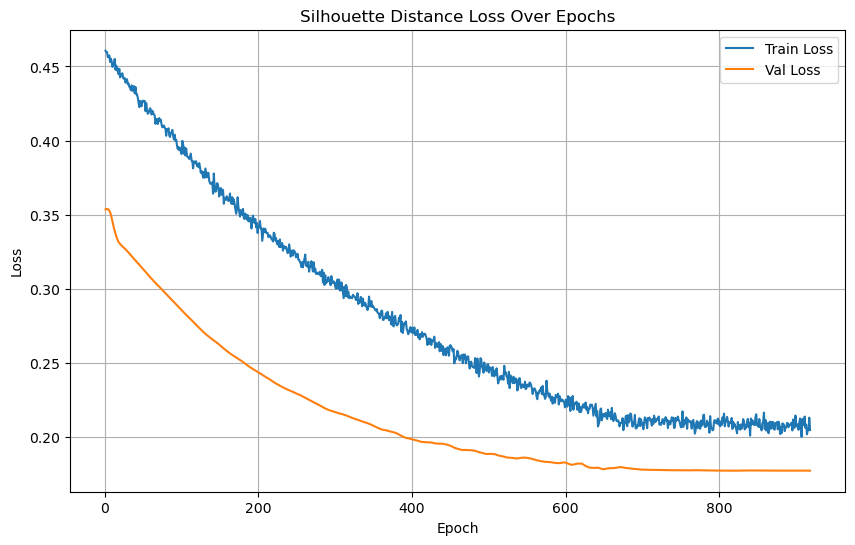

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/840], Loss: 0.0591


Test Batch [20/840], Loss: 0.1409
Test Batch [30/840], Loss: 0.1528
Test Batch [40/840], Loss: 0.5000
Test Batch [50/840], Loss: 0.1227
Test Batch [60/840], Loss: 0.0623
Test Batch [70/840], Loss: 0.0897


Test Batch [80/840], Loss: 0.5000


Test Batch [90/840], Loss: 0.0741
Test Batch [100/840], Loss: 0.1756
Test Batch [110/840], Loss: 0.5000
Test Batch [120/840], Loss: 0.1255
Test Batch [130/840], Loss: 0.1161
Test Batch [140/840], Loss: 0.1369
Test Batch [150/840], Loss: 0.0962


Test Batch [160/840], Loss: 0.1560


Test Batch [170/840], Loss: 0.0969
Test Batch [180/840], Loss: 0.0953
Test Batch [190/840], Loss: 0.1126
Test Batch [200/840], Loss: 0.0437


Test Batch [210/840], Loss: 0.0414


Test Batch [220/840], Loss: 0.0562
Test Batch [230/840], Loss: 0.1022
Test Batch [240/840], Loss: 0.0413
Test Batch [250/840], Loss: 0.0813


Test Batch [260/840], Loss: 0.2465
Test Batch [270/840], Loss: 0.2105
Test Batch [280/840], Loss: 0.2539
Test Batch [290/840], Loss: 0.1126


Test Batch [300/840], Loss: 0.2531
Test Batch [310/840], Loss: 0.1830
Test Batch [320/840], Loss: 0.1492
Test Batch [330/840], Loss: 0.2035
Test Batch [340/840], Loss: 0.1745
Test Batch [350/840], Loss: 0.5000
Test Batch [360/840], Loss: 0.5000


Test Batch [370/840], Loss: 0.5000
Test Batch [380/840], Loss: 0.5000
Test Batch [390/840], Loss: 0.5000
Test Batch [400/840], Loss: 0.5000
Test Batch [410/840], Loss: 0.5000
Test Batch [420/840], Loss: 0.5000
Test Batch [430/840], Loss: 0.0563
Test Batch [440/840], Loss: 0.0680
Test Batch [450/840], Loss: 0.1273


Test Batch [460/840], Loss: 0.0520
Test Batch [470/840], Loss: 0.0703
Test Batch [480/840], Loss: 0.1149
Test Batch [490/840], Loss: 0.5000
Test Batch [500/840], Loss: 0.0829
Test Batch [510/840], Loss: 0.0884
Test Batch [520/840], Loss: 0.1120


Test Batch [530/840], Loss: 0.2053
Test Batch [540/840], Loss: 0.1459
Test Batch [550/840], Loss: 0.1287
Test Batch [560/840], Loss: 0.1441
Test Batch [570/840], Loss: 0.1173


Test Batch [580/840], Loss: 0.1479
Test Batch [590/840], Loss: 0.0934
Test Batch [600/840], Loss: 0.1677
Test Batch [610/840], Loss: 0.1365
Test Batch [620/840], Loss: 0.0610
Test Batch [630/840], Loss: 0.1272


Test Batch [640/840], Loss: 0.0622
Test Batch [650/840], Loss: 0.2074
Test Batch [660/840], Loss: 0.3508
Test Batch [670/840], Loss: 0.0962
Test Batch [680/840], Loss: 0.0791


Test Batch [690/840], Loss: 0.2778
Test Batch [700/840], Loss: 0.2243
Test Batch [710/840], Loss: 0.1337
Test Batch [720/840], Loss: 0.1089
Test Batch [730/840], Loss: 0.0963


Test Batch [740/840], Loss: 0.1767
Test Batch [750/840], Loss: 0.1321
Test Batch [760/840], Loss: 0.5000
Test Batch [770/840], Loss: 0.1528
Test Batch [780/840], Loss: 0.5000
Test Batch [790/840], Loss: 0.2022


Test Batch [800/840], Loss: 0.0907
Test Batch [810/840], Loss: 0.5000
Test Batch [820/840], Loss: 0.1179
Test Batch [830/840], Loss: 0.1573
Test Batch [840/840], Loss: 0.1274

Test Loss: 0.1945


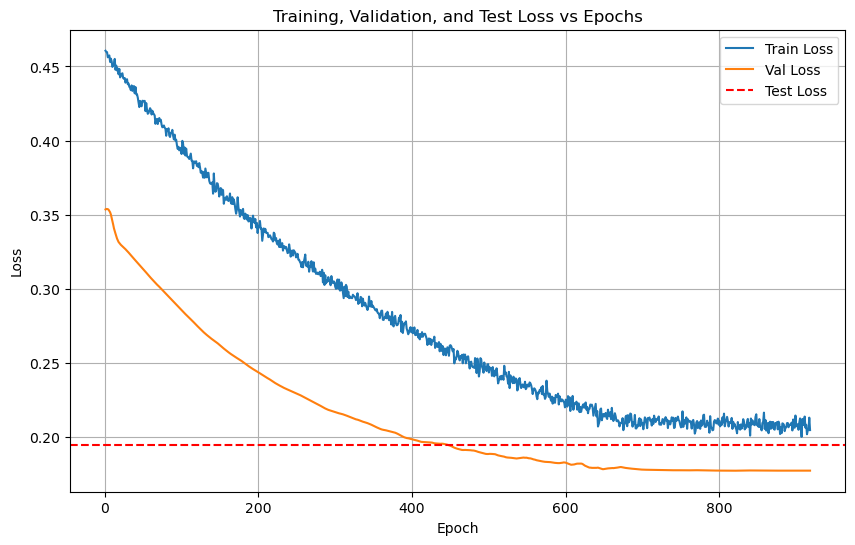

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/840 for test dataset.
  Processed batch 20/840 for test dataset.
  Processed batch 30/840 for test dataset.


  Processed batch 40/840 for test dataset.
  Processed batch 50/840 for test dataset.
  Processed batch 60/840 for test dataset.
  Processed batch 70/840 for test dataset.


  Processed batch 80/840 for test dataset.
  Processed batch 90/840 for test dataset.
  Processed batch 100/840 for test dataset.


  Processed batch 110/840 for test dataset.
  Processed batch 120/840 for test dataset.
  Processed batch 130/840 for test dataset.


  Processed batch 140/840 for test dataset.
  Processed batch 150/840 for test dataset.
  Processed batch 160/840 for test dataset.


  Processed batch 170/840 for test dataset.
  Processed batch 180/840 for test dataset.
  Processed batch 190/840 for test dataset.


  Processed batch 200/840 for test dataset.
  Processed batch 210/840 for test dataset.
  Processed batch 220/840 for test dataset.


  Processed batch 230/840 for test dataset.
  Processed batch 240/840 for test dataset.
  Processed batch 250/840 for test dataset.


  Processed batch 260/840 for test dataset.
  Processed batch 270/840 for test dataset.
  Processed batch 280/840 for test dataset.
  Processed batch 290/840 for test dataset.


  Processed batch 300/840 for test dataset.
  Processed batch 310/840 for test dataset.
  Processed batch 320/840 for test dataset.
  Processed batch 330/840 for test dataset.


  Processed batch 340/840 for test dataset.
  Processed batch 350/840 for test dataset.
  Processed batch 360/840 for test dataset.


  Processed batch 370/840 for test dataset.
  Processed batch 380/840 for test dataset.
  Processed batch 390/840 for test dataset.
  Processed batch 400/840 for test dataset.


  Processed batch 410/840 for test dataset.
  Processed batch 420/840 for test dataset.
  Processed batch 430/840 for test dataset.
  Processed batch 440/840 for test dataset.


  Processed batch 450/840 for test dataset.
  Processed batch 460/840 for test dataset.
  Processed batch 470/840 for test dataset.


  Processed batch 480/840 for test dataset.
  Processed batch 490/840 for test dataset.
  Processed batch 500/840 for test dataset.


  Processed batch 510/840 for test dataset.
  Processed batch 520/840 for test dataset.
  Processed batch 530/840 for test dataset.


  Processed batch 540/840 for test dataset.
  Processed batch 550/840 for test dataset.
  Processed batch 560/840 for test dataset.
  Processed batch 570/840 for test dataset.


  Processed batch 580/840 for test dataset.
  Processed batch 590/840 for test dataset.
  Processed batch 600/840 for test dataset.
  Processed batch 610/840 for test dataset.


  Processed batch 620/840 for test dataset.
  Processed batch 630/840 for test dataset.
  Processed batch 640/840 for test dataset.
  Processed batch 650/840 for test dataset.


  Processed batch 660/840 for test dataset.
  Processed batch 670/840 for test dataset.
  Processed batch 680/840 for test dataset.


  Processed batch 690/840 for test dataset.
  Processed batch 700/840 for test dataset.
  Processed batch 710/840 for test dataset.


  Processed batch 720/840 for test dataset.
  Processed batch 730/840 for test dataset.
  Processed batch 740/840 for test dataset.


  Processed batch 750/840 for test dataset.
  Processed batch 760/840 for test dataset.
  Processed batch 770/840 for test dataset.


  Processed batch 780/840 for test dataset.
  Processed batch 790/840 for test dataset.
  Processed batch 800/840 for test dataset.


  Processed batch 810/840 for test dataset.
  Processed batch 820/840 for test dataset.
  Processed batch 830/840 for test dataset.
  Processed batch 840/840 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.56      1.00      0.71         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.50      0.40      0.44         5
           8       0.83      1.00      0.91         5
           9       1.00      0.60      0.75         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       0.83      1.00      0.91         5
          13       0.8

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9427  |  Val Loss: 2.8802
Validation loss improved from inf to 2.8802.
[Epoch 2/1000] Train Loss: 2.8811  |  Val Loss: 2.8249
Validation loss improved from 2.8802 to 2.8249.
[Epoch 3/1000] Train Loss: 2.8287  |  Val Loss: 2.7753
Validation loss improved from 2.8249 to 2.7753.
[Epoch 4/1000] Train Loss: 2.7752  |  Val Loss: 2.7322
Validation loss improved from 2.7753 to 2.7322.
[Epoch 5/1000] Train Loss: 2.7278  |  Val Loss: 2.6920
Validation loss improved from 2.7322 to 2.6920.
[Epoch 6/1000] Train Loss: 2.6871  |  Val Loss: 2.6528
Validation loss improved from 2.6920 to 2.6528.
[Epoch 7/1000] Train Loss: 2.6450  |  Val Loss: 2.6167
Validation loss improved from 2.6528 to 2.6167.
[Epoch 8/1000] Train Loss: 2.6084  |  Val Loss: 2.5825
Validation loss improved from 2.6167 to 2.5825.
[Epoch 9/1000] Train Loss: 2.5703  |  Val Loss: 2.5508
Validation loss improved from 2.5825 to 2.5508.
[Epoch 10/1000] Train Loss: 2.5385  |  Val Loss: 2.5191
Validation loss impr

[Epoch 15/1000] Train Loss: 2.3787  |  Val Loss: 2.3668
Validation loss improved from 2.3968 to 2.3668.
[Epoch 16/1000] Train Loss: 2.3483  |  Val Loss: 2.3374
Validation loss improved from 2.3668 to 2.3374.
[Epoch 17/1000] Train Loss: 2.3182  |  Val Loss: 2.3086
Validation loss improved from 2.3374 to 2.3086.
[Epoch 18/1000] Train Loss: 2.2876  |  Val Loss: 2.2804
Validation loss improved from 2.3086 to 2.2804.


[Epoch 19/1000] Train Loss: 2.2584  |  Val Loss: 2.2517
Validation loss improved from 2.2804 to 2.2517.
[Epoch 20/1000] Train Loss: 2.2282  |  Val Loss: 2.2231
Validation loss improved from 2.2517 to 2.2231.
[Epoch 21/1000] Train Loss: 2.1985  |  Val Loss: 2.1949
Validation loss improved from 2.2231 to 2.1949.
[Epoch 22/1000] Train Loss: 2.1699  |  Val Loss: 2.1666
Validation loss improved from 2.1949 to 2.1666.
[Epoch 23/1000] Train Loss: 2.1407  |  Val Loss: 2.1389
Validation loss improved from 2.1666 to 2.1389.
[Epoch 24/1000] Train Loss: 2.1122  |  Val Loss: 2.1114
Validation loss improved from 2.1389 to 2.1114.
[Epoch 25/1000] Train Loss: 2.0838  |  Val Loss: 2.0836
Validation loss improved from 2.1114 to 2.0836.
[Epoch 26/1000] Train Loss: 2.0540  |  Val Loss: 2.0559
Validation loss improved from 2.0836 to 2.0559.
[Epoch 27/1000] Train Loss: 2.0248  |  Val Loss: 2.0279
Validation loss improved from 2.0559 to 2.0279.
[Epoch 28/1000] Train Loss: 1.9956  |  Val Loss: 2.0000
Validati

[Epoch 34/1000] Train Loss: 1.8290  |  Val Loss: 1.8411
Validation loss improved from 1.8663 to 1.8411.


[Epoch 35/1000] Train Loss: 1.8028  |  Val Loss: 1.8162
Validation loss improved from 1.8411 to 1.8162.
[Epoch 36/1000] Train Loss: 1.7774  |  Val Loss: 1.7912
Validation loss improved from 1.8162 to 1.7912.
[Epoch 37/1000] Train Loss: 1.7512  |  Val Loss: 1.7670
Validation loss improved from 1.7912 to 1.7670.
[Epoch 38/1000] Train Loss: 1.7261  |  Val Loss: 1.7432
Validation loss improved from 1.7670 to 1.7432.
[Epoch 39/1000] Train Loss: 1.7019  |  Val Loss: 1.7195
Validation loss improved from 1.7432 to 1.7195.
[Epoch 40/1000] Train Loss: 1.6773  |  Val Loss: 1.6966
Validation loss improved from 1.7195 to 1.6966.
[Epoch 41/1000] Train Loss: 1.6532  |  Val Loss: 1.6744
Validation loss improved from 1.6966 to 1.6744.
[Epoch 42/1000] Train Loss: 1.6299  |  Val Loss: 1.6526
Validation loss improved from 1.6744 to 1.6526.
[Epoch 43/1000] Train Loss: 1.6069  |  Val Loss: 1.6311
Validation loss improved from 1.6526 to 1.6311.
[Epoch 44/1000] Train Loss: 1.5848  |  Val Loss: 1.6099
Validati

[Epoch 51/1000] Train Loss: 1.4376  |  Val Loss: 1.4726
Validation loss improved from 1.4913 to 1.4726.
[Epoch 52/1000] Train Loss: 1.4178  |  Val Loss: 1.4545
Validation loss improved from 1.4726 to 1.4545.
[Epoch 53/1000] Train Loss: 1.3985  |  Val Loss: 1.4367
Validation loss improved from 1.4545 to 1.4367.
[Epoch 54/1000] Train Loss: 1.3791  |  Val Loss: 1.4191
Validation loss improved from 1.4367 to 1.4191.
[Epoch 55/1000] Train Loss: 1.3600  |  Val Loss: 1.4017
Validation loss improved from 1.4191 to 1.4017.
[Epoch 56/1000] Train Loss: 1.3414  |  Val Loss: 1.3845
Validation loss improved from 1.4017 to 1.3845.
[Epoch 57/1000] Train Loss: 1.3226  |  Val Loss: 1.3674
Validation loss improved from 1.3845 to 1.3674.
[Epoch 58/1000] Train Loss: 1.3043  |  Val Loss: 1.3504
Validation loss improved from 1.3674 to 1.3504.
[Epoch 59/1000] Train Loss: 1.2858  |  Val Loss: 1.3335
Validation loss improved from 1.3504 to 1.3335.
[Epoch 60/1000] Train Loss: 1.2678  |  Val Loss: 1.3168
Validati

[Epoch 69/1000] Train Loss: 1.1028  |  Val Loss: 1.1630
Validation loss improved from 1.1806 to 1.1630.
[Epoch 70/1000] Train Loss: 1.0839  |  Val Loss: 1.1454
Validation loss improved from 1.1630 to 1.1454.
[Epoch 71/1000] Train Loss: 1.0646  |  Val Loss: 1.1282
Validation loss improved from 1.1454 to 1.1282.
[Epoch 72/1000] Train Loss: 1.0462  |  Val Loss: 1.1108
Validation loss improved from 1.1282 to 1.1108.
[Epoch 73/1000] Train Loss: 1.0269  |  Val Loss: 1.0938
Validation loss improved from 1.1108 to 1.0938.
[Epoch 74/1000] Train Loss: 1.0080  |  Val Loss: 1.0768
Validation loss improved from 1.0938 to 1.0768.
[Epoch 75/1000] Train Loss: 0.9898  |  Val Loss: 1.0599
Validation loss improved from 1.0768 to 1.0599.
[Epoch 76/1000] Train Loss: 0.9712  |  Val Loss: 1.0428
Validation loss improved from 1.0599 to 1.0428.
[Epoch 77/1000] Train Loss: 0.9523  |  Val Loss: 1.0256
Validation loss improved from 1.0428 to 1.0256.
[Epoch 78/1000] Train Loss: 0.9336  |  Val Loss: 1.0090
Validati

[Epoch 88/1000] Train Loss: 0.7535  |  Val Loss: 0.8505
Validation loss improved from 0.8657 to 0.8505.
[Epoch 89/1000] Train Loss: 0.7359  |  Val Loss: 0.8357
Validation loss improved from 0.8505 to 0.8357.
[Epoch 90/1000] Train Loss: 0.7189  |  Val Loss: 0.8213
Validation loss improved from 0.8357 to 0.8213.
[Epoch 91/1000] Train Loss: 0.7021  |  Val Loss: 0.8072
Validation loss improved from 0.8213 to 0.8072.
[Epoch 92/1000] Train Loss: 0.6854  |  Val Loss: 0.7931
Validation loss improved from 0.8072 to 0.7931.
[Epoch 93/1000] Train Loss: 0.6693  |  Val Loss: 0.7794
Validation loss improved from 0.7931 to 0.7794.
[Epoch 94/1000] Train Loss: 0.6534  |  Val Loss: 0.7659
Validation loss improved from 0.7794 to 0.7659.
[Epoch 95/1000] Train Loss: 0.6374  |  Val Loss: 0.7530
Validation loss improved from 0.7659 to 0.7530.
[Epoch 96/1000] Train Loss: 0.6222  |  Val Loss: 0.7405
Validation loss improved from 0.7530 to 0.7405.
[Epoch 97/1000] Train Loss: 0.6070  |  Val Loss: 0.7281
Validati

[Epoch 108/1000] Train Loss: 0.4630  |  Val Loss: 0.6123
Validation loss improved from 0.6212 to 0.6123.
[Epoch 109/1000] Train Loss: 0.4514  |  Val Loss: 0.6040
Validation loss improved from 0.6123 to 0.6040.
[Epoch 110/1000] Train Loss: 0.4407  |  Val Loss: 0.5957
Validation loss improved from 0.6040 to 0.5957.
[Epoch 111/1000] Train Loss: 0.4299  |  Val Loss: 0.5875
Validation loss improved from 0.5957 to 0.5875.
[Epoch 112/1000] Train Loss: 0.4197  |  Val Loss: 0.5796
Validation loss improved from 0.5875 to 0.5796.
[Epoch 113/1000] Train Loss: 0.4098  |  Val Loss: 0.5724
Validation loss improved from 0.5796 to 0.5724.
[Epoch 114/1000] Train Loss: 0.3998  |  Val Loss: 0.5649
Validation loss improved from 0.5724 to 0.5649.
[Epoch 115/1000] Train Loss: 0.3905  |  Val Loss: 0.5576
Validation loss improved from 0.5649 to 0.5576.
[Epoch 116/1000] Train Loss: 0.3811  |  Val Loss: 0.5508
Validation loss improved from 0.5576 to 0.5508.
[Epoch 117/1000] Train Loss: 0.3722  |  Val Loss: 0.544

[Epoch 127/1000] Train Loss: 0.2963  |  Val Loss: 0.4941
Validation loss improved from 0.4983 to 0.4941.
[Epoch 128/1000] Train Loss: 0.2899  |  Val Loss: 0.4904
Validation loss improved from 0.4941 to 0.4904.
[Epoch 129/1000] Train Loss: 0.2837  |  Val Loss: 0.4865
Validation loss improved from 0.4904 to 0.4865.
[Epoch 130/1000] Train Loss: 0.2776  |  Val Loss: 0.4824
Validation loss improved from 0.4865 to 0.4824.
[Epoch 131/1000] Train Loss: 0.2720  |  Val Loss: 0.4787
Validation loss improved from 0.4824 to 0.4787.
[Epoch 132/1000] Train Loss: 0.2661  |  Val Loss: 0.4755
Validation loss improved from 0.4787 to 0.4755.
[Epoch 133/1000] Train Loss: 0.2609  |  Val Loss: 0.4727
Validation loss improved from 0.4755 to 0.4727.
[Epoch 134/1000] Train Loss: 0.2553  |  Val Loss: 0.4687
Validation loss improved from 0.4727 to 0.4687.
[Epoch 135/1000] Train Loss: 0.2502  |  Val Loss: 0.4652
Validation loss improved from 0.4687 to 0.4652.
[Epoch 136/1000] Train Loss: 0.2454  |  Val Loss: 0.462

[Epoch 143/1000] Train Loss: 0.2138  |  Val Loss: 0.4453
Validation loss improved from 0.4475 to 0.4453.
[Epoch 144/1000] Train Loss: 0.2097  |  Val Loss: 0.4435
Validation loss improved from 0.4453 to 0.4435.
[Epoch 145/1000] Train Loss: 0.2060  |  Val Loss: 0.4419
Validation loss improved from 0.4435 to 0.4419.
[Epoch 146/1000] Train Loss: 0.2022  |  Val Loss: 0.4408
Validation loss improved from 0.4419 to 0.4408.
[Epoch 147/1000] Train Loss: 0.1986  |  Val Loss: 0.4387
Validation loss improved from 0.4408 to 0.4387.
[Epoch 148/1000] Train Loss: 0.1949  |  Val Loss: 0.4368
Validation loss improved from 0.4387 to 0.4368.
[Epoch 149/1000] Train Loss: 0.1912  |  Val Loss: 0.4346
Validation loss improved from 0.4368 to 0.4346.
[Epoch 150/1000] Train Loss: 0.1880  |  Val Loss: 0.4330
Validation loss improved from 0.4346 to 0.4330.
[Epoch 151/1000] Train Loss: 0.1852  |  Val Loss: 0.4317
Validation loss improved from 0.4330 to 0.4317.
[Epoch 152/1000] Train Loss: 0.1819  |  Val Loss: 0.431

[Epoch 163/1000] Train Loss: 0.1518  |  Val Loss: 0.4216
Validation loss improved from 0.4219 to 0.4216.
[Epoch 164/1000] Train Loss: 0.1496  |  Val Loss: 0.4205
Validation loss improved from 0.4216 to 0.4205.
[Epoch 165/1000] Train Loss: 0.1473  |  Val Loss: 0.4198
Validation loss improved from 0.4205 to 0.4198.
[Epoch 166/1000] Train Loss: 0.1449  |  Val Loss: 0.4197
Validation loss improved from 0.4198 to 0.4197.
[Epoch 167/1000] Train Loss: 0.1429  |  Val Loss: 0.4195
Validation loss improved from 0.4197 to 0.4195.
[Epoch 168/1000] Train Loss: 0.1405  |  Val Loss: 0.4195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 169/1000] Train Loss: 0.1386  |  Val Loss: 0.4191
Validation loss improved from 0.4195 to 0.4191.
[Epoch 170/1000] Train Loss: 0.1367  |  Val Loss: 0.4173
Validation loss improved from 0.4191 to 0.4173.
[Epoch 171/1000] Train Loss: 0.1349  |  Val Loss: 0.4169
Validation loss improved from 0.4173 to 0.4169.
[Epoch 172/1000] Train Loss: 0.1327  |  Val Loss:

[Epoch 182/1000] Train Loss: 0.1162  |  Val Loss: 0.4150
Validation loss improved from 0.4152 to 0.4150.
[Epoch 183/1000] Train Loss: 0.1144  |  Val Loss: 0.4155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 0.1129  |  Val Loss: 0.4160
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 0.1115  |  Val Loss: 0.4153
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 0.1101  |  Val Loss: 0.4154
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 187/1000] Train Loss: 0.1088  |  Val Loss: 0.4166
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 188/1000] Train Loss: 0.1075  |  Val Loss: 0.4169
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 189/1000] Train Loss: 0.1062  |  Val Loss: 0.4177
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 190/1000] Train Loss: 0.1051  |  Val Loss: 0.4184
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 200/1000] Train Loss: 0.0926  |  Val Loss: 0.4192
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 201/1000] Train Loss: 0.0916  |  Val Loss: 0.4198
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 202/1000] Train Loss: 0.0905  |  Val Loss: 0.4209
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 203/1000] Train Loss: 0.0894  |  Val Loss: 0.4219
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 204/1000] Train Loss: 0.0884  |  Val Loss: 0.4229
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 205/1000] Train Loss: 0.0876  |  Val Loss: 0.4225
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 206/1000] Train Loss: 0.0868  |  Val Loss: 0.4217
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 207/1000] Train Loss: 0.0857  |  Val Loss: 0.4228
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 208/1000] Train Loss: 0.0848  |  Val Loss: 0.4233
!! Validation loss did NOT improve !! Patience:

[Epoch 219/1000] Train Loss: 0.0760  |  Val Loss: 0.4296
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 220/1000] Train Loss: 0.0755  |  Val Loss: 0.4305
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 221/1000] Train Loss: 0.0747  |  Val Loss: 0.4321
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 222/1000] Train Loss: 0.0740  |  Val Loss: 0.4327
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 223/1000] Train Loss: 0.0733  |  Val Loss: 0.4336
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 224/1000] Train Loss: 0.0726  |  Val Loss: 0.4343
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 225/1000] Train Loss: 0.0721  |  Val Loss: 0.4355
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 226/1000] Train Loss: 0.0715  |  Val Loss: 0.4362
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 227/1000] Train Loss: 0.0708  |  Val Loss: 0.4368
!! Validation loss did NOT improve !! Patience:

[Epoch 236/1000] Train Loss: 0.0656  |  Val Loss: 0.4425
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 237/1000] Train Loss: 0.0650  |  Val Loss: 0.4428
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 238/1000] Train Loss: 0.0645  |  Val Loss: 0.4432
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 239/1000] Train Loss: 0.0640  |  Val Loss: 0.4437
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 240/1000] Train Loss: 0.0635  |  Val Loss: 0.4438
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 241/1000] Train Loss: 0.0630  |  Val Loss: 0.4444
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 242/1000] Train Loss: 0.0628  |  Val Loss: 0.4443
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 243/1000] Train Loss: 0.0623  |  Val Loss: 0.4467
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 244/1000] Train Loss: 0.0619  |  Val Loss: 0.4461
!! Validation loss did NOT improve !! Patience:

[Epoch 255/1000] Train Loss: 0.0569  |  Val Loss: 0.4576
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 256/1000] Train Loss: 0.0565  |  Val Loss: 0.4571
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 257/1000] Train Loss: 0.0560  |  Val Loss: 0.4580
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 258/1000] Train Loss: 0.0557  |  Val Loss: 0.4592
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 259/1000] Train Loss: 0.0553  |  Val Loss: 0.4596
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 260/1000] Train Loss: 0.0550  |  Val Loss: 0.4612
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 261/1000] Train Loss: 0.0545  |  Val Loss: 0.4621
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 262/1000] Train Loss: 0.0541  |  Val Loss: 0.4630
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 263/1000] Train Loss: 0.0538  |  Val Loss: 0.4636
!! Validation loss did NOT improve !! Patience:

[Epoch 271/1000] Train Loss: 0.0512  |  Val Loss: 0.4702
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 272/1000] Train Loss: 0.0508  |  Val Loss: 0.4707
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 273/1000] Train Loss: 0.0505  |  Val Loss: 0.4711
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 274/1000] Train Loss: 0.0501  |  Val Loss: 0.4722
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 275/1000] Train Loss: 0.0499  |  Val Loss: 0.4732
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 276/1000] Train Loss: 0.0495  |  Val Loss: 0.4738
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 277/1000] Train Loss: 0.0492  |  Val Loss: 0.4745
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 278/1000] Train Loss: 0.0489  |  Val Loss: 0.4744
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 279/1000] Train Loss: 0.0487  |  Val Loss: 0.4745
!! Validation loss did NOT improve !! Patience:

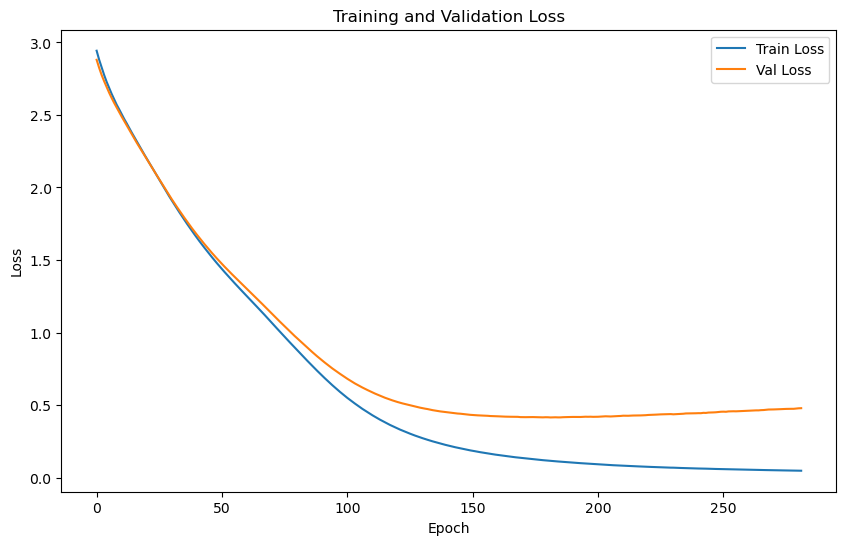

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.5829 | Test Accuracy: 82.46%


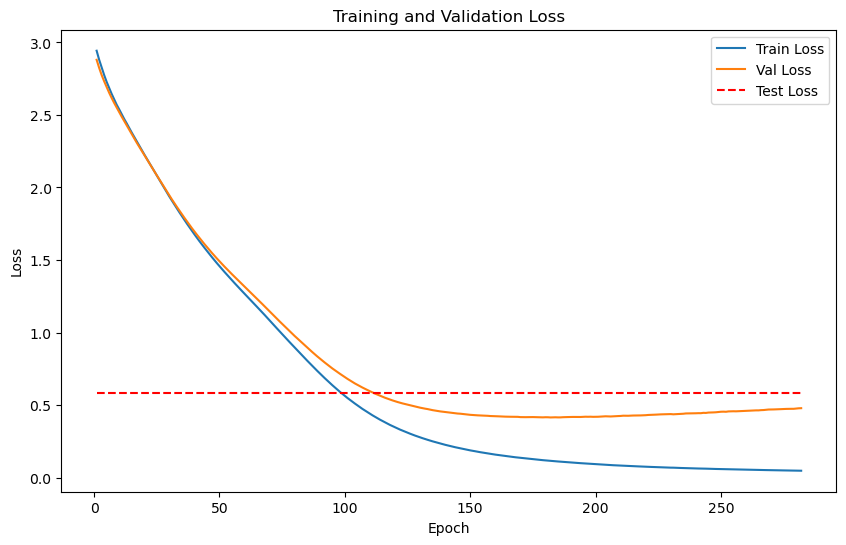

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


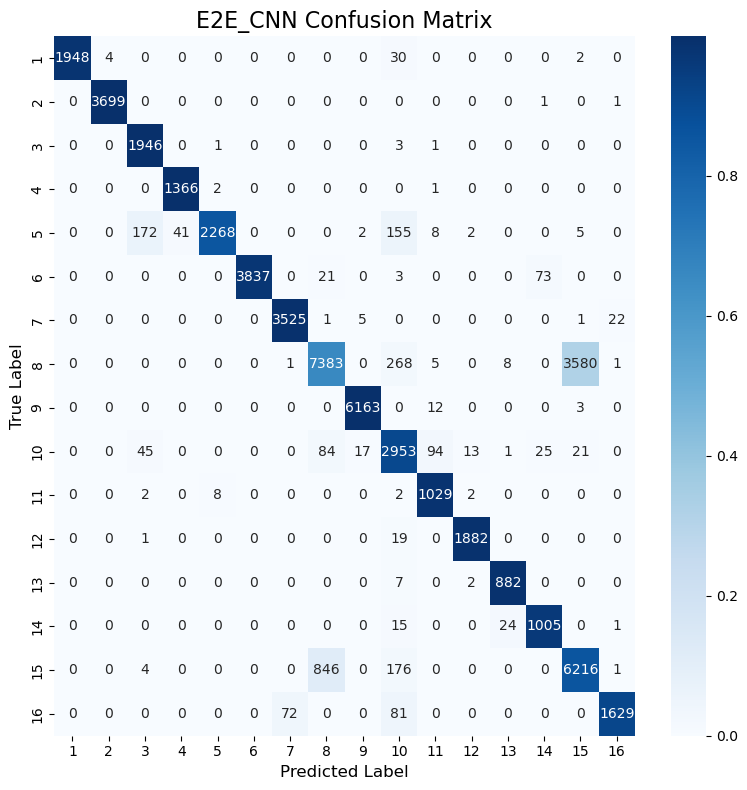

Classification Accuracy: 88.84%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


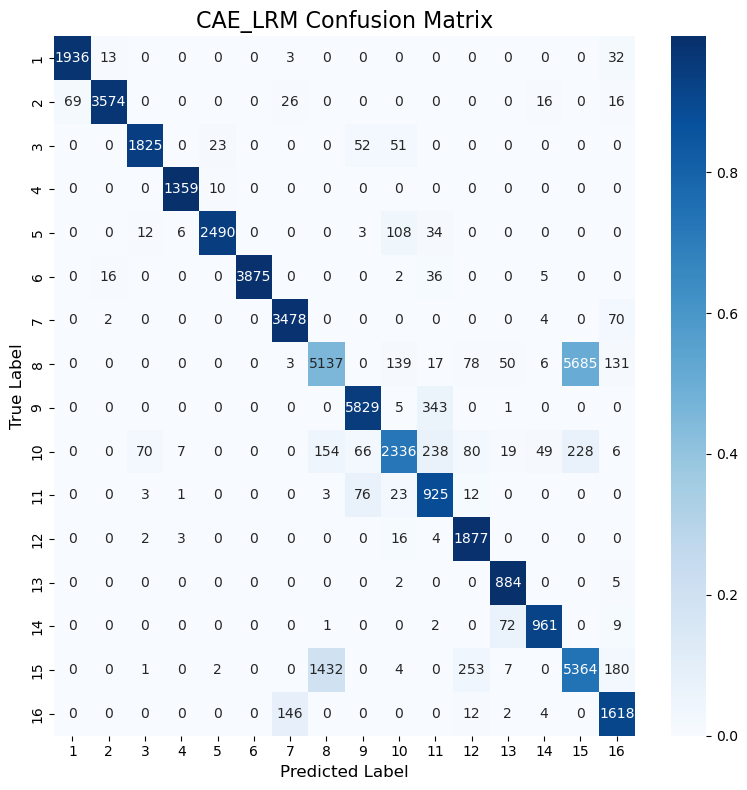

Classification Accuracy: 80.90%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


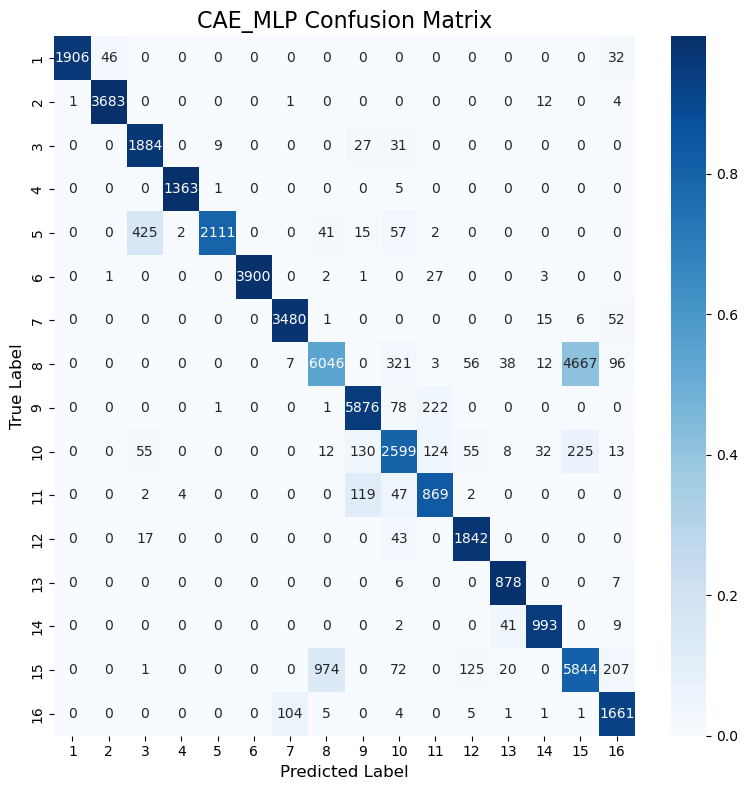

Classification Accuracy: 83.63%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


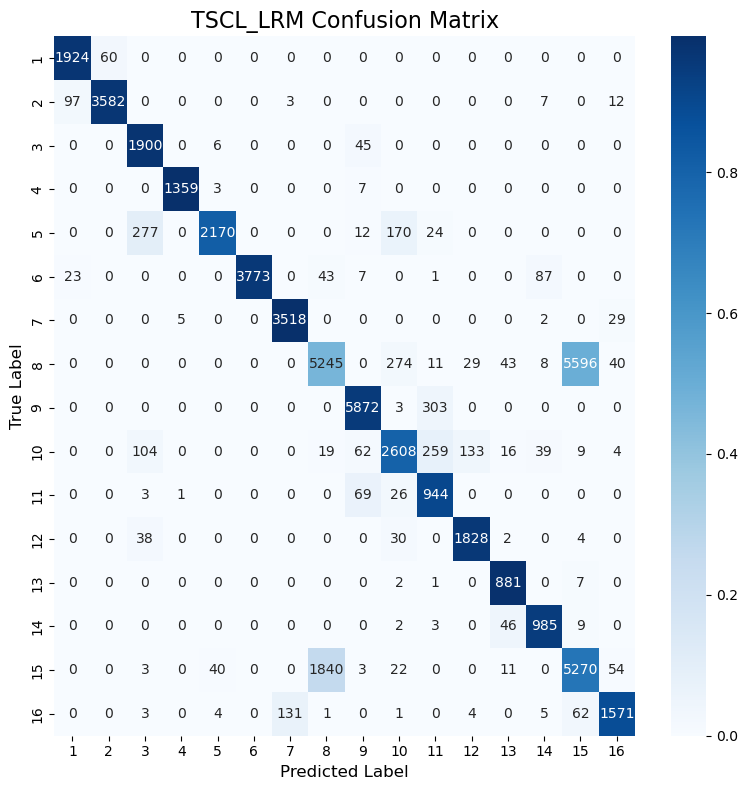

Classification Accuracy: 80.83%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


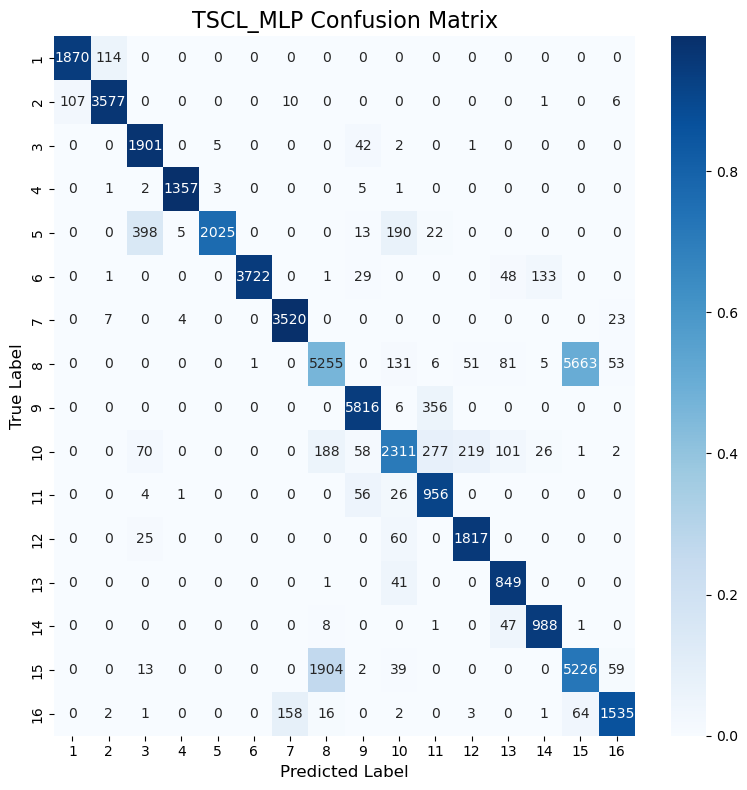

Classification Accuracy: 79.52%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


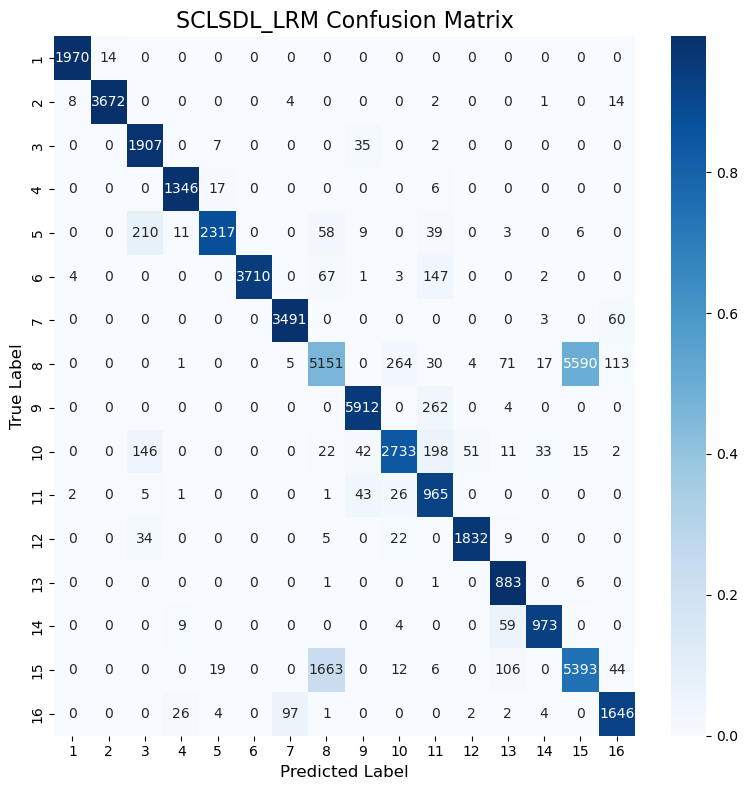

Classification Accuracy: 81.71%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


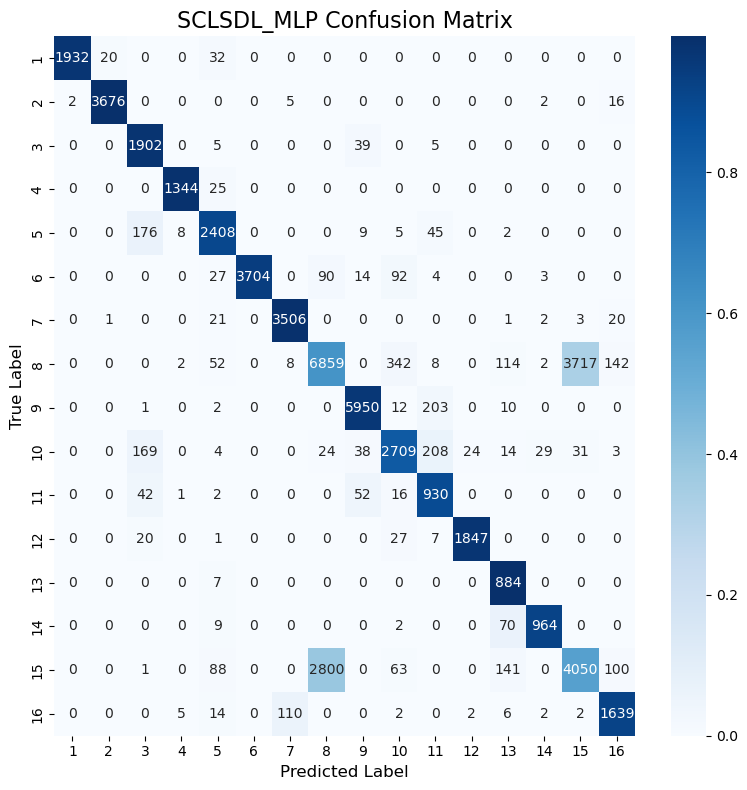

Classification Accuracy: 82.46%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          88.84
1    LRM (CAE)          80.90
2    MLP (CAE)          83.63
3     TSCL LRM          80.83
4     TSCL MLP          79.52
5  SCL_SDL LRM          81.71
6  SCL_SDL MLP          82.46

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          88.84
2    MLP (CAE)          83.63
6  SCL_SDL MLP          82.46
5  SCL_SDL LRM          81.71
1    LRM (CAE)          80.90
3     TSCL LRM          80.83
4     TSCL MLP          79.52
